# Example with correlated distortions: 

In [1]:
%load_ext autoreload
%autoreload 2

In [4]:
import torch
import numpy as np
import scipy
import pytorch_lightning as pl
from tqdm import tqdm

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import os, sys
sys.path.append("../")
plt.style.use('./mystyle.mplstyle')
from simulators.additive import Simulator_Additive_Correlated
from simulators.utils import *
from utils.data import OnTheFlyDataModule, StoredDataModule
from utils.module import CustomLossModule_withBounds, BCELossModule
from utils.gof import t_to_pvalue_empirical, t_to_pvalue

import logging
logging.getLogger('matplotlib.font_manager').disabled = True

mycolors = ['#570f6d', '#bb3754', '#f98e08']

## Simulations

In [ ]:
samples['cni'][0, 2] #5, 21, 61

tensor([ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
        -0.0317, -0.0426, -0.0566, -0.0745, -0.0971, -0.1254, -0.1602, -0.2026,
        -0.2537, -0.3145, -0.3861, -0.4692, -0.5646, -0.6726, -0.7932, -0.9262,
        -1.0708, -1.2255, -1.3887, -1.5579, -1.7304, -1.9029, -2.0717, -2.2330,
        -2.3830, -2.5177, -2.6336, -2.7274, -2.7965, -2.8388, -2.8530, -2.8388,
        -2.7965, -2.7274, -2.6336, -2.5177, -2.3830, -2.2330, -2.0717, -1.9029,
        -1.7304, -1.5579, -1.3887, -1.2255, -1.0708, -0.9262, -0.7932, -0.6726,
        -0.5646, -0.4692, -0.3861, -0.3145, -0.2537, -0.2026, -0.1602, -0.1254,
        -0.0971, -0.0745, -0.0566, -0.0426, -0.0317,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.00

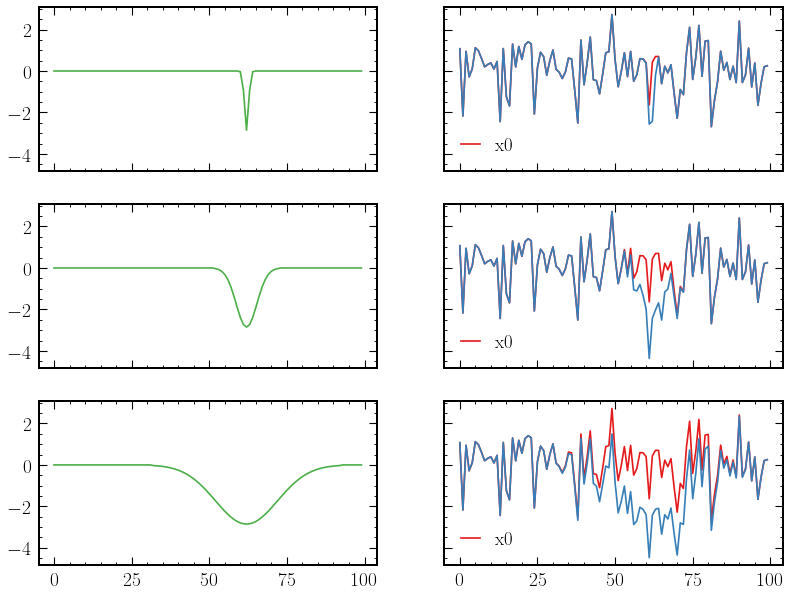

In [6]:
Nsims = 100
Nbins = 100
SIGMA = 1 # Likelihood covariance \Sigma = sigma * \mathbb{1}
correlation_scales = torch.tensor([2, 10, 30]).int()
simulator = Simulator_Additive_Correlated(
    Nbins=Nbins, sigma=SIGMA, bounds=5, fraction=None, bkg=False,
    correlation_scales = correlation_scales,
    dtype=torch.float32, device='cpu'
    )     # Just one bin is distorted with fraction=None  
samples = simulator.sample(Nsims=Nsims)  
 
fig, ax = plt.subplots(3, 2, figsize=(12, 9), sharex=True, sharey=True)
for i in range(3):
    ax[i, 1].plot(samples['x0'][0], label='x0', c='C0')
    ax[i, 1].plot(samples['xi'][0, i], c='C1')
    idx = torch.where(samples['ni'][0]!=0,)
    ax[i ,0].plot(samples['cni'][0, i], c='C2')
    for j in torch.where(samples['ni'][0, 0]!=0)[0]:
        ax[i, 0].axvline(j, color='k', linestyle='--')
        ax[i, 1].axvline(j, color='k', linestyle='--')
    ax[i, 1].legend();

#### Analytical utils

Distortions templates:

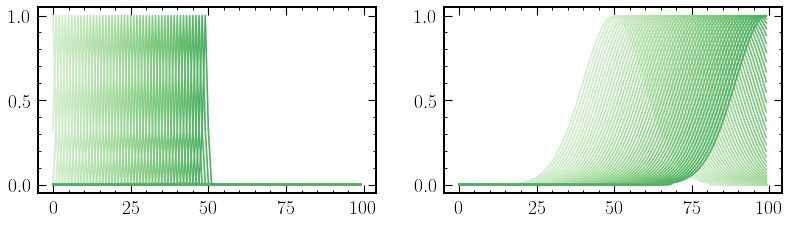

In [4]:
ni_templates = torch.eye(Nbins, dtype=samples['xi'].dtype)
cni_templates = simulator.get_correlation(ni_templates, 1).to(samples['xi'].dtype)

fig, axs = plt.subplots(1, 2, figsize=(12, 3))
axs[0].set_prop_cycle('color',[plt.cm.Greens(i) for i in np.linspace(0.2, 1, Nbins)])
axs[0].plot(cni_templates[:50, 0].T);
axs[1].set_prop_cycle('color',[plt.cm.Greens(i) for i in np.linspace(0.2, 1, Nbins)])
axs[1].plot(cni_templates[50:, 2].T);

epsilon: 18.76252555847168


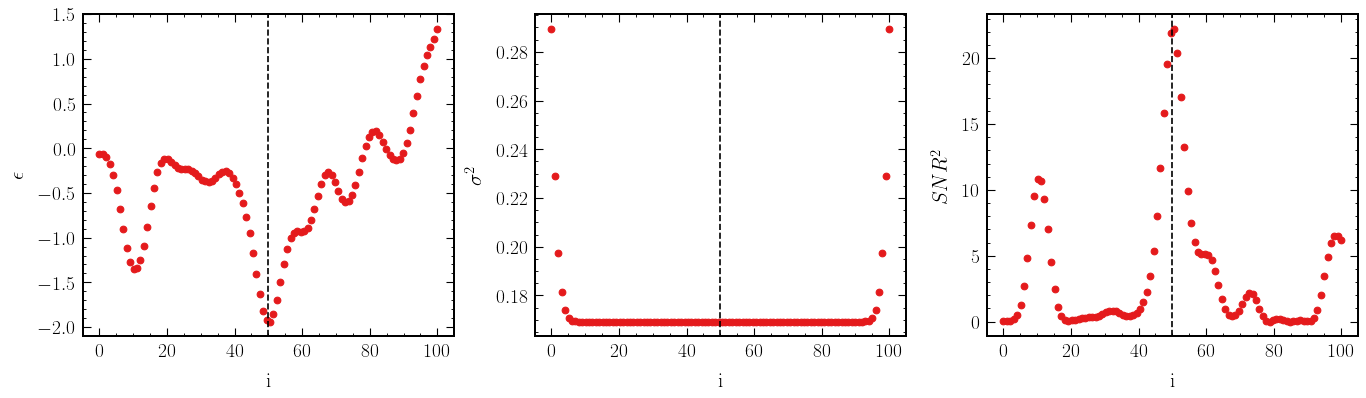

In [5]:
obs = simulator.sample(1)
delta_x = obs['xi']

print(f"epsilon: {(obs['epsilon']*obs['cni']).sum()}")

template_idx = 1

# Plot to check epsilon, sigma^2, SNR of the simulation against different nis
fig, axs = plt.subplots(1, 3, figsize=(17, 5))
axs[0].plot(
    np.linspace(0, Nbins, Nbins),
    get_epsilon(delta_x[0, template_idx], cni_templates[:, template_idx, :], sigma=SIGMA)[0], 
    'o'
)
axs[0].set_ylabel(r'$\epsilon$')
axs[1].plot(
    np.linspace(0, Nbins, Nbins),
    1 / get_sigma_epsilon_inv2(cni_templates[:, template_idx, :], sigma=SIGMA), 
    'o'
)
axs[1].set_ylabel(r'$\sigma^2$')
axs[2].plot(
    np.linspace(0, Nbins, Nbins),
    get_snr(delta_x[0,template_idx], cni_templates[:, template_idx, :], sigma=SIGMA)[0]**2, 
    'o'
)
axs[2].set_ylabel(r'$SNR^2$')

for ax in axs:
    ax.axvline(torch.where(obs['ni'][0]==1), color='k', linestyle='--')

for ax in axs:
    ax.set_xlabel('i')
plt.tight_layout()

Tests

$$
    t = \left(\frac{\Delta \bm x^T \Sigma^{-1} \bm n^{(i)}}{\sqrt{(\bm n^{(i)})^T \Sigma^{-1} \bm n^{(i)}}}\right)^2 + 2\ln p(\epsilon^\ast_{\bm x})+\ln(2\pi\sigma^2_{\epsilon^\ast_{\bm x}})
$$

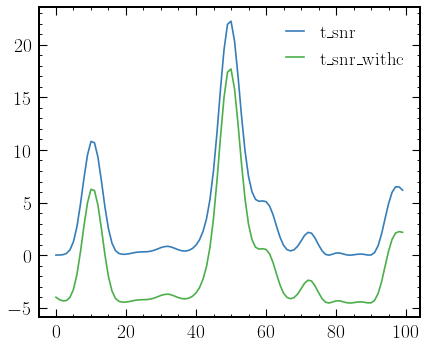

In [6]:
template_idx = 1

variance = 1 / get_sigma_epsilon_inv2(cni_templates[:, template_idx, :])
snr2 = get_snr(delta_x[0,template_idx], cni_templates[:, template_idx, :])[0]**2
t_snr2 = snr2 
t_snr2_c = snr2 + 2*np.log(1/10) + np.log(2*np.pi*variance)

plt.plot(t_snr2, c='C1', label='t_snr')
plt.plot(t_snr2_c, c='C2', label='t_snr_withc')
plt.legend(loc='best');

## Training epsilon

In [7]:
from models.online_norm import OnlineStandardizingLayer
from models.unet_1d import UNet1d 


class Network_epsilon(torch.nn.Module):
    def __init__(self, correlation_scales):
        super().__init__()
        
        self.correlation_scales = correlation_scales
        self.online_norm = OnlineStandardizingLayer((len(correlation_scales), Nbins,), use_average_std=True)    
        self.logvariance = torch.nn.Parameter(torch.ones(len(correlation_scales), Nbins) * 5) # Initialize to big value
        
        self.kernel_sizes = torch.tensor([3, 5, 7]) #correlation_scales + (correlation_scales % 2 == 0).int()  
        self.paddings = (self.kernel_sizes  - 1)// 2 
        self.net = torch.nn.ModuleList(
                [UNet1d(1, 1, sizes=(8, 16, 32, 64, 128)) for i in range(len(correlation_scales))]
        )
                                
    def epsilon(self, x):
        x = self.online_norm(x)
        x = [
            self.net[i](x[:, i, :].unsqueeze(1)).squeeze(1) for i in range(len(self.correlation_scales))
        ]
        x = torch.stack(x, 1) 
        return x
    
    def snr(self, x):
        return self.epsilon(x) / self.logvariance.exp().sqrt()  # [B, N_bins]
    
    def bounds(self):
        return self.logvariance.detach().exp().sqrt().mean(-1) * 5
        
    def forward(self, x):
        
        # Adaptive data generation
        ni = x['ni']
        epsilon_sim =  (2 * self.bounds().unsqueeze(0).unsqueeze(2) * torch.rand(x['xi'].shape, device= x['xi'].device, dtype= x['xi'].dtype) - self.bounds().unsqueeze(0).unsqueeze(2)) * ni.unsqueeze(1)
        cni_sim = torch.stack([simulator._conv1d(ni*epsilon_sim[:, i_c], int(c)) for i_c, c in enumerate(self.correlation_scales)], axis=1)
        data =  x['x0'].unsqueeze(1) + cni_sim
        
        # data = x['x']
        epsilon = self.epsilon(data) #[B, #correlation_scales, N_bins]
        mask = ( x['ni'] != 0 ) 
        squared_error = (epsilon - epsilon_sim)**2   # [B, N_bins]
        l = squared_error / (self.logvariance.exp() + 1e-10) + self.logvariance  
        return (l * mask.unsqueeze(1).float()).sum() * 0.5

In [8]:
# Train
def resample(sample):
    sample = simulator._resample(sample)
    sample['x'] = sample['xi']
    sample = {k: v[0] for k, v in sample.items()}
    return sample

batch_size = 128
# dm = StoredDataModule(samples, batch_size=batch_size, on_after_load_sample=resample)
dm = OnTheFlyDataModule(simulator, Nsims_per_epoch=400*batch_size, batch_size=batch_size)
network_epsilon = Network_epsilon(correlation_scales)
model = CustomLossModule_withBounds(network_epsilon)
trainer = pl.Trainer(
    accelerator="gpu", 
    max_epochs=100, 
    precision=32,
    # fast_dev_run=True
)
trainer.fit(model, dm)
network_epsilon.cuda().eval();

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/noemiam/.pyenv/versions/3.9.16/envs/sbitest/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: ModelCheckpoint
You are using a CUDA device ('NVIDIA A100-SXM4-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/noemiam/.pyenv/versions/3.9.16/envs/sbitest/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=17` in the `DataLoader` to improve performance.


/home/noemiam/.pyenv/versions/3.9.16/envs/sbitest/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=17` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved. New best score: 977.446


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 91.626 >= min_delta = 0.0. New best score: 885.820


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 84.777 >= min_delta = 0.0. New best score: 801.044


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 90.528 >= min_delta = 0.0. New best score: 710.516


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 97.537 >= min_delta = 0.0. New best score: 612.979


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 94.210 >= min_delta = 0.0. New best score: 518.769


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 102.093 >= min_delta = 0.0. New best score: 416.677


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 97.615 >= min_delta = 0.0. New best score: 319.062


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 90.927 >= min_delta = 0.0. New best score: 228.135


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 80.193 >= min_delta = 0.0. New best score: 147.942


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 73.455 >= min_delta = 0.0. New best score: 74.487


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 60.725 >= min_delta = 0.0. New best score: 13.762


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 47.974 >= min_delta = 0.0. New best score: -34.213


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 42.128 >= min_delta = 0.0. New best score: -76.341


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 28.579 >= min_delta = 0.0. New best score: -104.919


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 21.042 >= min_delta = 0.0. New best score: -125.962


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 9.801 >= min_delta = 0.0. New best score: -135.763


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 7.788 >= min_delta = 0.0. New best score: -143.551


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 5.764 >= min_delta = 0.0. New best score: -149.315


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.625 >= min_delta = 0.0. New best score: -149.940


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 1.580 >= min_delta = 0.0. New best score: -151.520


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.203 >= min_delta = 0.0. New best score: -151.723


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 2.251 >= min_delta = 0.0. New best score: -153.975


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Monitored metric val_loss did not improve in the last 7 records. Best score: -153.975. Signaling Trainer to stop.


Reloading best model: /gpfs/home6/noemiam/gofish/lightning_logs/version_0/checkpoints/epoch=31-val_loss=-153.97.ckpt


/gpfs/home6/noemiam/gofish/utils/module.py:147: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(self.best_model_path)


In [9]:
# checkpoint_name = "/home/noemiam/sbi/gofish/notebooks/lightning_logs/version_37/checkpoints/epoch=32-val_loss=-152.40.ckpt"
# checkpoint = torch.load(checkpoint_name)
# state_dict = checkpoint['state_dict']
# new_state_dict = {}
# for key in state_dict:
#     new_key = key.replace('model.', '')  # Remove 'model.' prefix
#     new_state_dict[new_key] = state_dict[key]
    
# network_epsilon.load_state_dict(new_state_dict)
# network_epsilon.cuda().double().eval();

/gpfs/home6/noemiam/gofish/lightning_logs/version_0/checkpoints/epoch=31-val_loss=-153.97.ckpt+loss.pt


tensor([4.0850, 1.8907, 1.1340], device='cuda:0')

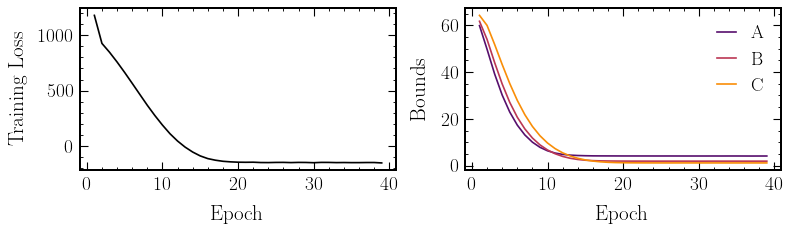

In [10]:
# Convert tensors to scalars if they are tensors
train_loss_history = [loss.item() if hasattr(loss, 'item') else loss for loss in model.train_loss_history]
bounds_history = torch.stack([bound.item() if bound.numel() == 1 else bound for bound in model.bounds_history]).cpu()
torch.save(train_loss_history, f"{trainer.checkpoint_callback.best_model_path}+loss.pt")
torch.save(bounds_history, f"{trainer.checkpoint_callback.best_model_path}+bounds.pt")
print(f"{trainer.checkpoint_callback.best_model_path}+loss.pt")

# train_loss_history = torch.load(f"{checkpoint_name}+loss.pt")
# bounds_history = torch.load(f"{checkpoint_name}+bounds.pt")

# Generate a list of epoch numbers
epochs = range(1, len(train_loss_history) + 1)

fig, axs = plt.subplots(1, 2, figsize=(10, 3))
# Plot Training Loss over Epochs
axs[0].plot(epochs, train_loss_history, c='k')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Training Loss')
# Plot Bounds over Epochs
labels = ["A", "B", "C"]
for i in range(3):
    axs[1].plot(epochs, bounds_history[:, i], c=mycolors[i], label=f'{labels[i]}')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Bounds')
axs[1].legend()
plt.tight_layout();

network_epsilon.bounds()

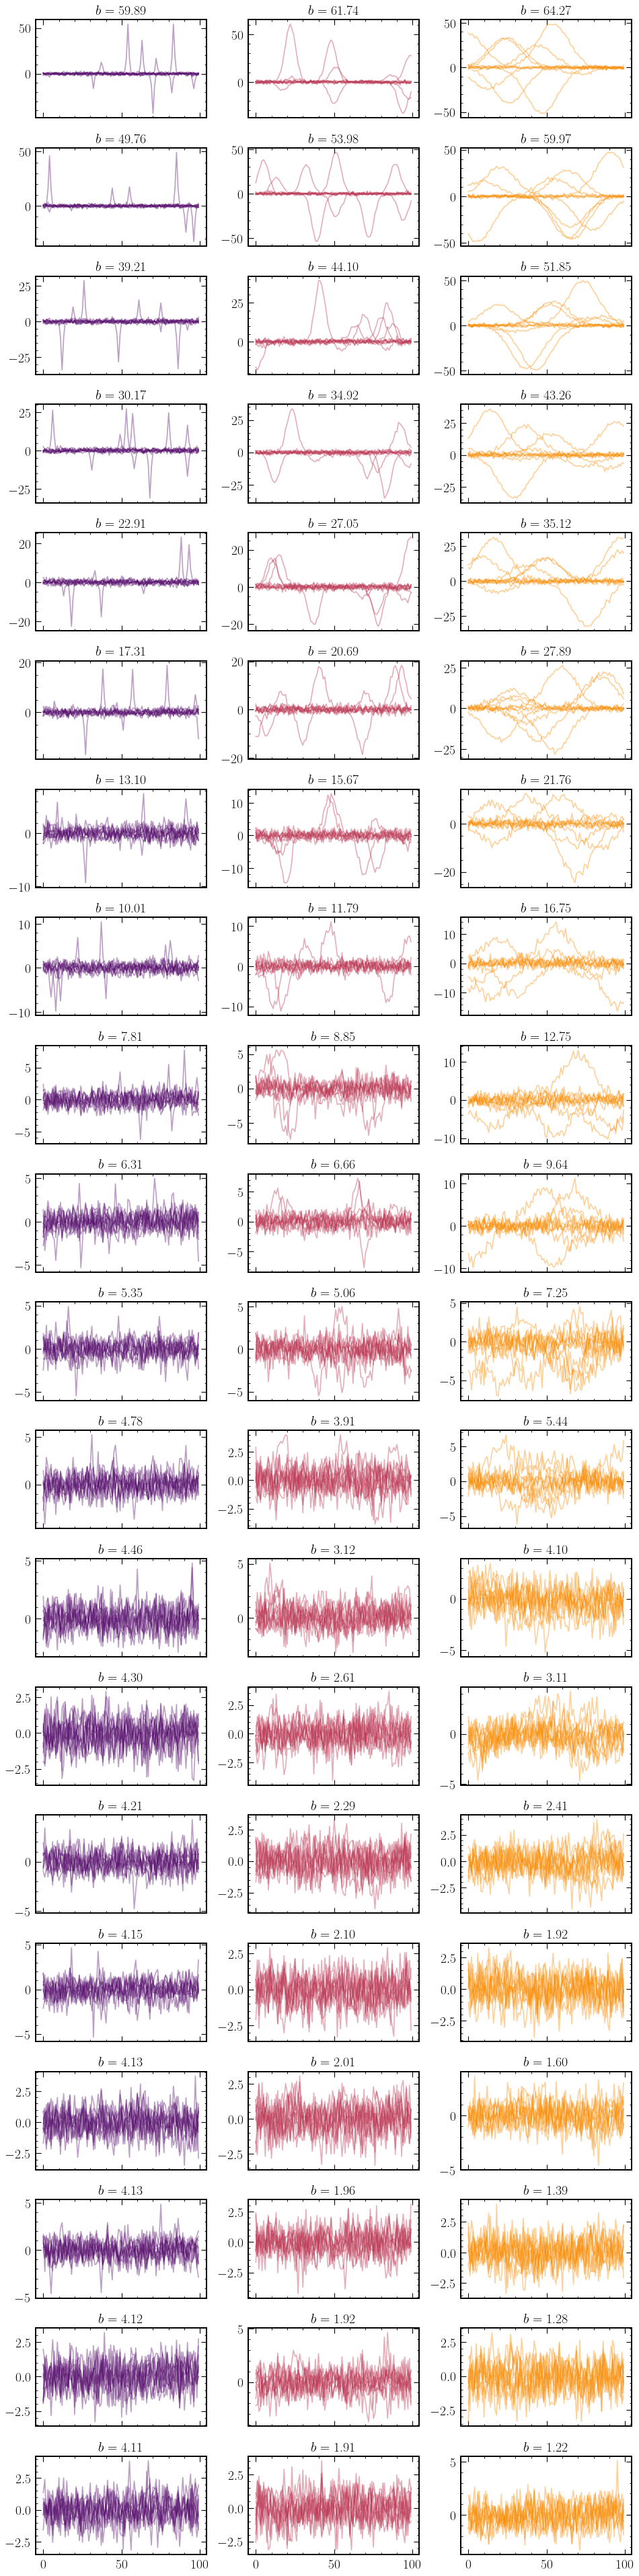

In [11]:
# Distotions enveloping the data
sample = simulator.sample(1)
ni = sample['ni']

fig, axs = plt.subplots(20, 3, figsize=(12, 48), sharex=True)
for i_b, b in enumerate(bounds_history):
    if i_b < len(axs):
        for i in range(len(b)):
            axs[i_b,i].set_title(r"$b$ = {:.2f}".format(b[i]))
            for j in range(10):
                sample = simulator.sample(1)
                ni = sample['ni']
                epsilon_sim =  (2 * b.unsqueeze(0).unsqueeze(2) * torch.rand(sample['xi'].shape, device= sample['xi'].device, dtype= sample['xi'].dtype) - b.unsqueeze(0).unsqueeze(2)) * ni.unsqueeze(1)
                cni_sim = torch.stack([simulator._conv1d(ni*epsilon_sim[:, i_c], int(c)) for i_c, c in enumerate(correlation_scales)], axis=1)
                data =  sample['x0'].unsqueeze(1) + cni_sim
                axs[i_b, i].plot(data[0,i].cpu(), c=mycolors[i], alpha=0.4)
plt.tight_layout();

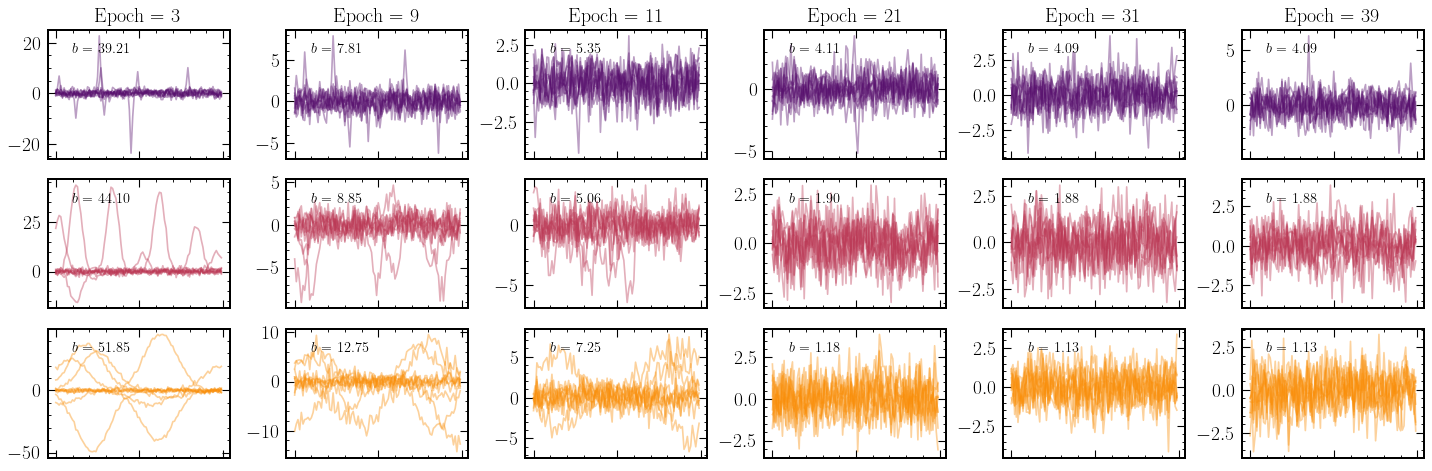

In [12]:
# Distotions enveloping the data
sample = simulator.sample(1)
ni = sample['ni']

fig, axs = plt.subplots(3, 6, figsize=(18, 6), sharex=True)
for i in range(3):
    for ii, idx_epoch in enumerate([2, 8, 10, 20, 30, -1]):
        axs[0,ii].set_title(r"Epoch = {:.0f}".format(int(epochs[idx_epoch])))
        b = bounds_history[idx_epoch]
        axs[i, ii].set_xticklabels([])
        axs[i, ii].plot([],[], label=r"$b$ = {:.2f}".format(b[i]))
        axs[i, ii].legend(loc='upper left', fontsize=13, handlelength=0)
        for j in range(10):
            sample = simulator.sample(1)
            ni = sample['ni']
            epsilon_sim =  (2 * b.unsqueeze(0).unsqueeze(2) * torch.rand(sample['xi'].shape, device= sample['xi'].device, dtype= sample['xi'].dtype) - b.unsqueeze(0).unsqueeze(2)) * ni.unsqueeze(1)
            cni_sim = torch.stack([simulator._conv1d(ni*epsilon_sim[:, i_c], int(c)) for i_c, c in enumerate(correlation_scales)], axis=1)
            data =  sample['x0'].unsqueeze(1) + cni_sim
            axs[i, ii].plot(data[0,i].cpu(), c=mycolors[i], alpha=0.4)
        
plt.tight_layout()

---

## Evaluate

#### From here on test with bounds to which the NN converged: 

In [13]:
bounds = network_epsilon.bounds().detach().cpu()

simulator = Simulator_Additive_Correlated(
    Nbins=Nbins, sigma=SIGMA, bounds=bounds, fraction=None, bkg=False,
    correlation_scales = correlation_scales,
    dtype=torch.float32, device='cpu'
    )    

bounds

tensor([4.0850, 1.8907, 1.1340])

#### Check NN outputs

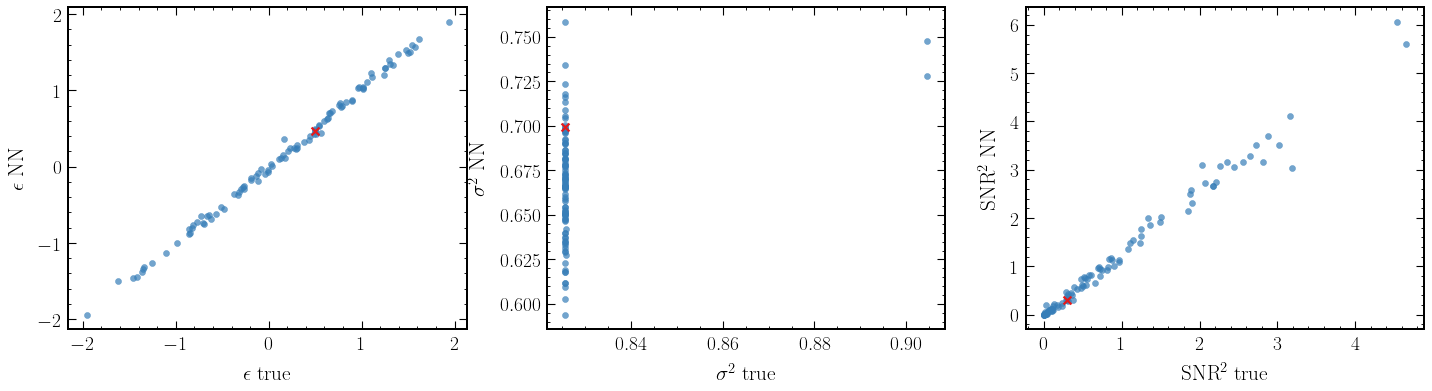

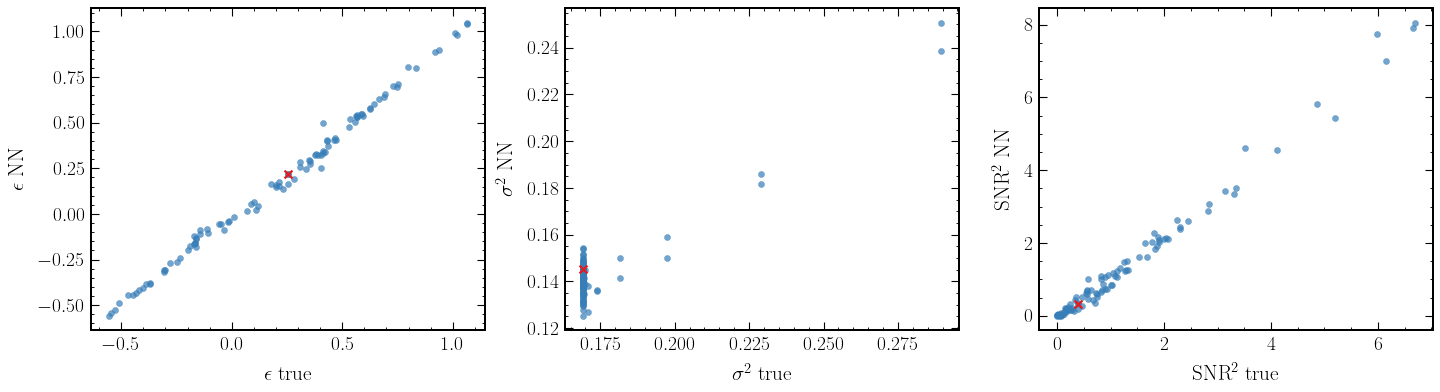

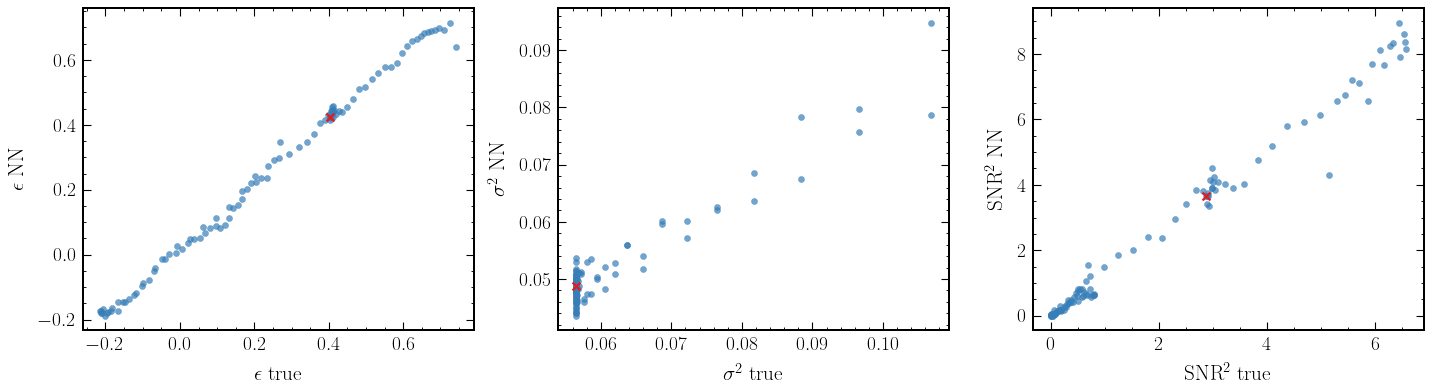

In [14]:
obs = simulator.sample(1)
delta_x = obs['xi']
network_epsilon.cuda()
epsilon_nn_obs = network_epsilon.epsilon(obs['xi'].cuda()).detach().cpu().numpy().squeeze(0)          #[len(correlation_scales), Nbins]
variance_nn_obs = network_epsilon.logvariance.exp().detach().cpu().numpy()                            #[len(correlation_scales), Nbins]
snr_nn_obs = network_epsilon.snr(obs['xi'].cuda()).detach().cpu().numpy().squeeze(0)                  #[len(correlation_scales), Nbins]

for idx_c in range(len(correlation_scales)):
    epsilon_obs = get_epsilon(delta_x[:, idx_c], cni_templates[:, idx_c]).squeeze(0)      #[Nbins, len(correlation_scales)]
    variance_obs = 1 / get_sigma_epsilon_inv2(cni_templates[:, idx_c])
    snr_obs = get_snr(delta_x[:, idx_c], cni_templates[:, idx_c]).squeeze(0) 

    # For each simultion of the n ones, compute analytical quantities
    fig, axs = plt.subplots(1, 3, figsize=(18, 5))
    mask = torch.where(variance_obs < 1.0000001)[0]
    axs[0].scatter(x=epsilon_obs[mask], y=epsilon_nn_obs[idx_c][mask], c='C1', s=30, marker='o',linewidths=0.4, alpha=0.7)
    axs[1].scatter(x=variance_obs[mask], y=variance_nn_obs[idx_c][mask], c='C1', s=30, marker='o',linewidths=0.4, alpha=0.7)
    axs[2].scatter(x=snr_obs[mask]**2, y=snr_nn_obs[idx_c][mask]**2, c='C1', s=30, marker='o',linewidths=0.4, alpha=0.7)
        
    idx = torch.where(obs['ni'][0]==1)[0]
    axs[0].scatter(x=epsilon_obs[idx], y=epsilon_nn_obs[idx_c][idx], c='C0', s=50, marker='x',linewidths=2)
    axs[1].scatter(x=variance_obs[idx], y=variance_nn_obs[idx_c][idx], c='C0', s=50, marker='x',linewidths=2)
    axs[2].scatter(x=snr_obs[idx]**2, y=snr_nn_obs[idx_c][idx]**2, c='C0', s=50, marker='x',linewidths=2)

    axs[0].set_xlabel(r'$\epsilon$ true')
    axs[0].set_ylabel(r'$\epsilon$ NN')
    axs[1].set_xlabel(r'$\sigma^2$ true')
    axs[1].set_ylabel(r'$\sigma^2$ NN')
    axs[2].set_xlabel(r'$\mathrm{SNR}^2$ true')
    axs[2].set_ylabel(r'$\mathrm{SNR}^2$ NN')

    plt.tight_layout();

---

#### Monte-Carlo H0

$$
    t_i(\mathbf x) \propto \text{SNR}_i^2(\bm x)  
$$

In [15]:
N_mc = 2e6

variance = 1 / get_sigma_epsilon_inv2(ni_templates)

# if os.path.exists("mc_h0.npy"):
#     ts_bin_H0_epsilon  = np.load("mc_h0.npy")
# else:
batch_size = 1024
N_batch = int(N_mc / batch_size)
ts_bin_H0_epsilon  = []
for _ in tqdm(range(N_batch)):
    mc_samples = simulator.sample(batch_size)
    ts_batch = (network_epsilon.snr(mc_samples['x0'].unsqueeze(1).expand(-1, len(simulator.correlation_scales), Nbins).cuda())**2).detach().cpu().numpy()
    ts_bin_H0_epsilon .append(ts_batch)
    
ts_bin_H0_epsilon  = np.concatenate(ts_bin_H0_epsilon )
ts_bin_H0_epsilon .shape

  0%|          | 0/1953 [00:00<?, ?it/s]

100%|██████████| 1953/1953 [00:27<00:00, 70.03it/s]


(1999872, 3, 100)

Histogram of $t_i | H_0$ in individual bins

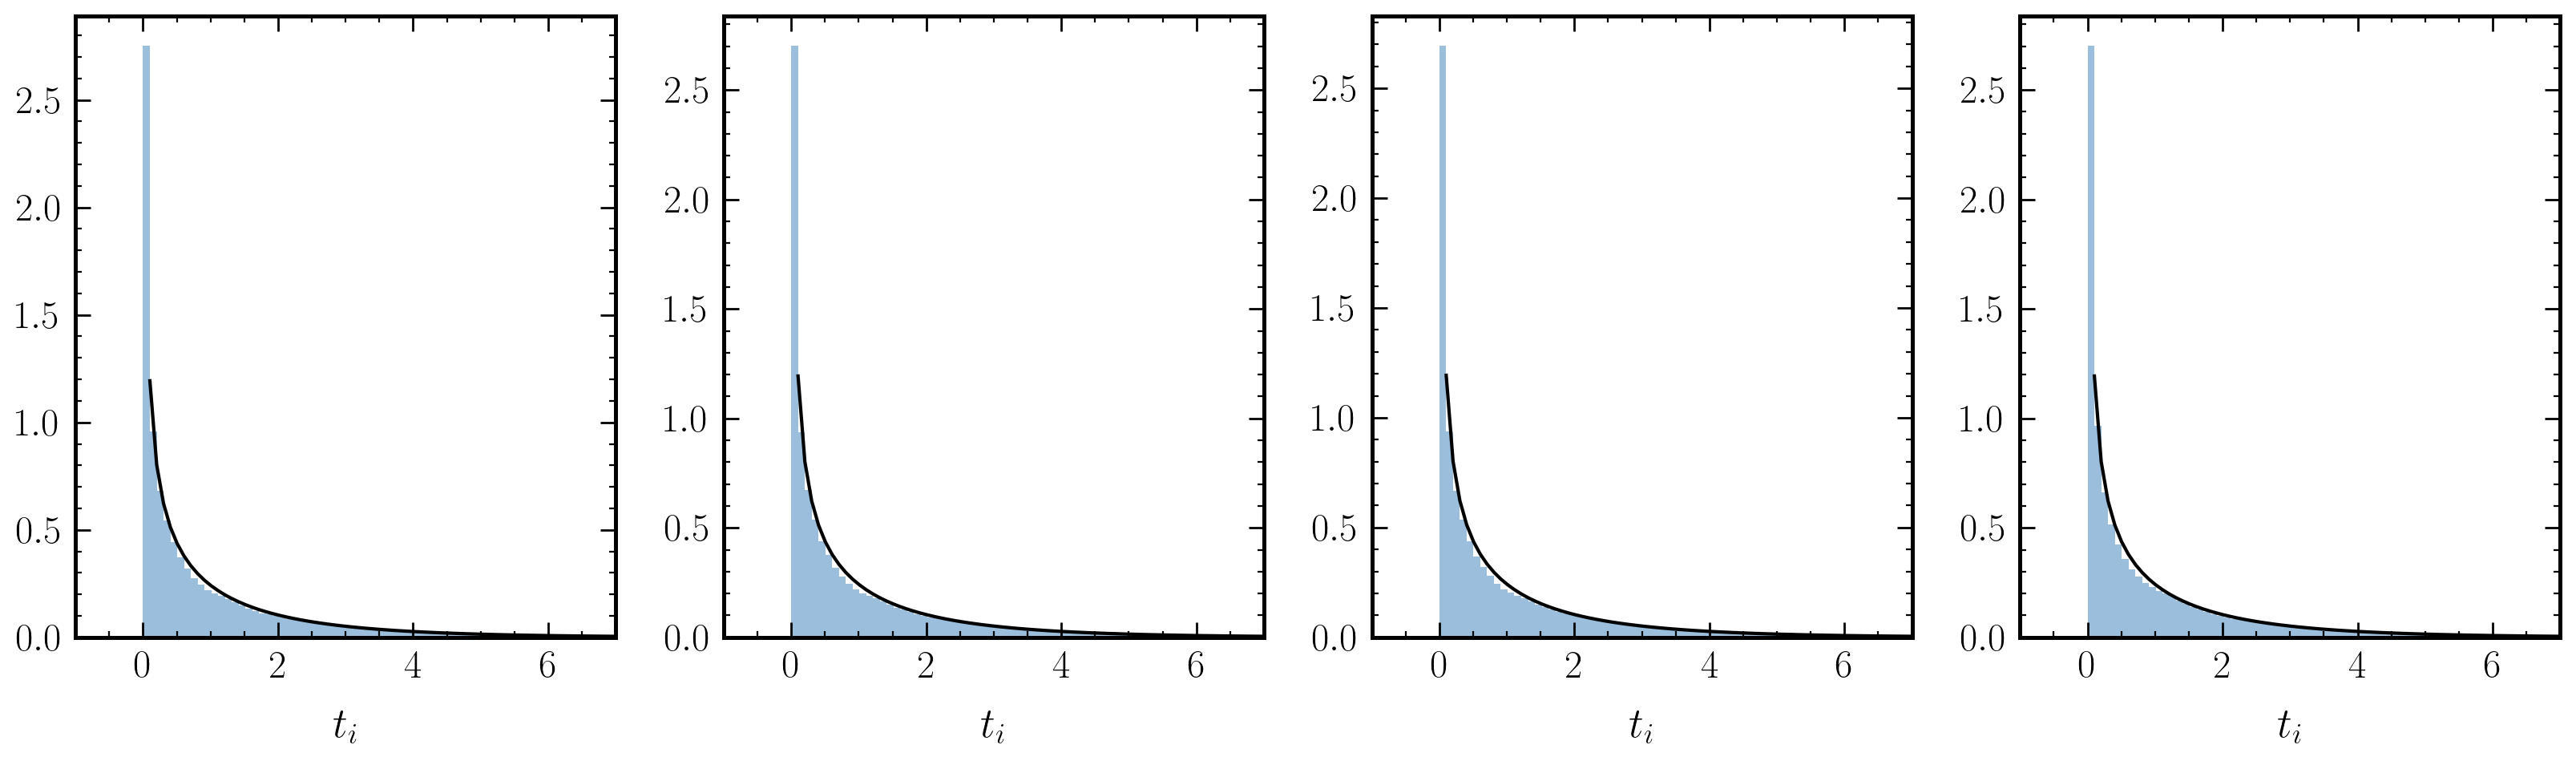

In [16]:
# Compare with chi2 with df = 1 ?
grid = np.linspace(0, 10, 100) # 1 df, adjust
chi2 = scipy.stats.chi2.pdf(grid, df=1, loc=0)

idx_c = 1
fig, axs = plt.subplots(1, 4, figsize=(20, 5), dpi=200)
for i in range(4):
    bin = torch.randint(Nbins, (1,))
    ts_bin_i = ts_bin_H0_epsilon [:, idx_c, bin]

    bins = np.linspace(0, 10, 100)
    axs[i].hist(ts_bin_i, bins=bins, density=True, color='C1', alpha=0.5)
    
    axs[i].set_xlabel('$t_i$')
    axs[i].set_xlim(-1, 7)
    axs[i].plot(grid, chi2, c='k', label='$\chi^2$ with df=1')
    # axs[i].legend();

---

### Individual deviations test

- Localized $t_i$
- Localized $\mathrm{p}_i$ for anomaly detection
- Residual analysis with $\epsilon_i$ map

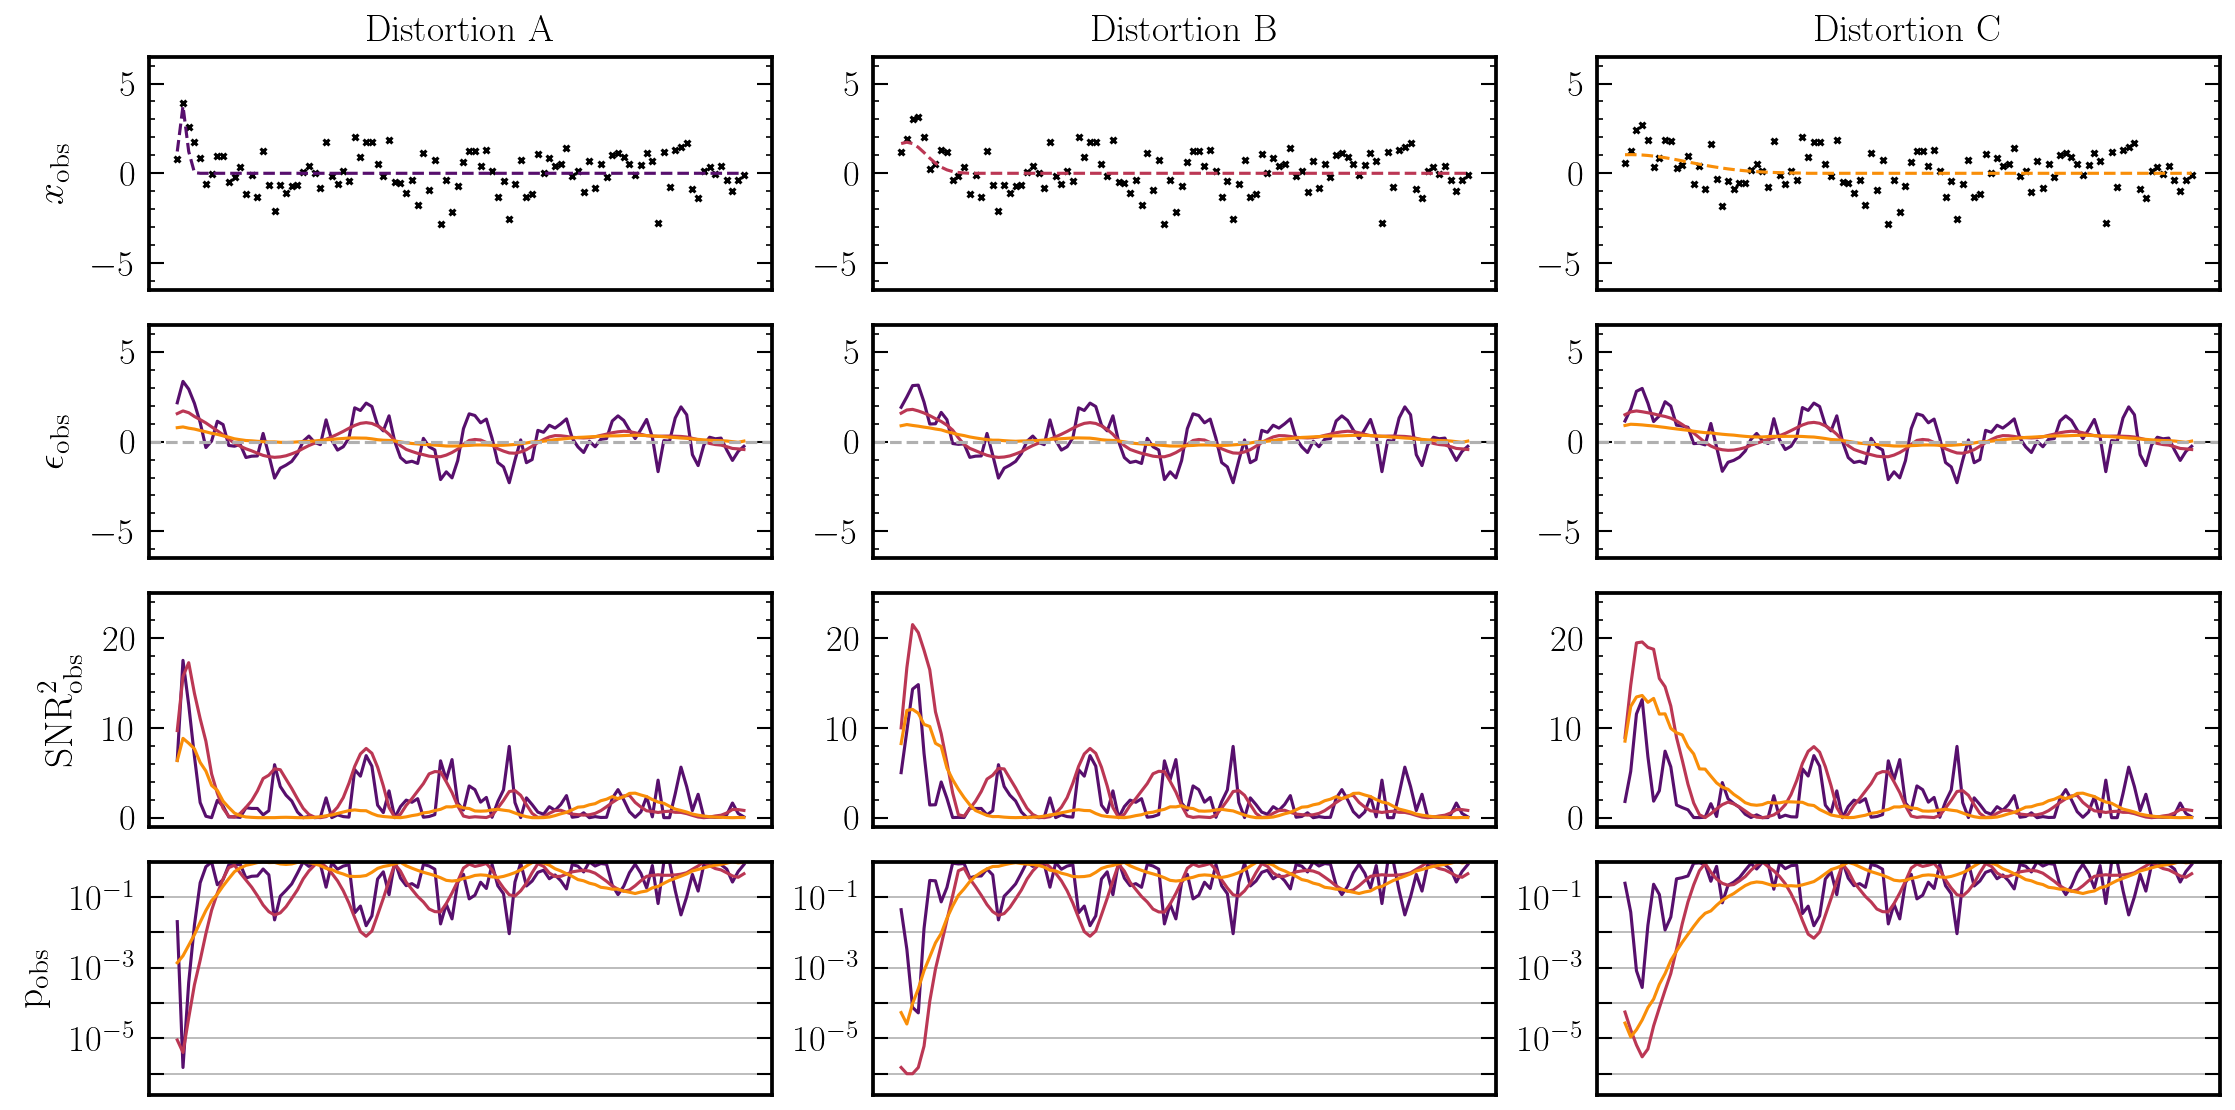

In [17]:
for nn in range(1):
    obs = simulator.sample(1)
    # # Choose clear distortion
    # obs['x0'] = simulator.get_x_H0(1, obs['mu'])
    # obs['ni'][obs['ni']==1] = 0
    # obs['ni'][0,50] = 1
    # obs['epsilon'] = obs['ni'].unsqueeze(1) * torch.tensor([3.2, 2.1, 1.1]).unsqueeze(0).unsqueeze(2)
    # obs['cni'] = simulator.get_correlation(obs['ni'],  obs['epsilon'])
    # obs['xi'] = simulator.get_x_Hi(obs['cni'], obs['x0'].unsqueeze(1))

    dist = obs['xi'] - obs['x0']
    grid = torch.linspace(0, 10, Nbins)

    fig, axs = plt.subplots(4, 3, figsize=(15, 7.5), dpi=150)
    labels = ["A", "B", "C"]
    for i in range(3):
        
        target = obs['xi'][:, i].unsqueeze(1).expand(-1, len(simulator.correlation_scales), -1)
        
        # Evaluate epsilon and SNR^2 test statistic from NN
        epsilon_nn = network_epsilon.epsilon(target.cuda()).detach().cpu().numpy().squeeze(0)       #[len(correlation_scales), Nbins]
        snr2_nn = network_epsilon.snr(target.cuda()).detach().cpu().numpy().squeeze(0)**2            #[len(correlation_scales), Nbins]

        # Compute p-values
        _p_nn = []
        for idx, ts_bin in enumerate(snr2_nn.T):
            ts_bin_i = ts_bin_H0_epsilon [:, :, idx]          #[N_mc, len(correlation_scales)]
            m = ts_bin_i.mean(0)                     #[len(correlation_scales)]
            ts0_ref = ts_bin_i - m                   #[N_mc, len(correlation_scales)]
            ts_obs = (ts_bin - m)
            _p_nn.append(np.stack([
                t_to_pvalue_empirical(ts_obs[c], ts0_ref[:, c]) for c in range(len(simulator.correlation_scales))
            ], axis=0))        #[len(correlation_scales)]
        p_nn = np.array(_p_nn)                   #[Nbins, len(correlation_scales)]
        
        # Plotting
        axs[0, i].scatter(grid, obs['xi'][0, i], color='k', marker='x', s=8)
        axs[0, i].plot(grid, dist[0, i], color=mycolors[i], ls='--', label="$\mu_{\mathrm{dist}}$")
        axs[0, i].set_title(f"Distortion {labels[i]}")
        axs[0, i].set_ylim(-6.5, 6.5)
        axs[0, i].set_xticks([])
        
        
        for idx, color in enumerate(mycolors):  # Loop through colors and indices
            axs[1, i].plot(grid, epsilon_nn.T[:,idx], c=color)  # Plot each line with the corresponding color
        axs[1, i].set_ylim(-6.5, 6.5)
        axs[1, i].axhline(0, color='#b0b0b0', linestyle='--')
        axs[1, i].set_xticks([])
        
        for idx, color in enumerate(mycolors):
            axs[2, i].plot(grid, snr2_nn.T[:,idx], c=color)
        axs[2, i].set_ylim(-1, 25)
        axs[2, i].set_xticks([])

        for idx, color in enumerate(mycolors):
            axs[3, i].semilogy(grid, p_nn[:, idx], c=color)
        axs[3, i].set_ylim(1/(N_mc*2), 1)
        axs[3, i].grid(True, axis='y')
        axs[3, i].set_xticks([])
        axs[3, i].yaxis.set_major_locator(ticker.LogLocator(base=10.0, numticks=10))
        axs[3, i].yaxis.set_minor_locator(ticker.NullLocator())
        axs[3, i].grid(True, axis='y', which='major')
        axs[3, i].set_yticks([1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6])  # Specify tick positions
        axs[3, i].set_yticklabels([r"$10^{-1}$", None , r"$10^{-3}$", None, r"$10^{-5}$", None])  # Customize tick labels
        
        
    # axs[0, 0].legend()
    axs[0, 0].set_ylabel("$x_\mathrm{obs}$")
    axs[1, 0].set_ylabel(r"$\epsilon_\mathrm{obs}$")
    axs[2, 0].set_ylabel(r"$\mathrm{SNR}^2_\mathrm{obs}$")
    axs[3, 0].set_ylabel("$\mathrm{p}_\mathrm{obs}$")
    # axs[1, 0].legend(loc='best')
    # axs[2, 0].legend(loc='best')
    # axs[3, 0].legend(loc='best')
    plt.tight_layout();

---

### Total deviations test

- Aggregated $t_{\rm sum}(x) = \sum_{i=1}^{N_{\rm alt}} - 2 \log\frac{p(x|H_0)}{p(x|H_i)} $
- Aggregated $\mathrm{p_{sum}}$ for model validation
- Residual variance analysis with $\epsilon_i$ histogram

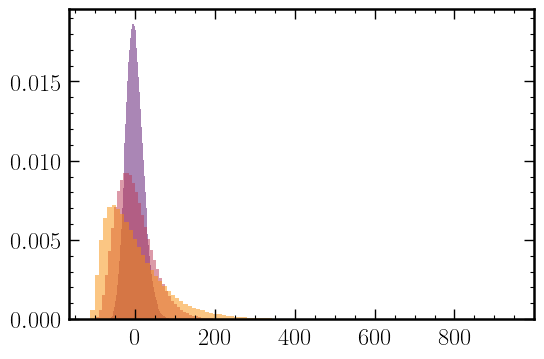

In [18]:
# From MCMC samples
ts_sum_H0_epsilon  = ts_bin_H0_epsilon.sum(axis=-1)                  #[N_mc, len(correlation_scales)]
ts_sum_H0_epsilon_mean = ts_sum_H0_epsilon .mean(0, keepdims=True)   #[1, len(correlation_scales)]
ts_sum_H0_epsilon  = ts_sum_H0_epsilon - ts_sum_H0_epsilon_mean              #[N_mc, len(correlation_scales)]   

# Plot
fig, ax = plt.subplots(1, 1, figsize=(6, 4), dpi=100)
bins = np.linspace(ts_sum_H0_epsilon.min(), ts_sum_H0_epsilon.max(), 100)
for i in range(len(correlation_scales)):
    ax.hist(ts_sum_H0_epsilon [:, i], bins=100, alpha=0.5, color=mycolors[i], density=True);

#### Plot

/scratch-local/noemiam.8976036/ipykernel_2697282/1851716559.py:57: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc='best')


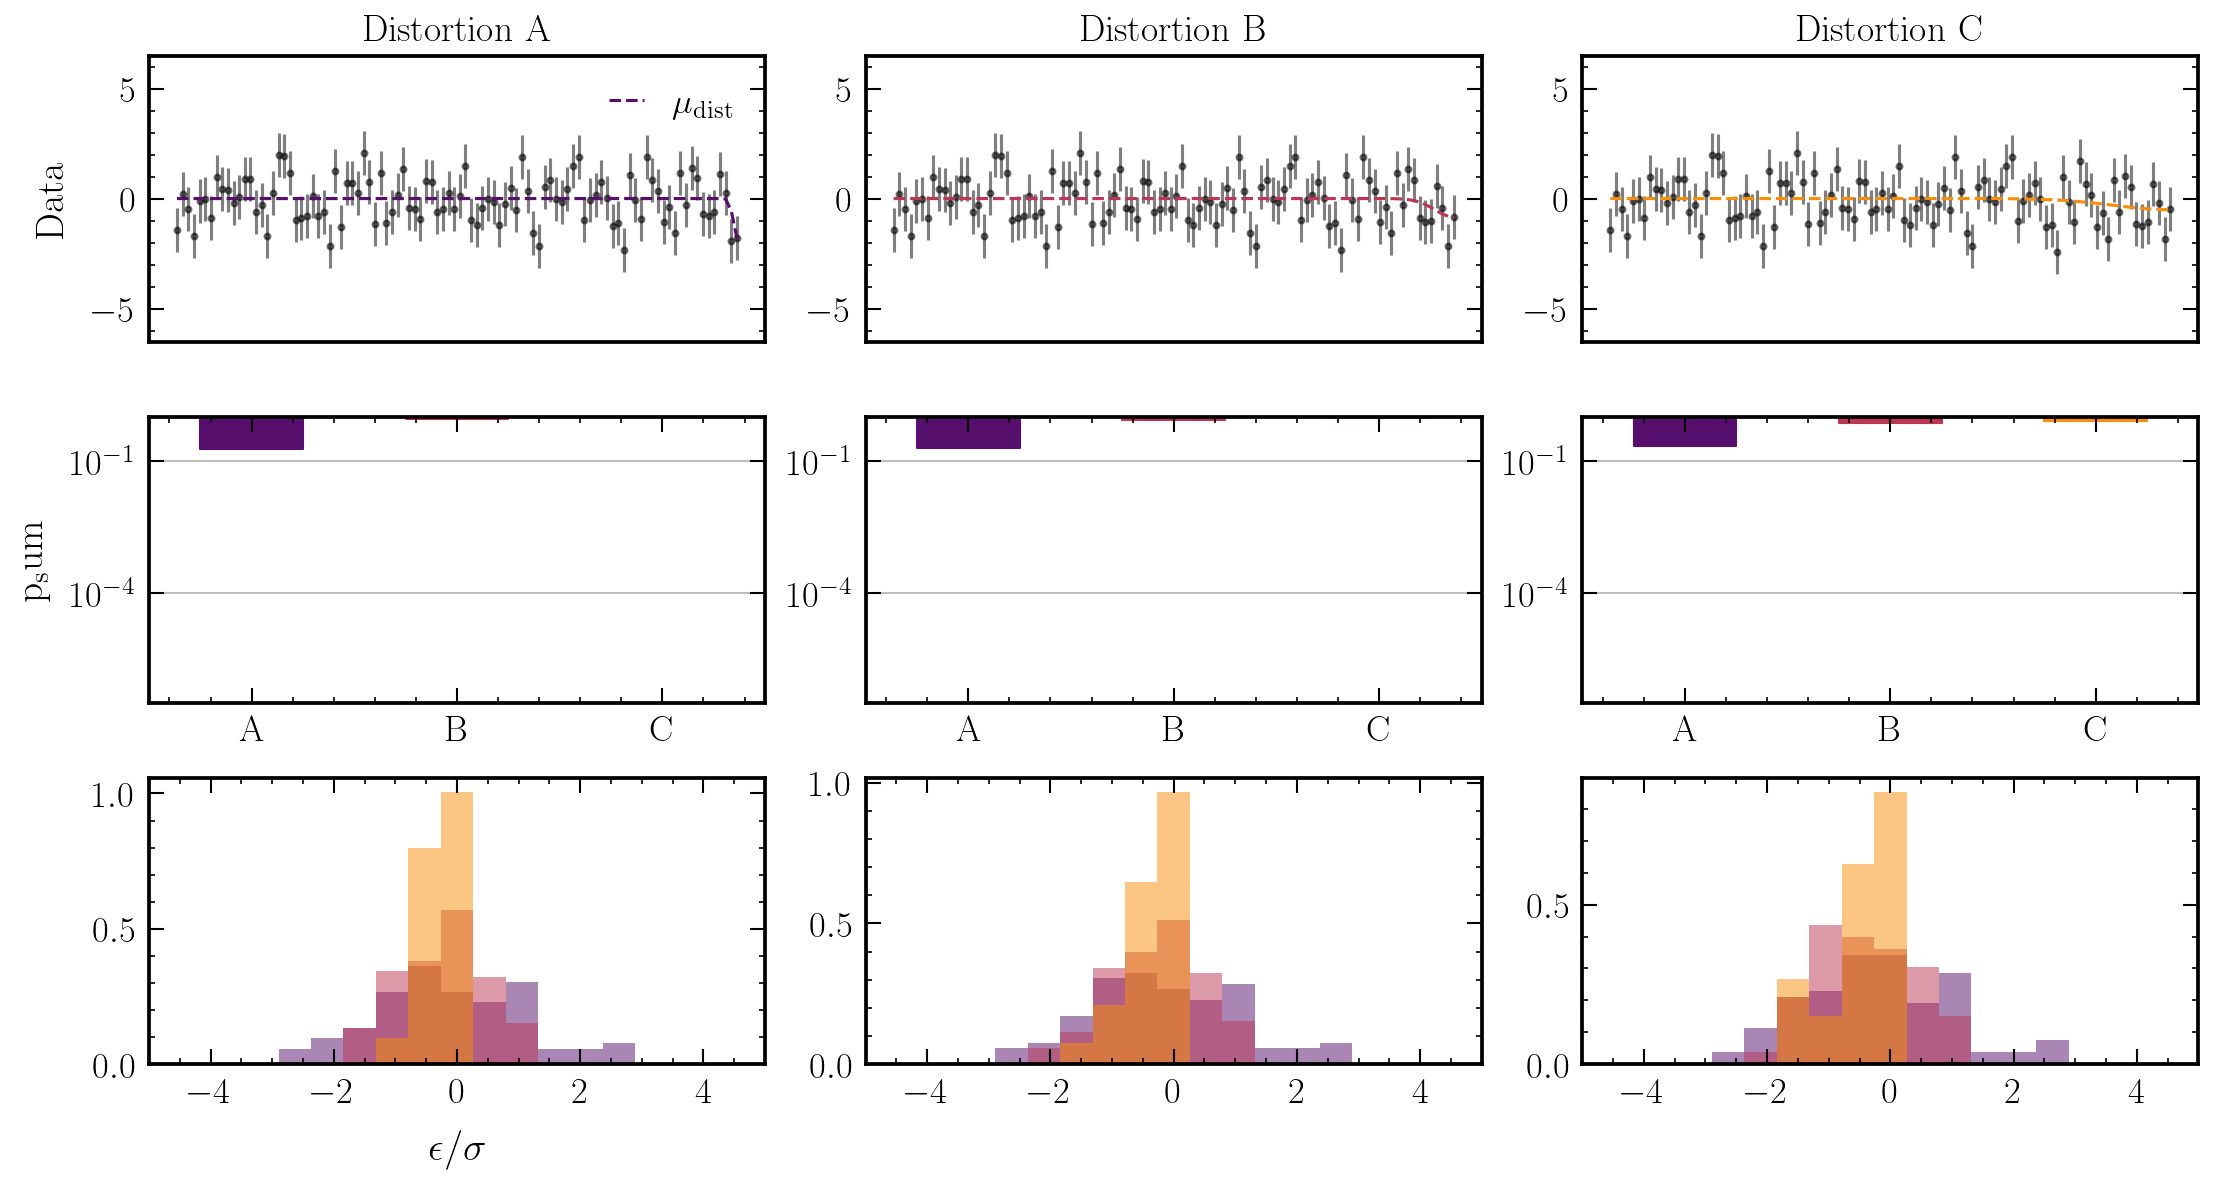

In [19]:
obs = simulator.sample(1)
# # Choose clear distortion
# obs['x0'] = simulator.get_x_H0(1, obs['mu'])
# obs['ni'][obs['ni']==1] = 0
# obs['ni'][0,50] = 1
# obs['epsilon'] = obs['ni'].unsqueeze(1) * torch.tensor([4, 3, 2]).unsqueeze(0).unsqueeze(2)
# obs['cni'] = simulator.get_correlation(obs['ni'],  obs['epsilon'])
# obs['xi'] = simulator.get_x_Hi(obs['cni'], obs['x0'].unsqueeze(1))

dist = obs['xi'] - obs['x0']
grid = torch.linspace(0, 10, Nbins)

fig, axs = plt.subplots(3, 3, figsize=(15, 8), dpi=150)
labels = ["A", "B", "C"]
for i in range(3):
    
    target = obs['xi'][:, i].unsqueeze(1).expand(-1, len(simulator.correlation_scales), -1)
    
    # Evaluate epsilon and SNR^2 test statistic from NN
    epsilon_nn = network_epsilon.epsilon(target.cuda()).detach().cpu().numpy().squeeze(0)       #[len(correlation_scales), Nbins]
    snr2_nn = network_epsilon.snr(target.cuda()).detach().cpu().numpy().squeeze(0)**2            #[len(correlation_scales), Nbins]
    variance_nn =  network_epsilon.logvariance.exp().detach().cpu().numpy()                     #[len(correlation_scales), Nbins]
    ts_sum_nn = snr2_nn.sum(axis=-1)-ts_sum_H0_epsilon_mean[0]
    p_sum_nn = np.stack([
        t_to_pvalue_empirical(ts_sum_nn[c], ts_sum_H0_epsilon [:, c]) for c in range(len(simulator.correlation_scales))
    ], axis=0)        #[len(correlation_scales)]

    # Plotting
    axs[0, i].scatter(grid, obs['xi'][0, i], color='k', alpha=0.5, s=8)
    axs[0, i].errorbar(grid, obs['xi'][0, i], yerr=1, fmt='none', ecolor='k', alpha=0.5)
    axs[0, i].plot(grid, dist[0, i], color=mycolors[i], ls='--', label="$\mu_{\mathrm{dist}}$")
    axs[0, i].set_title(f"Distortion {labels[i]}")
    axs[0, i].set_ylim(-6.5, 6.5)
    axs[0, i].set_xticks([])
    
    axs[1, i].set_yscale('log')
    axs[1, i].set_ylim(1/(N_mc*1.5), 1)
    axs[1, i].set_xticks([0, 1, 2])
    axs[1, i].set_xticklabels(labels)
    axs[1, i].set_xlim(-0.5, 3 - 0.5)
    axs[1, i].grid(True, axis='y')
    for x, value_nn in zip([0, 1, 2], p_sum_nn):
        left = x - 0.5 / 2
        right = x + 0.5 / 2
        axs[1, i].fill_between([left, right], 1, value_nn, facecolor=mycolors[x], edgecolor=mycolors[x])
    
    bins = np.linspace(-5*SIGMA, 5*SIGMA, int(Nbins/5))
    for x in range(3):
        axs[2, i].hist(epsilon_nn[x]/np.sqrt(variance_nn[x]), bins=bins, density=True, color=mycolors[x], alpha=0.5)
    axs[2, i].set_xlim(-5*SIGMA, 5*SIGMA)
    
axs[0, 0].set_ylabel("Data")
axs[1, 0].set_ylabel("$\mathrm{p_sum}$")
axs[2, 0].set_xlabel("$\epsilon / \sigma$")

for ax in axs[:, 0]:
    ax.legend(loc='best')

plt.tight_layout();

---

### Global deviations test

Trial correct for the fact that we looked Nbins times + aggregated tests. What’s the overall significance given I’ve looked so many times? Each of the trials is one test


In [20]:
ts_bin_H0_epsilon.shape, ts_sum_H0_epsilon.shape

((1999872, 3, 100), (1999872, 3))

Compute p-values for the individual tests (Nbins)

In [21]:
N_mc, num_resolutions, num_bins = ts_bin_H0_epsilon.shape
ts_bin_flat = ts_bin_H0_epsilon.reshape(N_mc, num_resolutions * num_bins)
means = ts_bin_flat.mean(axis=0)  # Shape: [num_resolutions * num_bins]
ts_centered = ts_bin_flat - means  # Shape: [N_mc, num_resolutions * num_bins]

# Sort the centered data along N_mc axis
sorted_ts = np.sort(ts_centered, axis=0)  # Shape: [N_mc, num_resolutions * num_bins]
# Compute ranks for all values
ranks = np.argsort(np.argsort(-ts_centered, axis=0), axis=0)  # Ranks in descending order
# Compute p-values
p_values = (ranks + 1) / N_mc
# Reshape back to [N_mc, num_resolutions, num_bins]
pv_bin_H0 = p_values.reshape(N_mc, num_resolutions, num_bins)

# # Initialize an array to hold the p-values
# p_values = np.zeros_like(ts_centered)

# # For each test statistic (flattened index), compute the p-values
# for idx in range(ts_centered.shape[1]):
#     ts0_ref = ts_centered[:, idx]  # Shape: [N_mc]
#     ts_obs = ts0_ref  # Observed values are the same as ts0_ref in this context

#     # Sort the reference distribution
#     sorted_ts0_ref = np.sort(ts0_ref)

#     # Compute ranks using searchsorted
#     ranks = np.searchsorted(sorted_ts0_ref, ts_obs, side='right')

#     # Adjust counts to exclude the observed value itself
#     counts = N_mc - 1  # Exclude ts_obs from counts

#     # Since ts_obs is included in ts0_ref, subtract 1 from ranks and counts
#     p_values[:, idx] = 1 - (ranks - 1) / counts

# # Reshape p_values back to [N_mc, num_resolutions, num_bins]
# pv_bin_H0 = p_values.reshape(N_mc, num_resolutions, num_bins)    
    
pv_bin_H0.shape

(1999872, 3, 100)

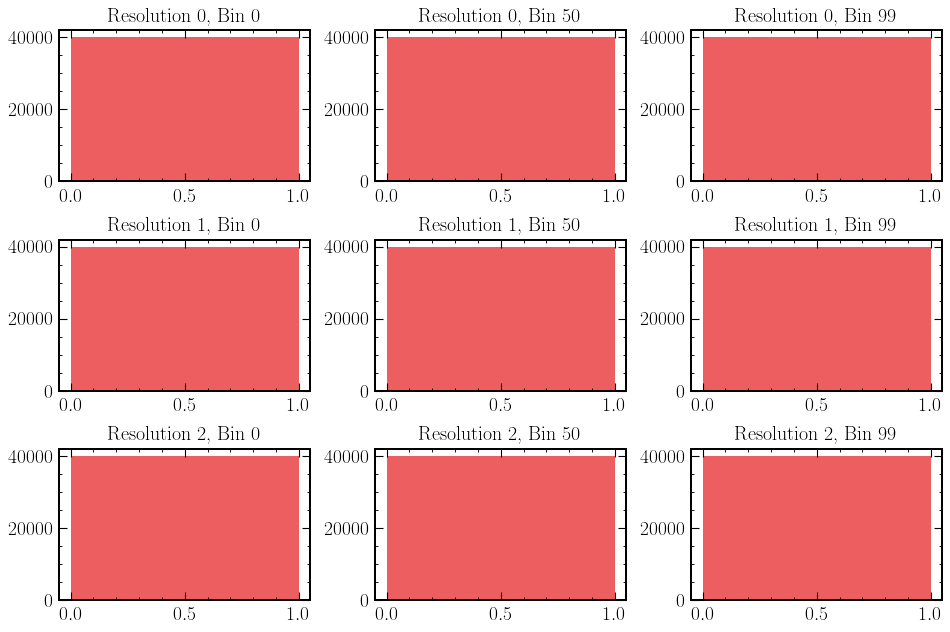

In [22]:
# p-values are uniformly distribute

selected_resolutions = [0, 1, 2]       # Resolutions to plot
selected_bins = [0, 50, 99]            # Bins to plot

fig, axs = plt.subplots(len(selected_resolutions), len(selected_bins), figsize=(12, 8))
for i, res in enumerate(selected_resolutions):
    for j, bin_idx in enumerate(selected_bins):
        pv_data = pv_bin_H0[:, res, bin_idx]
        axs[i, j].hist(pv_data, bins=50, alpha=0.7)
        axs[i, j].set_title(f'Resolution {res}, Bin {bin_idx}')

plt.tight_layout()
plt.show()

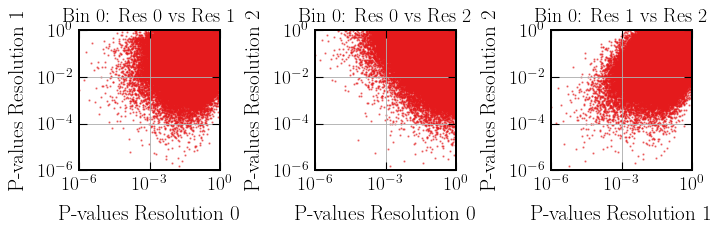

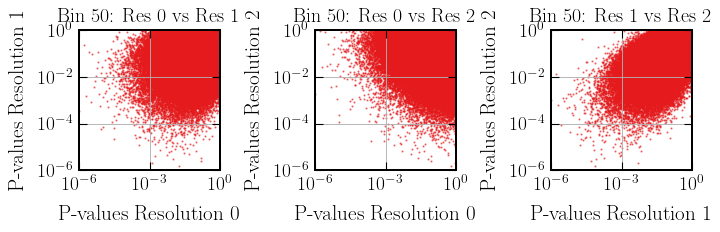

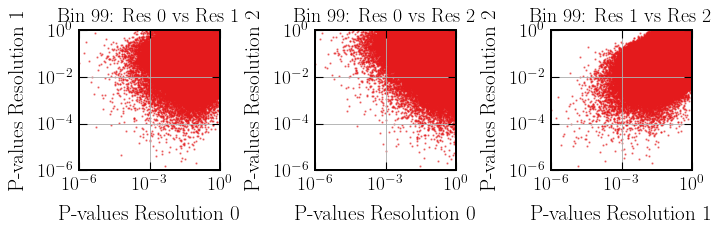

In [23]:
# p-values between different tests are correlated

bins_to_analyze = [0, 50, 99] 

for bin_idx in bins_to_analyze:
    fig, axs = plt.subplots(1, 3, figsize=(9, 3))
    resolution_pairs = [(0, 1), (0, 2), (1, 2)]
    for i, (res1, res2) in enumerate(resolution_pairs):
        p_values_res1 = pv_bin_H0[:, res1, bin_idx]
        p_values_res2 = pv_bin_H0[:, res2, bin_idx]

        axs[i].scatter(p_values_res1, p_values_res2, alpha=0.5, s=1)
        axs[i].set_xlabel(f'P-values Resolution {res1}')
        axs[i].set_ylabel(f'P-values Resolution {res2}')
        axs[i].set_title(f'Bin {bin_idx}: Res {res1} vs Res {res2}')
        axs[i].set_xlim(1e-6, 1)
        axs[i].set_ylim(1e-6, 1)
        axs[i].set_yscale('log')
        axs[i].set_xscale('log')
        axs[i].grid(True)

    plt.tight_layout()
    plt.show()


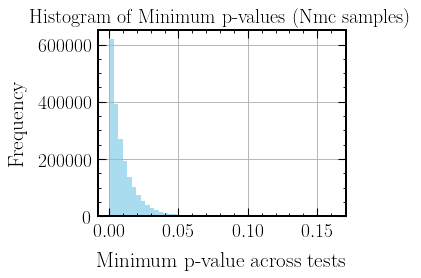

In [24]:
# MINIMUM

Nmc = pv_bin_H0.shape[0]
min_pv_bin_H0_epsilon = np.min(pv_bin_H0.reshape(Nmc, -1), axis=1)  # Shape: [Nmc]

plt.figure(figsize=(4, 3))
plt.hist(min_pv_bin_H0_epsilon, bins=50, alpha=0.7, color='skyblue')
plt.xlabel('Minimum p-value across tests')
plt.ylabel('Frequency')
plt.title('Histogram of Minimum p-values (Nmc samples)')
plt.grid(True)
plt.show()


Compute p-values for the total tests (3 for the correlation scales) and take them min

In [25]:
N_mc, num_resolutions = ts_sum_H0_epsilon .shape
means = ts_sum_H0_epsilon .mean(axis=0)  # Shape: [num_resolutions]
ts_centered = ts_sum_H0_epsilon  - means  # Shape: [N_mc, num_resolutions]
sorted_ts = np.sort(ts_centered, axis=0)  # Shape: [N_mc, num_resolutions]
ranks = np.argsort(np.argsort(-ts_centered, axis=0), axis=0)  # Ranks in descending order
p_values = (ranks + 1) / N_mc
pv_sum_H0 = p_values.reshape(N_mc, num_resolutions) 
pv_sum_H0.shape

(1999872, 3)

In [ ]:
selected_resolutions = [0, 1, 2]       # Resolutions to plot

fig, axs = plt.subplots(1, len(selected_resolutions), figsize=(9, 3))

for i, res in enumerate(selected_resolutions):
    pv_data = pv_bin_H0[:, res, bin_idx]
    axs[i].hist(pv_data, bins=50, alpha=0.7)
    axs[i].set_title(f'Resolution {res}')
    axs[i].set_yscale('log')
    axs[i].set_xscale('log')

plt.tight_layout()
plt.show()

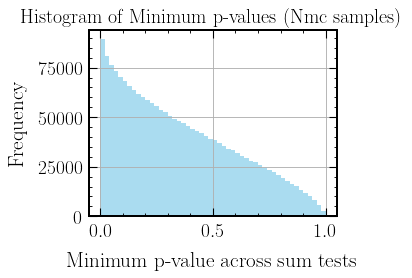

In [27]:
min_pv_sum_H0_epsilon = np.min(pv_sum_H0.reshape(Nmc, -1), axis=1)  # Shape: [Nmc]

plt.figure(figsize=(4, 3))
plt.hist(min_pv_sum_H0_epsilon, bins=50, alpha=0.7, color='skyblue')
plt.xlabel('Minimum p-value across sum tests')
plt.ylabel('Frequency')
plt.title('Histogram of Minimum p-values (Nmc samples)')
plt.grid(True)
plt.show()


Consider all tests

(1999872, 303)


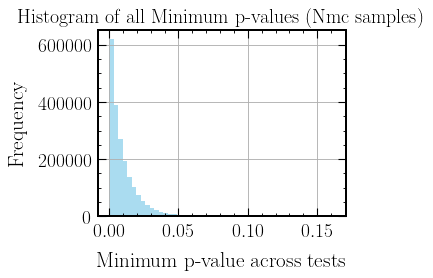

In [28]:
# MINIMUM

Nmc = pv_bin_H0.shape[0]
pv_all_H0 = np.concatenate([pv_bin_H0.reshape(Nmc, -1), pv_sum_H0], axis=1)  # Shape: [Nmc, num_resolutions * num_bins + num_resolutions]
print(pv_all_H0.shape)

min_pv_all_H0_epsilon = np.min(pv_all_H0, axis=1)  # Shape: [Nmc]

plt.figure(figsize=(4, 3))
plt.hist(min_pv_all_H0_epsilon, bins=50, alpha=0.7, color='skyblue')
plt.xlabel('Minimum p-value across tests')
plt.ylabel('Frequency')
plt.title('Histogram of all Minimum p-values (Nmc samples)')
plt.grid(True)
plt.show()


---

### Summary plot

In [29]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable
from cycler import cycler

mygold = (218/255, 165/255, 32/255, 0.1)  

def cax(ax, pad=0.05):
    divider = make_axes_locatable(ax)
    return divider.append_axes(position='top', size='5%', pad=pad)

In [30]:
def analyse_obs_epsilon(obs, i_c):
    
    target = obs['xi'][:, i_c].unsqueeze(1).expand(-1, len(simulator.correlation_scales), -1)

    # Evaluate epsilon and SNR^2 test statistic from NN
    epsilon_nn = network_epsilon.epsilon(target.cuda()).detach().cpu().numpy().squeeze(0)       #[len(correlation_scales), Nbins]
    variance_nn = network_epsilon.logvariance.exp().detach().cpu().numpy()                            #[len(correlation_scales), Nbins]
    snr2_nn = network_epsilon.snr(target.cuda()).detach().cpu().numpy().squeeze(0)**2            #[len(correlation_scales), Nbins]
    ts_sum_nn = snr2_nn.sum(axis=-1)-ts_sum_H0_epsilon_mean[0]
    p_sum_nn = np.stack([
        t_to_pvalue_empirical(ts_sum_nn[c], ts_sum_H0_epsilon [:, c]) for c in range(len(simulator.correlation_scales))
    ], axis=0)        #[len(correlation_scales)]

    # Compute p-values
    _p_nn = []
    for idx, ts_bin in enumerate(snr2_nn.T):
        ts_bin_i = ts_bin_H0_epsilon [:, :, idx]          #[N_mc, len(correlation_scales)]
        m = ts_bin_i.mean(0)                     #[len(correlation_scales)]
        ts0_ref = ts_bin_i - m                   #[N_mc, len(correlation_scales)]
        ts_obs = (ts_bin - m)
        _p_nn.append(np.stack([
            t_to_pvalue_empirical(ts_obs[c], ts0_ref[:, c]) for c in range(len(simulator.correlation_scales))
        ], axis=0))        #[len(correlation_scales)]
    p_nn = np.array(_p_nn)                   #[Nbins, len(correlation_scales)]

    # Compute global p-values
    obs_min_pv_bin = p_nn.reshape(-1).min()
    obs_min_pv_sum = p_sum_nn.reshape(-1).min()
    pv_all_obs = np.concatenate([
        p_nn.reshape(-1),  # Shape: [num_resolutions * Nbins]
        p_sum_nn  # Shape: [num_resolutions]
    ], axis=0)  # Combined shape: [num_total_tests]
    obs_min_pv_all = pv_all_obs.min()

    p_glob_bin = np.mean(min_pv_bin_H0_epsilon <= obs_min_pv_bin)
    p_glob_sum = np.mean(min_pv_sum_H0_epsilon <= obs_min_pv_sum)
    p_glob_all = np.mean(min_pv_all_H0_epsilon <= obs_min_pv_all)

    return epsilon_nn, variance_nn, snr2_nn, p_nn, p_sum_nn, p_glob_all


def plot_analysis_epsilon(obs, epsilon_nn, variance_nn, p_nn, p_sum_nn, p_glob_all, i_c, ax_dist=True):
    
    dist1 = obs['xi'] - obs['x0']

    # Figure
    fig = plt.figure(figsize=(10, 8), dpi=250)
    gs = plt.GridSpec(3, 2, figure=fig, height_ratios=[1, 1, 1], width_ratios=[2, 1], hspace=0.3, wspace=0.3)

    # First row: ax1 spans both columns
    ax1 = fig.add_subplot(gs[0, 0])
    xi = obs['xi'][0, i_c]
    # ax1.plot(grid, obs['mu'][0], color='k', label="$\mu_{\mathrm{sim}}$")
    ax1.scatter(grid, xi, color='k', marker='x', s=8)
    ax1.plot(grid, dist1[0, i_c], color=mycolors[i_c], label="$\mu_{\mathrm{dist B}}$")
    ax1.fill_between(grid, 0,  dist1[0, i_c], color=mycolors[i_c], alpha=0.5)
    ax1.set_ylabel("$x_\mathrm{obs}$", labelpad=1.5)
    # ax1.plot([], [], c='k', label="$x_\mathrm{obs}$")
    # ax1.legend(loc='best', handlelength=1)
    # ax1.set_xticklabels([])
    ax1.set_ylim(-6.5, 6.5)
    # ax1.set_xlabel("$i$", labelpad=1.5)
    ax1.legend(bbox_to_anchor=(0.02, .33), fontsize=13, loc='upper left', labelspacing=0.1)
    ax1.set_xticks([])
    ax1.set_title("Data")

    if ax_dist:
        ax_dist = fig.add_subplot(gs[0, 1])
        mask = np.where(dist1[0,-1]!=0)
        fakegrid = torch.linspace(0, len(mask[0]), len(mask[0]))
        ax_dist.plot(fakegrid, dist1[0,0][mask]/dist1[0,0][mask].max()+2, c=mycolors[0])
        ax_dist.plot(fakegrid, dist1[0,1][mask]/dist1[0,1][mask].max(), c=mycolors[1])
        ax_dist.plot(fakegrid, dist1[0,2][mask]/dist1[0,2][mask].max()-2, c=mycolors[2])
        ax_dist.text(fakegrid.max() + 3, 2, 'A', verticalalignment='center')
        ax_dist.text(fakegrid.max() + 3, 0, 'B', verticalalignment='center')
        ax_dist.text(fakegrid.max() + 3, -2, 'C', verticalalignment='center')
        ax_dist.axis('off')
        ax_dist.set_ylim(-5,5)
        ax_dist.set_xlim(-len(mask[0]),2*len(mask[0]))
        ax_dist.set_title("Distortions")

    # Second column: ax2 and ax3 in the first column
    ax2 = fig.add_subplot(gs[1, 0])
    for ccc, _ in enumerate(mycolors):
        ax2.semilogy(grid, p_nn[:, ccc], c=mycolors[ccc])
    ax2.set_ylabel("$\mathrm{p}_\mathrm{obs}$", labelpad=1.5)
    ax2.legend(loc='lower right',  fontsize=15)
    ax2.set_ylim(1/(N_mc*5), 1)
    ax2.set_title("Anomaly detection")
    ax2.set_xticks([])
    ax2.yaxis.set_major_locator(ticker.LogLocator(base=10.0, numticks=10))
    ax2.yaxis.set_minor_locator(ticker.NullLocator())
    ax2.grid(True, axis='y', which='major')
    ax2.set_yticks([1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6])  # Specify tick positions
    ax2.set_yticklabels([r"$10^{-1}$", None , r"$10^{-3}$", None, r"$10^{-5}$", None])  # Customize tick labels

    ax3 = fig.add_subplot(gs[2, 0])
    for ccc, _ in enumerate(mycolors):
        ax3.plot(grid, epsilon_nn.T[:,ccc], c=mycolors[ccc])
    ax3.set_ylabel(r"$\epsilon_\mathrm{obs}$")
    ax3.legend(loc='best',  fontsize=13)
    ax3.axhline(0, color='#b0b0b0', ls='--', lw=1)
    ax3.set_title("Residual analysis")
    ax3.set_ylim(-6.5, 6.5)
    ax3.set_xticks([])


    # Second column: ax4 and ax6 in the second column

    # Bars
    ax4 = fig.add_subplot(gs[1, 1])
    ax4.set_yscale('log')
    ax4.set_ylim(1/(N_mc*5), 1)
    ax4.set_xticks([0, 1, 2])
    ax4.set_xticklabels(["A", "B","C"])
    ax4.set_xlim(-0.5, 3 - 0.5)
    ax4.set_ylabel("$\mathrm{p}_\mathrm{sum}$")
    ax4.grid(True, axis='y', which='both')
    for x, value_nn in zip([0, 1, 2], p_sum_nn):
        left = x - 0.5 / 2
        right = x + 0.5 / 2
        ax4.fill_between([left, right], 1, value_nn, facecolor=mycolors[x], edgecolor=mycolors[x])
    ax4.set_title("Model validation")
    ax4.tick_params(axis="x",direction="in", pad=-25)
    ax4.minorticks_off()
    ax4.yaxis.set_major_locator(ticker.LogLocator(base=10.0, numticks=10))
    ax4.yaxis.set_minor_locator(ticker.NullLocator())
    ax4.grid(True, axis='y', which='major')
    ax4.set_yticks([1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6])  # Specify tick positions
    ax4.set_yticklabels([r"$10^{-1}$", None , r"$10^{-3}$", None, r"$10^{-5}$", None])  # Customize tick labels

    # Hist
    ax6 = fig.add_subplot(gs[2, 1])
    bins = np.linspace(-5, 5, int(Nbins/5))
    for x in range(len(correlation_scales)):
        ax6.hist(epsilon_nn[x] / np.sqrt(variance_nn[x]), bins=bins, density=True, histtype='stepfilled', lw=1.5, color=mycolors[x], alpha=0.2)
        ax6.hist(epsilon_nn[x] / np.sqrt(variance_nn[x]), bins=bins, density=True, histtype='step', lw=1.5, ec=mycolors[x])
    ax6.set_xlim(-5, 5)
    ax6.set_xlabel("$\epsilon_\mathrm{obs} / \sigma$")
    ax6.set_title("Residual variance analysis")

    # Add on gs[0, 1] text reporting the three global p-values
    mantissa, exp = ('%.2e' % p_glob_all).split('e')
    exp = int(exp)
    textstr = r'$\mathrm{p}_{\mathrm{glob}}= %s \times 10^{%d}$' % (mantissa, exp)
    ax3.text(0.6, -0.4, textstr, transform=ax3.transAxes, fontsize=14,
                verticalalignment='center', horizontalalignment='center',
                bbox=dict(
                    facecolor=mygold,
                    edgecolor='none'  # Remove the border if not needed
                )
            )
    ax3.text(0.2, -0.4, "Global p-value", transform=ax3.transAxes, fontsize=18,
                verticalalignment='center', horizontalalignment='center')

/scratch-local/noemiam.8976036/ipykernel_2697282/3458657871.py:87: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax2.legend(loc='lower right',  fontsize=15)
/scratch-local/noemiam.8976036/ipykernel_2697282/3458657871.py:101: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax3.legend(loc='best',  fontsize=13)


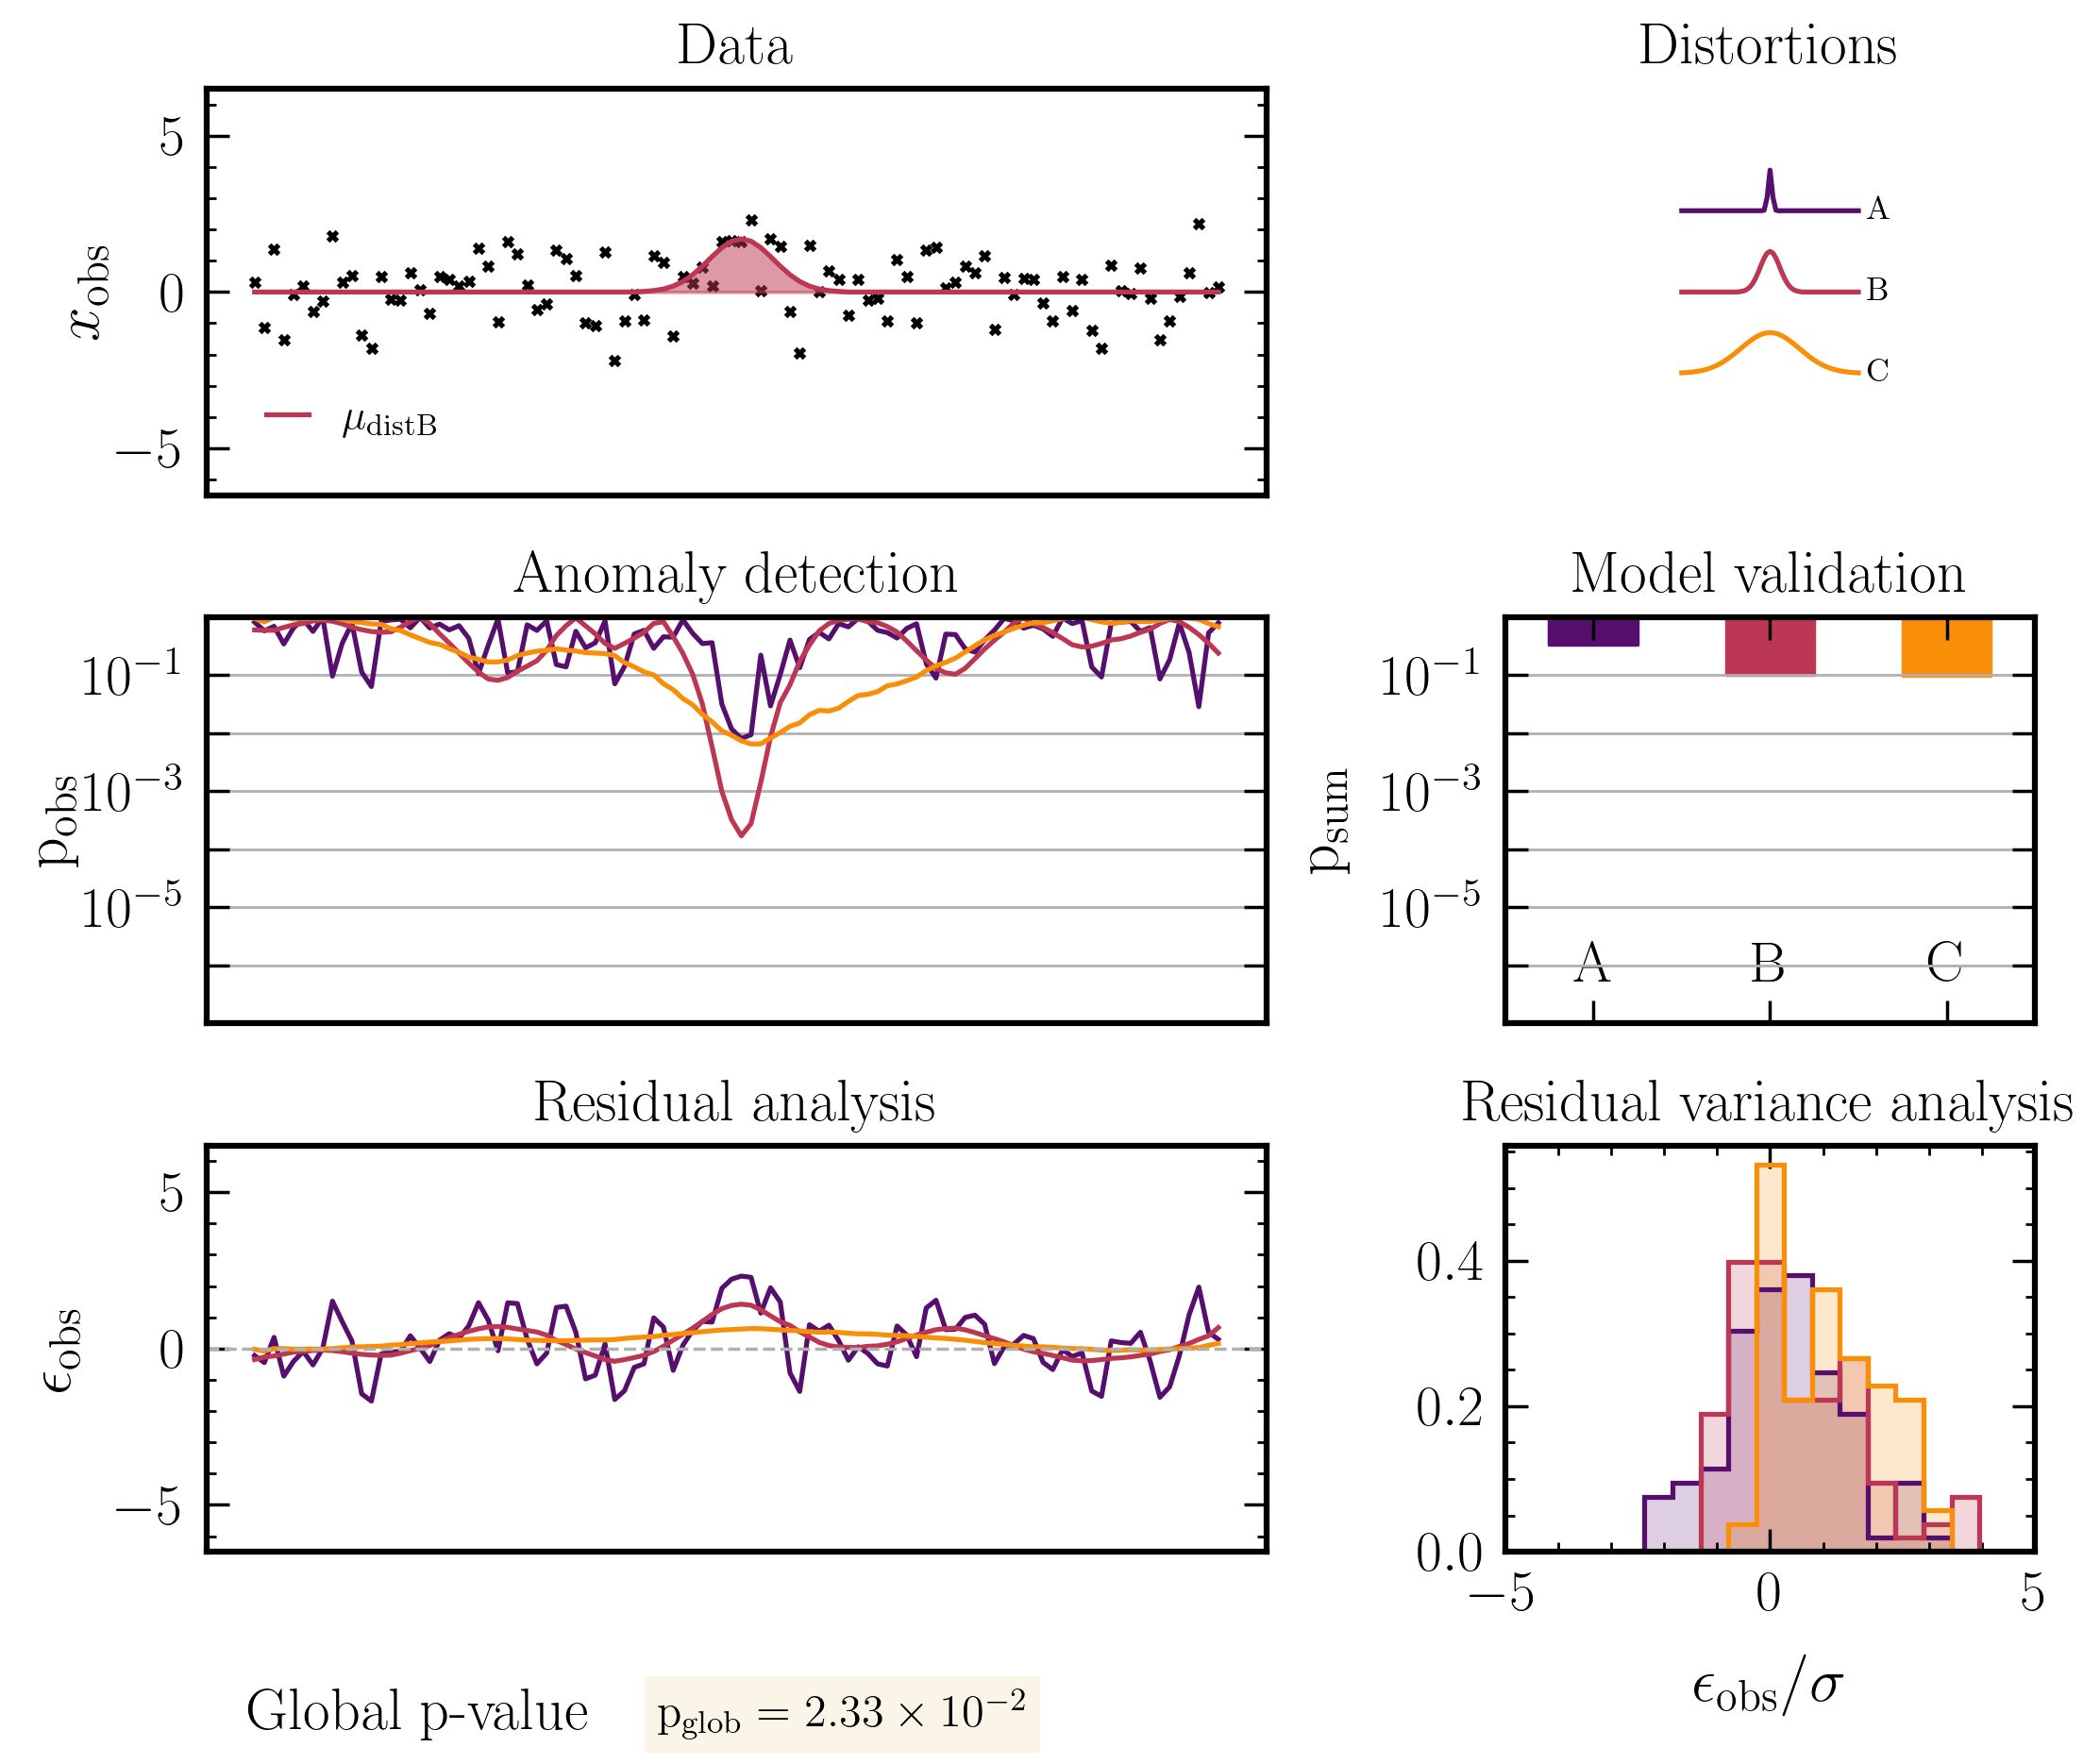

In [32]:
simulator = Simulator_Additive_Correlated(
    Nbins=Nbins, sigma=SIGMA, bounds=bounds, fraction=None, bkg=False,
    correlation_scales = correlation_scales,
    dtype=torch.float32, device='cpu'
    )     

for nn in range(1):
    i_c = 1
    # Choose clear distortion
    obs = simulator.sample(1)
    obs['ni'][obs['ni']==1] = 0
    obs['ni'][0, 50] = 1
    obs['epsilon'] = obs['ni'].unsqueeze(1) * torch.tensor([1.7, 1.7, 1.7]).unsqueeze(0).unsqueeze(2)
    obs['cni'] = simulator.get_correlation(obs['ni'],  obs['epsilon'])
    obs['xi'] = simulator.get_x_Hi(obs['cni'], obs['x0'].unsqueeze(1))

    epsilon_nn, variance_nn, snr2_nn, p_nn, p_sum_nn, p_glob_all = analyse_obs_epsilon(obs, i_c)
    plot_analysis_epsilon(obs, epsilon_nn, variance_nn, p_nn, p_sum_nn, p_glob_all, i_c, ax_dist=True)
    # plt.savefig(f"./figs/obs_SNR_1_{nn}.pdf", transparent=True, dpi=300)
    # torch.save(obs, f"./figs/obs_SNR_1_{nn}.pt")

/scratch-local/noemiam.8976036/ipykernel_2697282/3458657871.py:87: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax2.legend(loc='lower right',  fontsize=15)
/scratch-local/noemiam.8976036/ipykernel_2697282/3458657871.py:101: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax3.legend(loc='best',  fontsize=13)


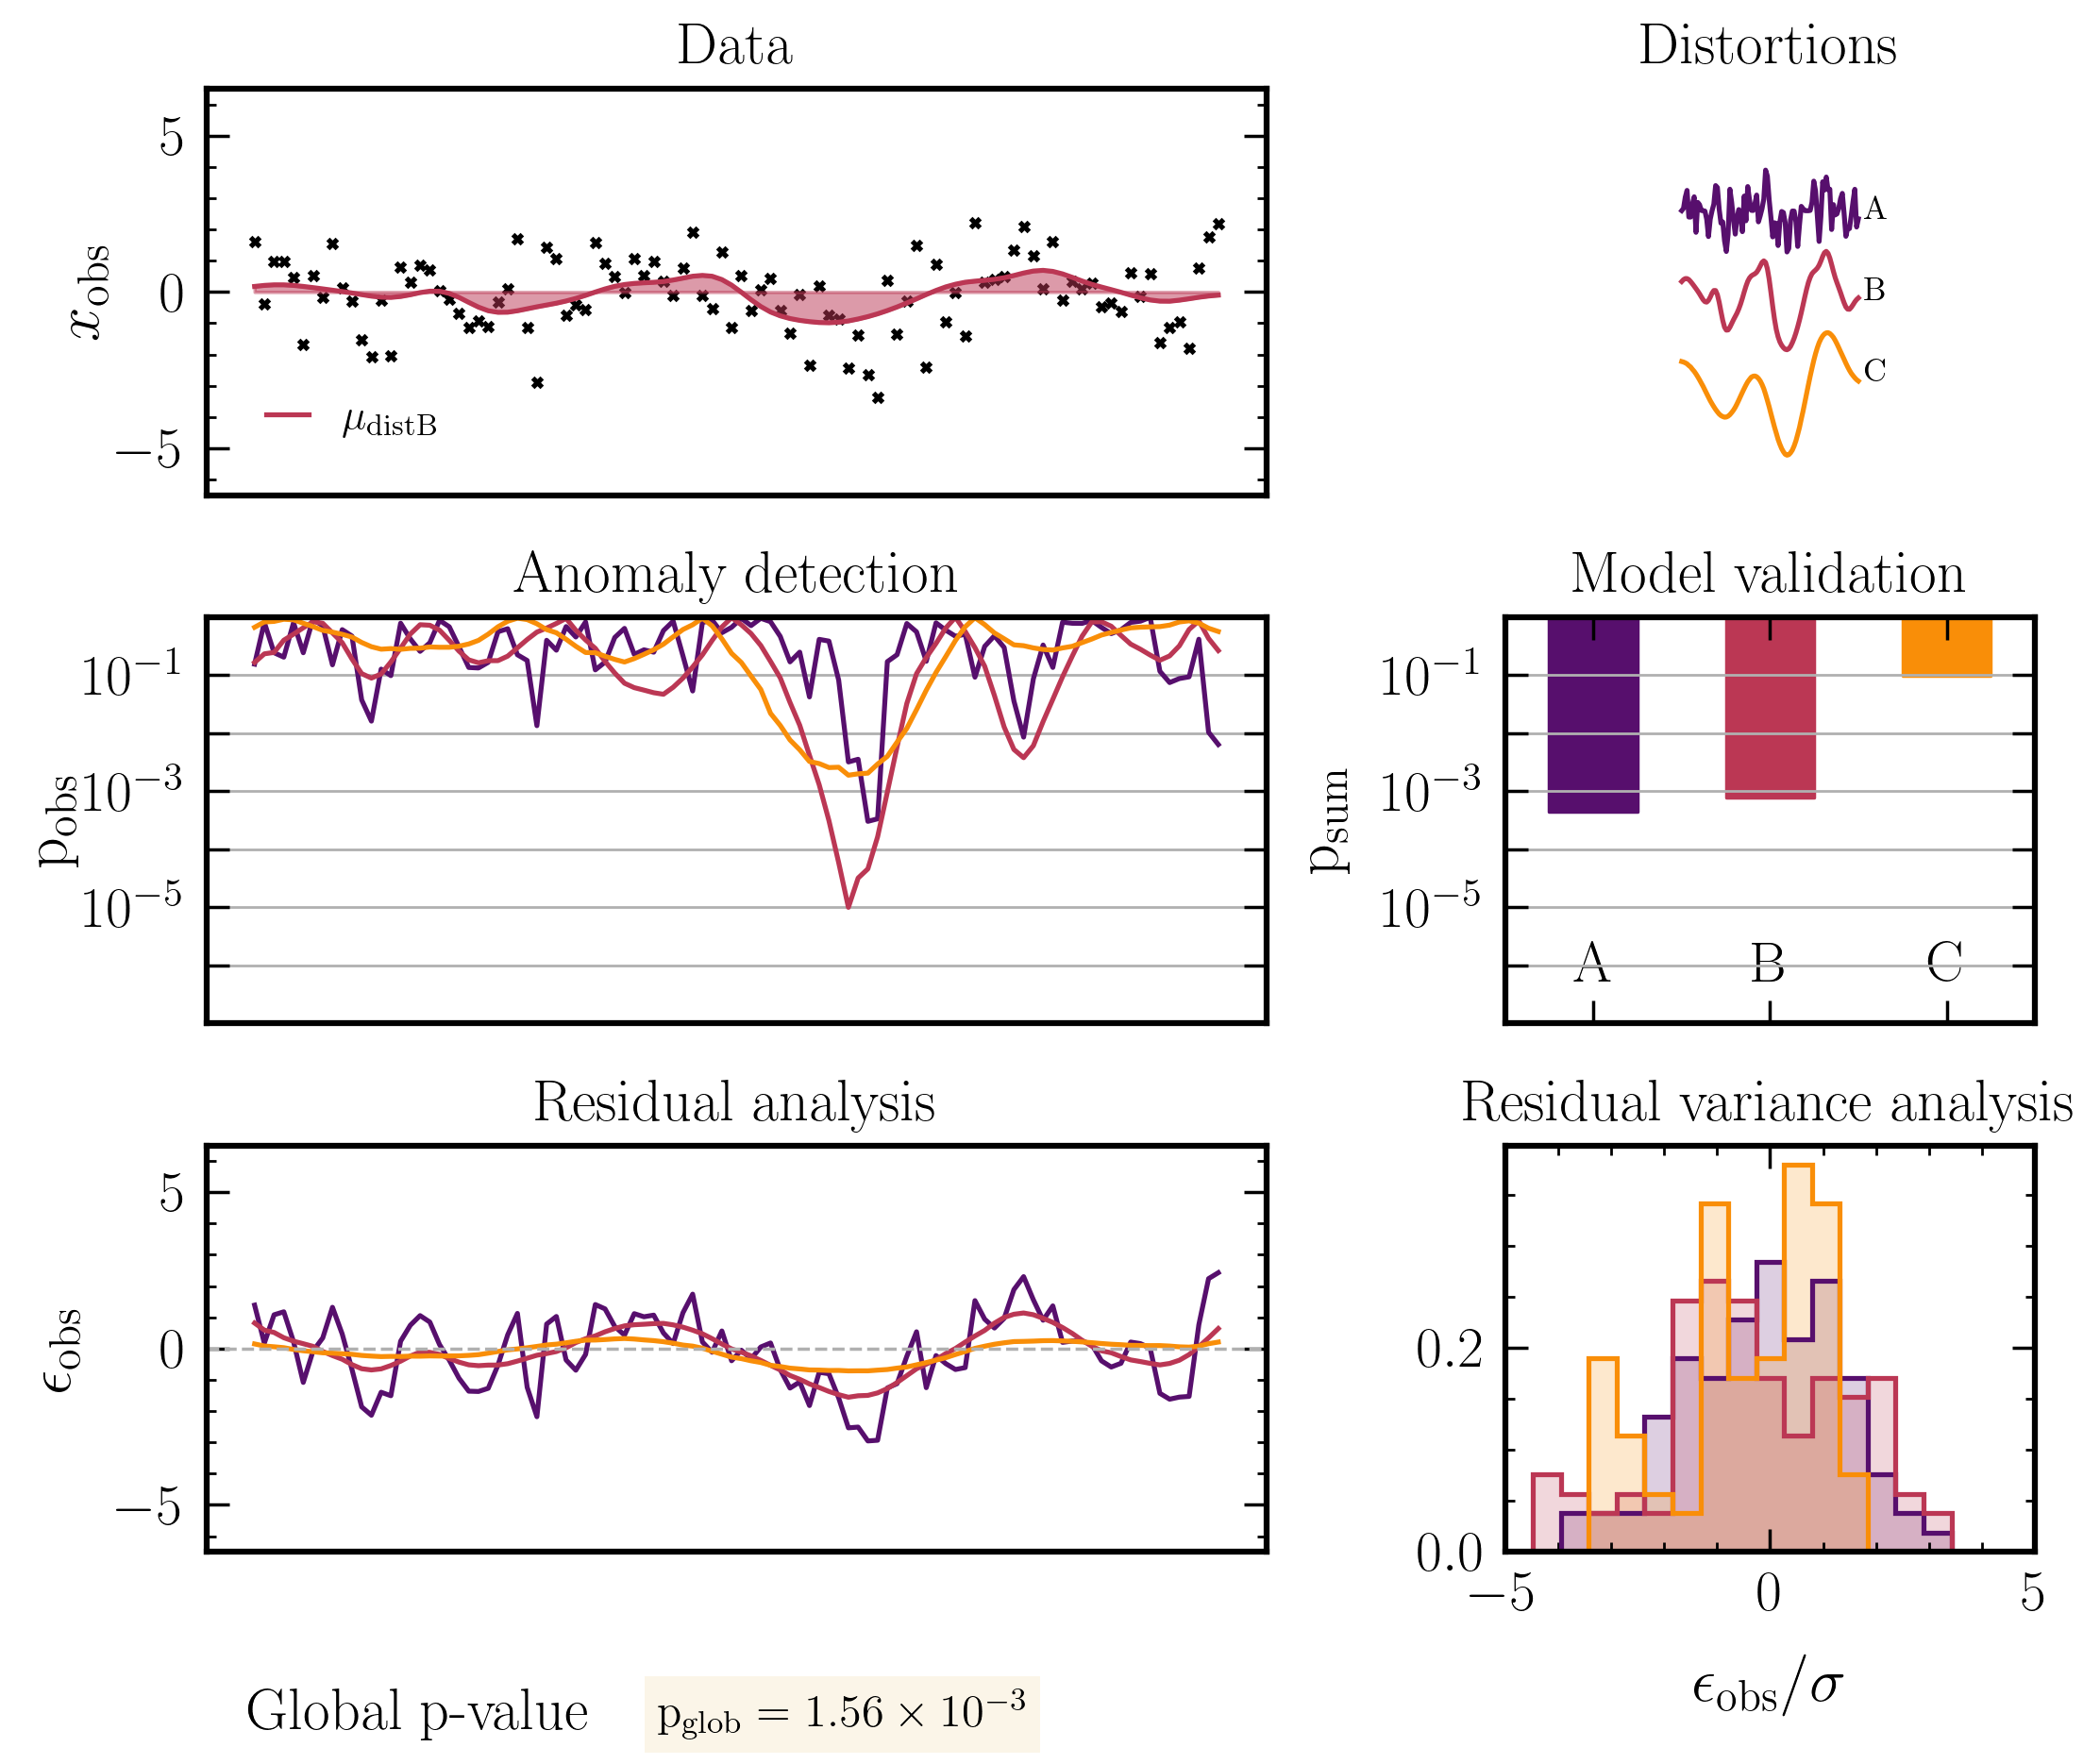

In [33]:
simulator1 = Simulator_Additive_Correlated(
    Nbins=Nbins, sigma=SIGMA, bounds=torch.tensor([.45, .45, .45]), fraction=0.6, sample_fraction=False, 
    correlation_scales = correlation_scales, bkg=False, 
    dtype=torch.float32, device='cpu'
    )    
obs = simulator1.sample(1) 
i_c = 1
epsilon_nn, variance_nn, snr2_nn, p_nn, p_sum_nn, p_glob_all = analyse_obs_epsilon(obs, i_c)
plot_analysis_epsilon(obs, epsilon_nn, variance_nn, p_nn, p_sum_nn, p_glob_all, i_c, ax_dist=True)

## Training BCE

In [34]:
from models.online_norm import OnlineStandardizingLayer
from models.unet_1d import UNet1d 
from models.resnet_1d import ResidualNet 


class network_BCE(torch.nn.Module):
    def __init__(self, correlation_scales):
        super().__init__()
        
        self.correlation_scales = correlation_scales
        self.online_norm = OnlineStandardizingLayer((len(correlation_scales), Nbins,), use_average_std=True)    
        self.logvariance = torch.nn.Parameter(torch.ones(len(correlation_scales), Nbins) * 5) # Initialize to big value
        
        self.kernel_sizes = torch.tensor([3, 5, 7]) #correlation_scales + (correlation_scales % 2 == 0).int()  
        self.paddings = (self.kernel_sizes - 1)// 2 
        self.net = torch.nn.ModuleList(
                [UNet1d(1, 1, sizes=(8, 16, 32, 64, 128)) for i in range(len(correlation_scales))]
        )
                                
    def forward(self, x):
        
        data = x['x']
        data = self.online_norm(data)
        data = [
            self.net[i](data[:, i, :].unsqueeze(1)).squeeze(1) for i in range(len(self.correlation_scales))
        ]
        data = torch.stack(data, 1)
        x['ni'] = x['ni'].unsqueeze(1).repeat(1, data.shape[1], 1)
        return data

In [35]:
# Train
def resample(sample):
    sample = simulator._resample(sample)
    sample['x'] = sample['xi']
    sample = {k: v[0] for k, v in sample.items()}
    return sample

batch_size = 128
# dm = StoredDataModule(samples, batch_size=batch_size, on_after_load_sample=resample)
dm = OnTheFlyDataModule(simulator, Nsims_per_epoch=400*batch_size, batch_size=batch_size)
network_BCE = network_BCE(correlation_scales)
model = BCELossModule(network_BCE, learning_rate=2e-3)
trainer = pl.Trainer(
    accelerator="gpu", 
    max_epochs=100, 
    precision=32,
    # fast_dev_run=True
)
trainer.fit(model, dm)
network_BCE.cuda().eval();

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores


HPU available: False, using: 0 HPUs
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: ModelCheckpoint
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/noemiam/.pyenv/versions/3.9.16/envs/sbitest/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name  | Type        | Params | Mode 
----------------------------------------------
0 | model | network_BCE | 544 K  | train
----------------------------------------------
544 K     Trainable params
0         Non-trainable params
544 K     Total params
2.177     Total estimated model params size (MB)
294       Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/noemiam/.pyenv/versions/3.9.16/envs/sbitest/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=17` in the `DataLoader` to improve performance.
/home/noemiam/.pyenv/versions/3.9.16/envs/sbitest/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=17` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved. New best score: 0.961


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.032 >= min_delta = 0.0. New best score: 0.929


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.924


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.924


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.917


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.915


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.915


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.914


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.913


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.911


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.911


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.909


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.908


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.906


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.906


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.905


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.905


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.905


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.905


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.904


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.904


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.904


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.904


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.904


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.904


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Monitored metric val_loss did not improve in the last 7 records. Best score: 0.904. Signaling Trainer to stop.


Reloading best model: /gpfs/home6/noemiam/gofish/lightning_logs/version_1/checkpoints/epoch=70-val_loss=0.90.ckpt


/gpfs/home6/noemiam/gofish/utils/module.py:147: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(self.best_model_path)


In [36]:
# checkpoint = torch.load("/home/noemiam/sbi/gofish/notebooks/lightning_logs/version_38/checkpoints/epoch=47-val_loss=0.89.ckpt")
# state_dict = checkpoint['state_dict']
# new_state_dict = {}
# for key in state_dict:
#     new_key = key.replace('model.', '')  # Remove 'model.' prefix
#     new_state_dict[new_key] = state_dict[key]
    
# network_BCE.load_state_dict(new_state_dict)
# network_BCE.cuda().double().eval();

---

## Evaluate

Define test statistic

$TS(x) = - 2 \log\frac{p(x|H_0)}{p(x|H_1)} = 2 f_\phi(x)$

In [37]:
def ts_sbi(x: dict, model: int =0):
    # x = dict_to_double(x)
    x = dict_to_cuda(x)
    
    # Test statistic given 0 or 1
    if 'x' not in x.keys():
        if model == 0:
            x['x'] = x['x0'].unsqueeze(-2).expand(-1, len(simulator.correlation_scales), Nbins)
        elif model == 1:
            x['x'] = x['xi'] 

    # Test statistic
    t = 2 * (network_BCE(x).detach().cpu().squeeze(0).numpy())
    
    # Go back to cpu 
    x = dict_to_cpu(x)
    return t

---

#### Monte-Carlo H0

$$
    t_i(\mathbf x) \propto \text{SNR}_i^2(\bm x)  
$$

In [38]:
N_mc = 2e6

# if os.path.exists("ts_bin_H0_2.npy"):
#     ts_bin_H0 = np.load("ts_bin_H0_2.npy")
# else:
batch_size = 2048*2
N_batch = int(N_mc / batch_size)
ts_bin_H0_BCE = []
for _ in tqdm(range(N_batch)):
    mc_samples = simulator.sample(batch_size)
    ts_bin_H0_BCE.append(ts_sbi(mc_samples, model=0))
ts_bin_H0_BCE = np.concatenate(ts_bin_H0_BCE)
# np.save("ts_bin_H0_2.npy", ts_bin_H0)

ts_bin_H0_BCE.shape

  0%|          | 0/488 [00:00<?, ?it/s]

100%|██████████| 488/488 [00:14<00:00, 32.68it/s]


(1998848, 3, 100)

Histogram of $t_i | H_0$ in individual bins

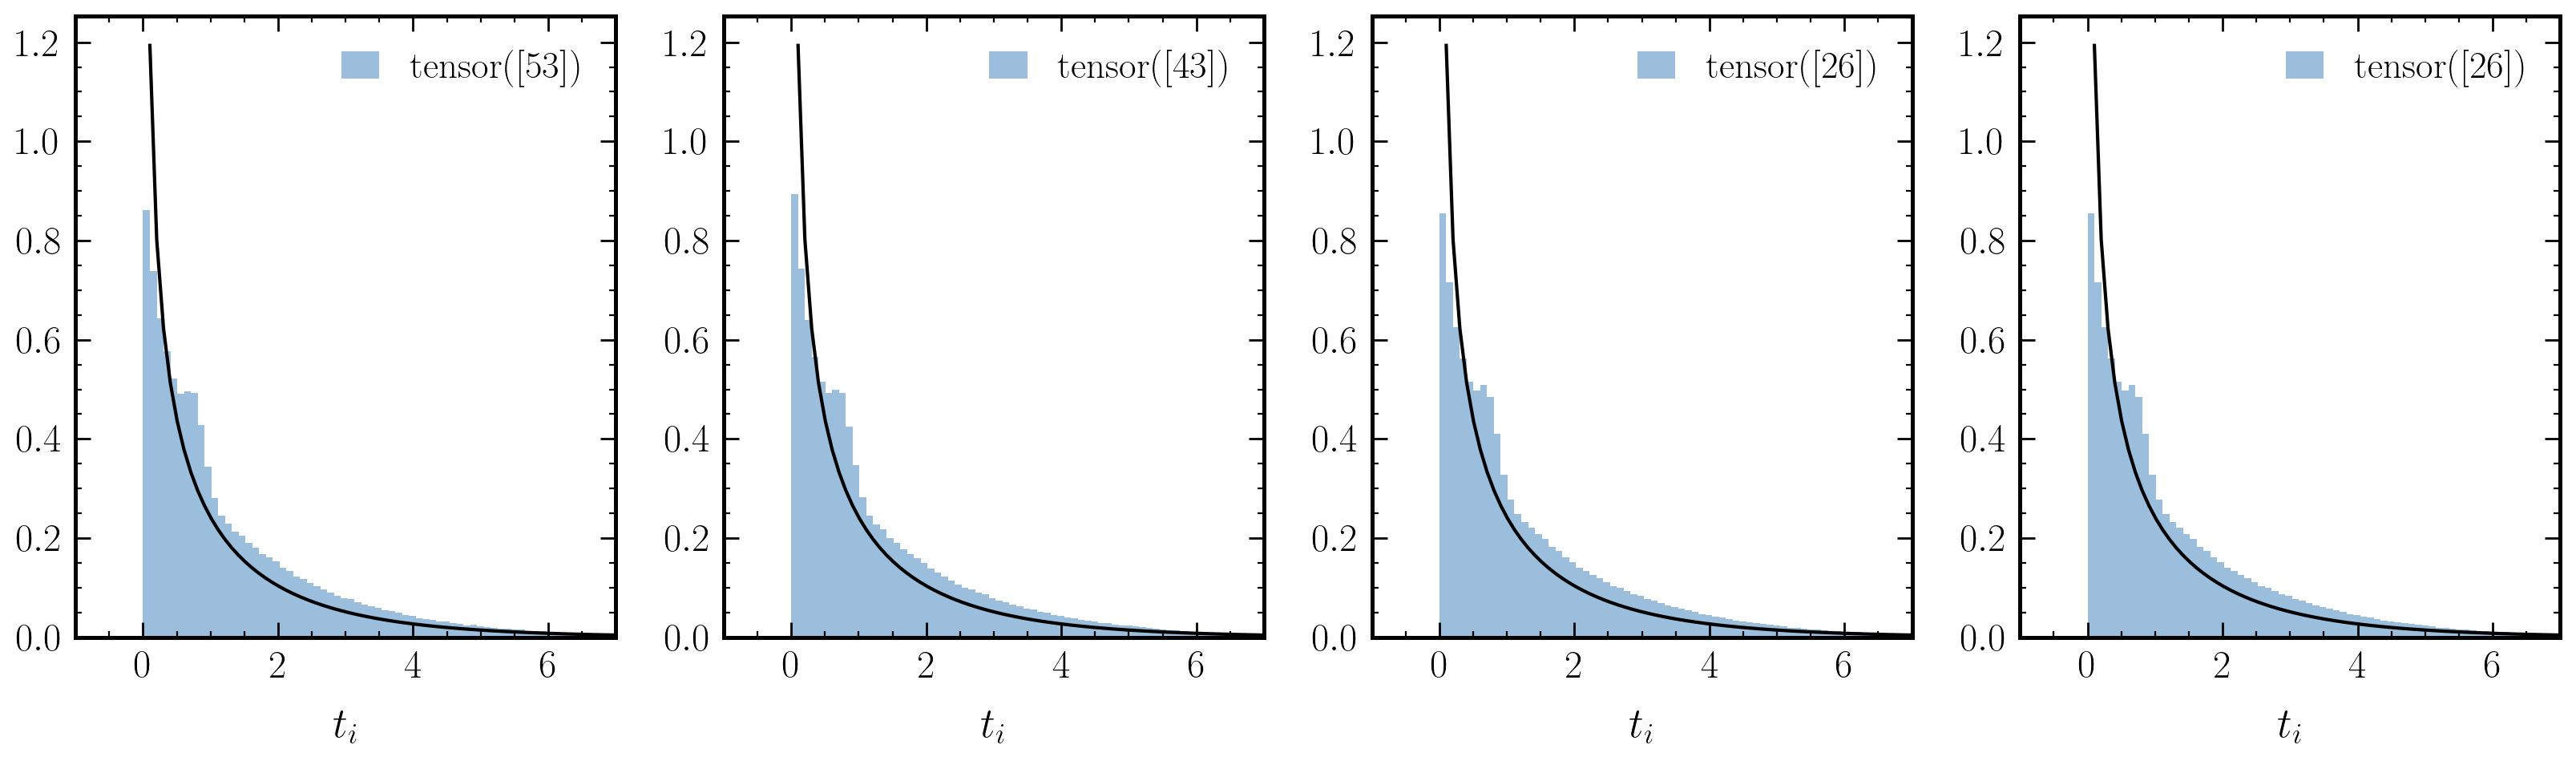

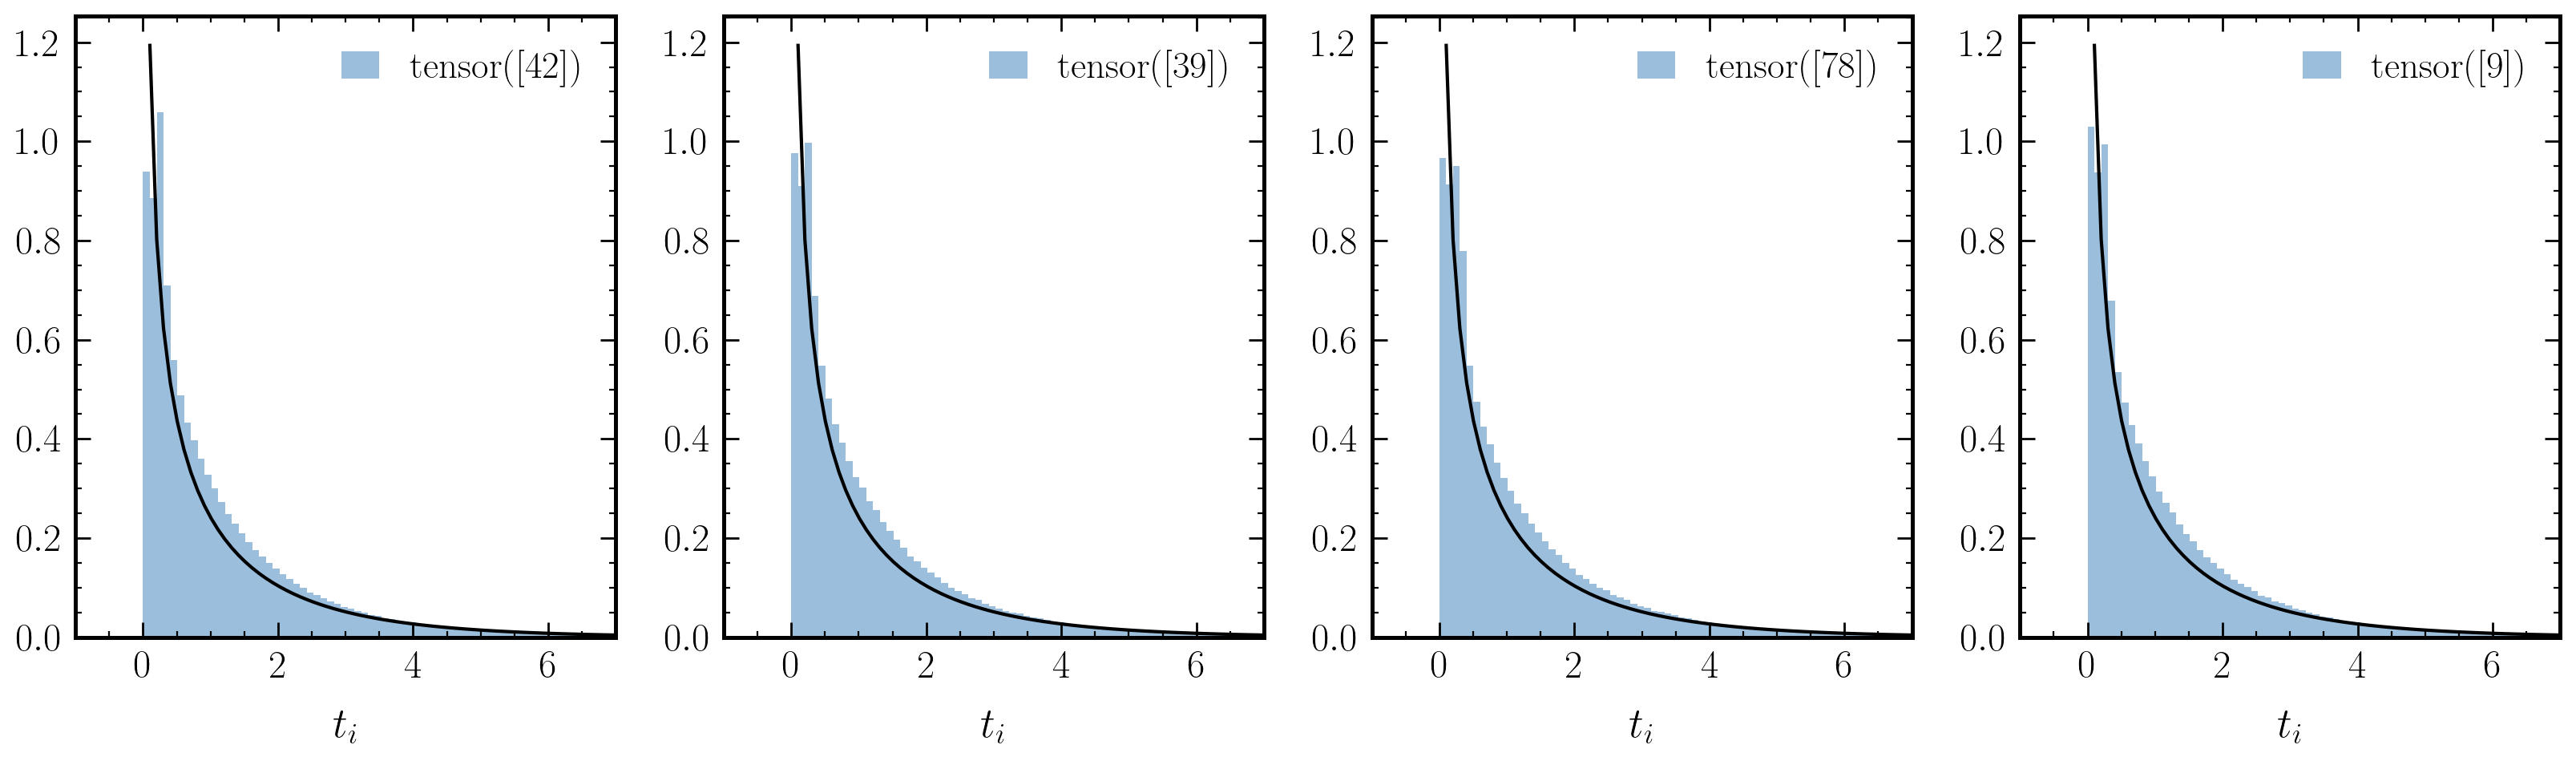

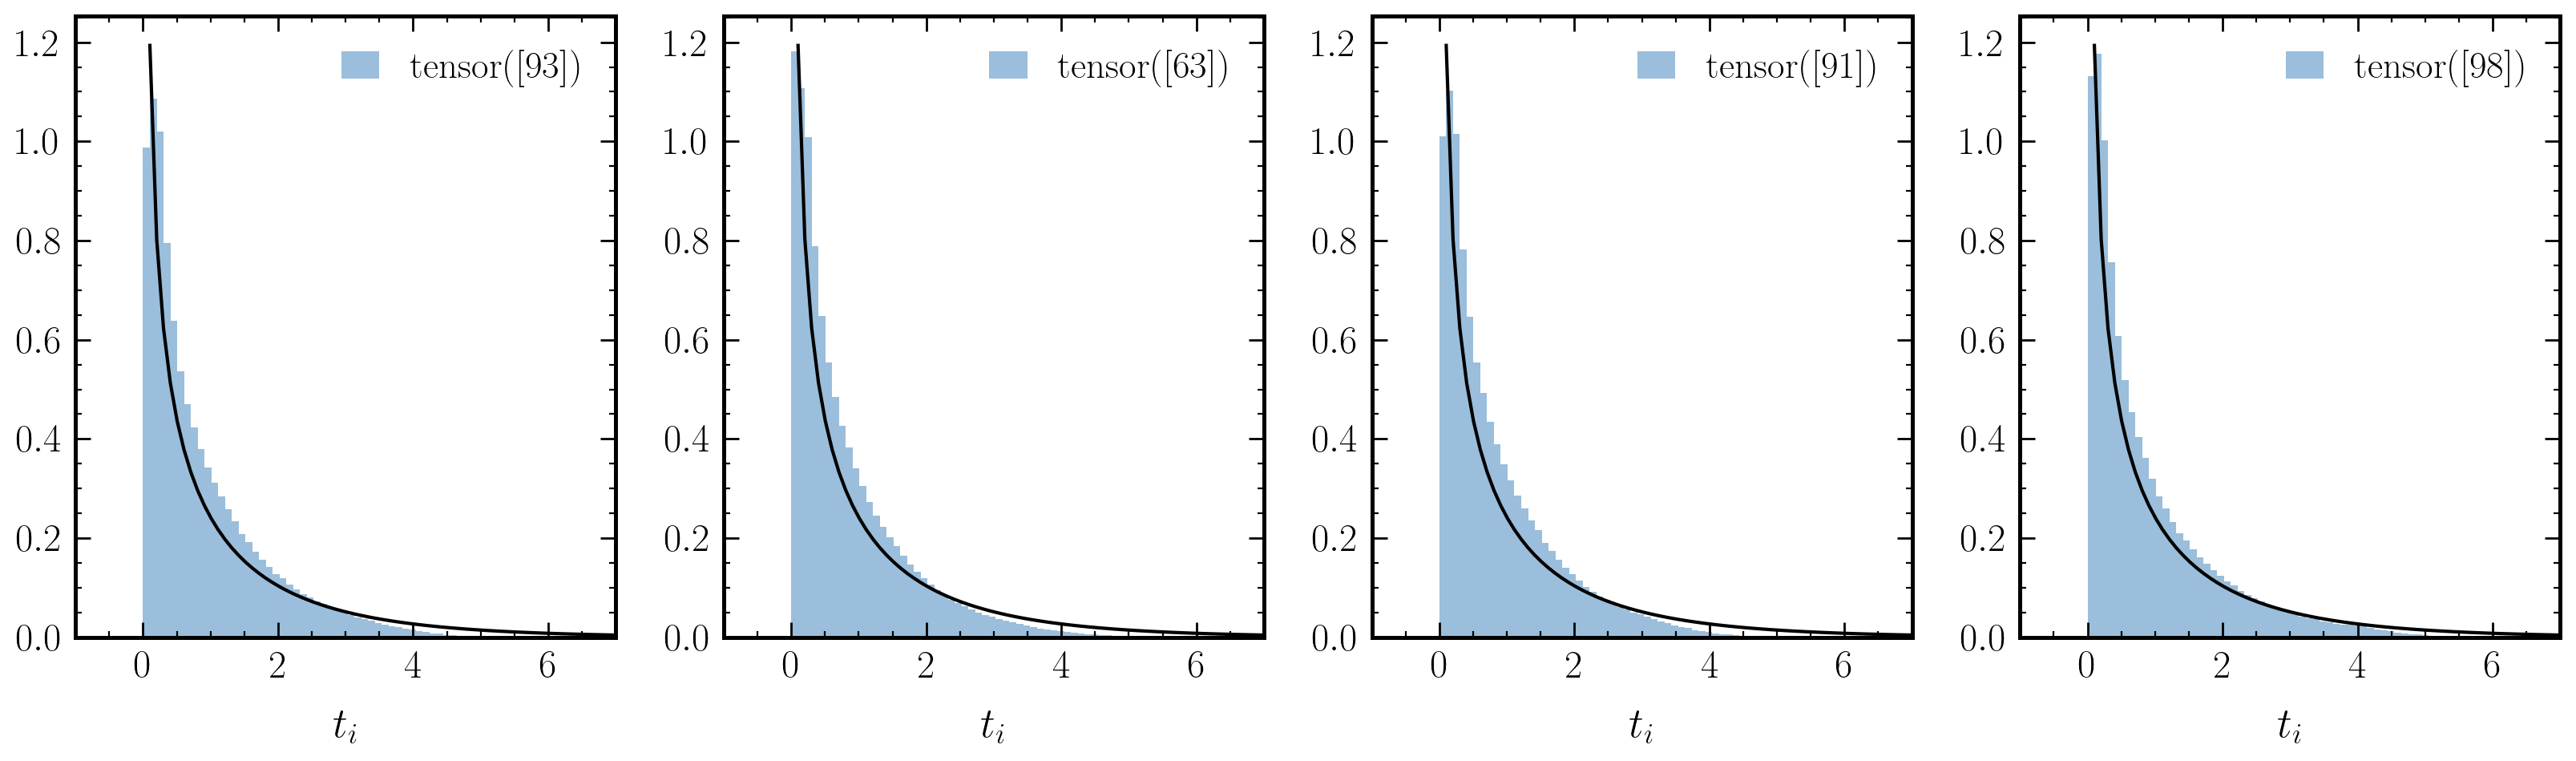

In [39]:
# Compare with chi2 with df = 1 ?
grid = np.linspace(0, 10, 100) # 1 df, adjust
chi2 = scipy.stats.chi2.pdf(grid, df=1, loc=0)

for idx_c in range(len(correlation_scales)):
    fig, axs = plt.subplots(1, 4, figsize=(20, 5), dpi=200)
    for i in range(4):
        bin = torch.randint(Nbins, (1,))
        ts_bin_i = ts_bin_H0_BCE[:, idx_c, bin]
        m = ts_bin_i.mean()

        bins = np.linspace(0, 10, 100)
        axs[i].hist(ts_bin_i-m, bins=bins, density=True, color='C1', alpha=0.5, label=f'{bin}')
        
        axs[i].set_xlabel('$t_i$')
        axs[i].set_xlim(-1, 7)
        axs[i].plot(grid, chi2, c='k')
        axs[i].legend();
    plt.show()

---

### Individual deviations test

- Localized $t_i$
- Localized $\mathrm{p}_i$ for anomaly detection

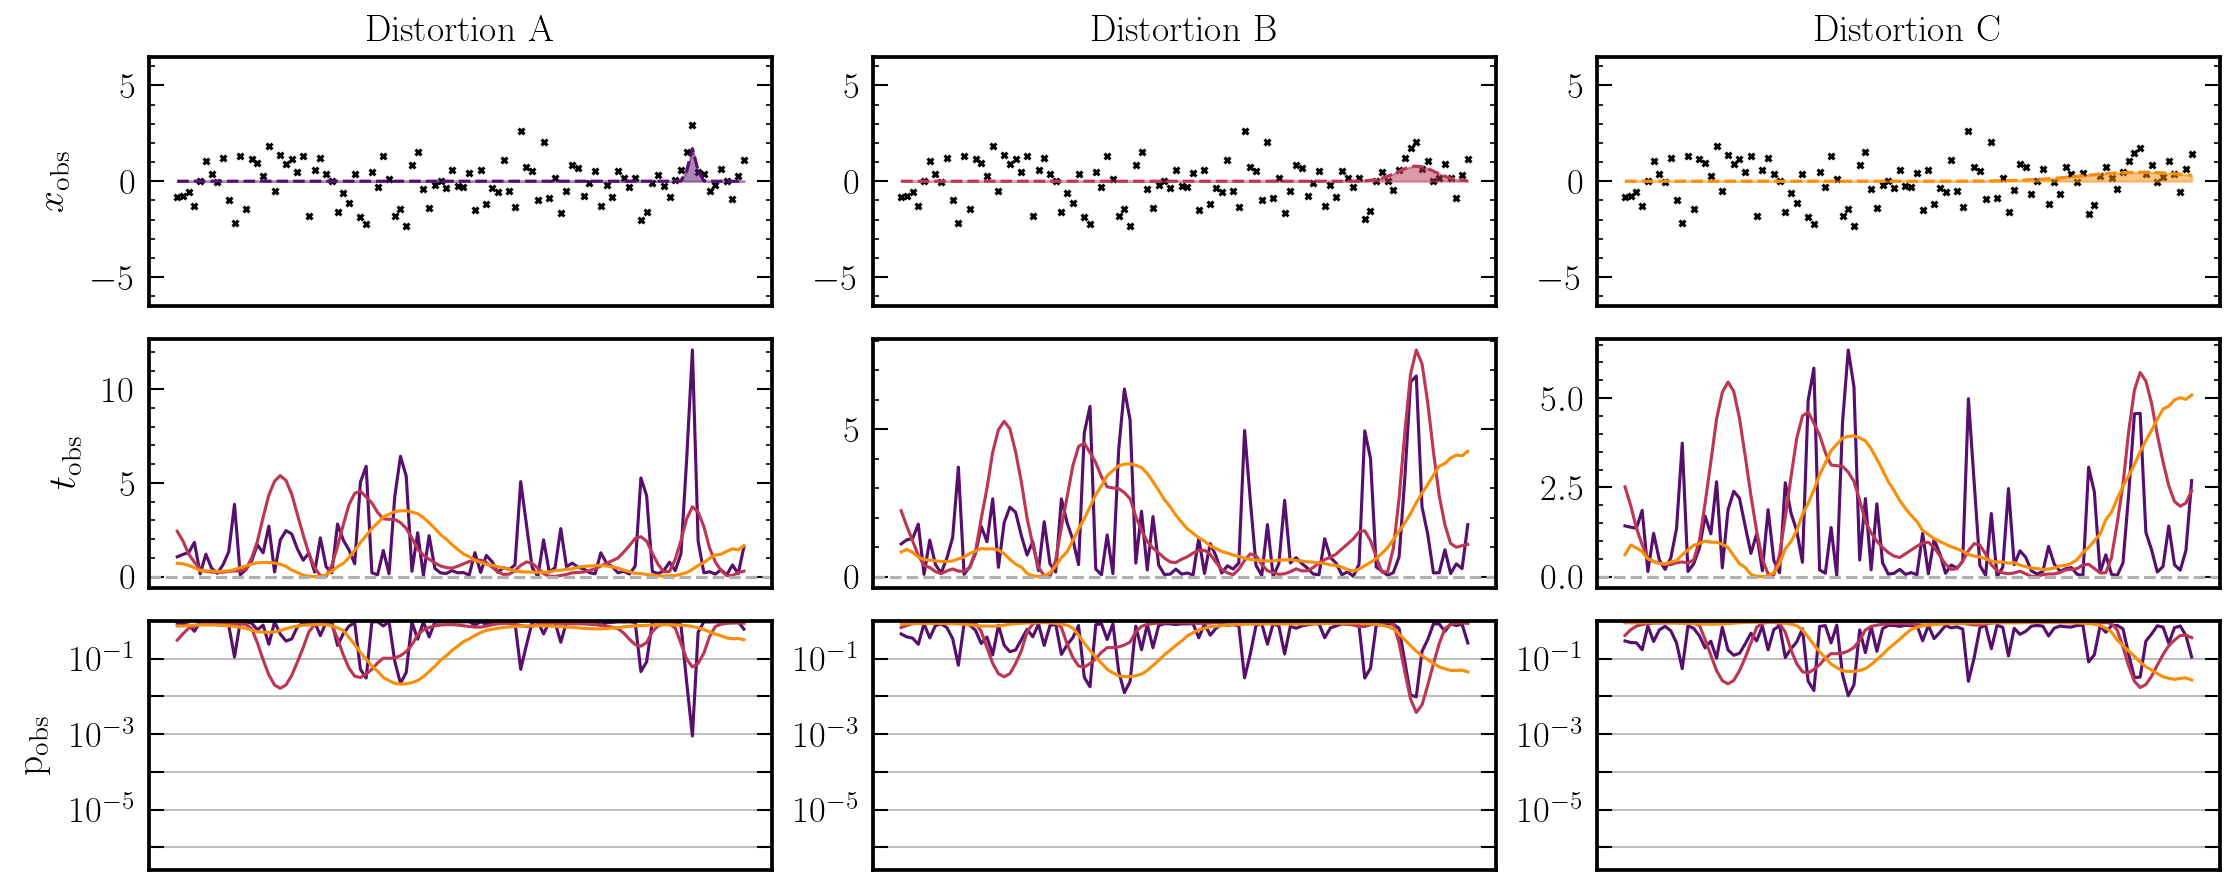

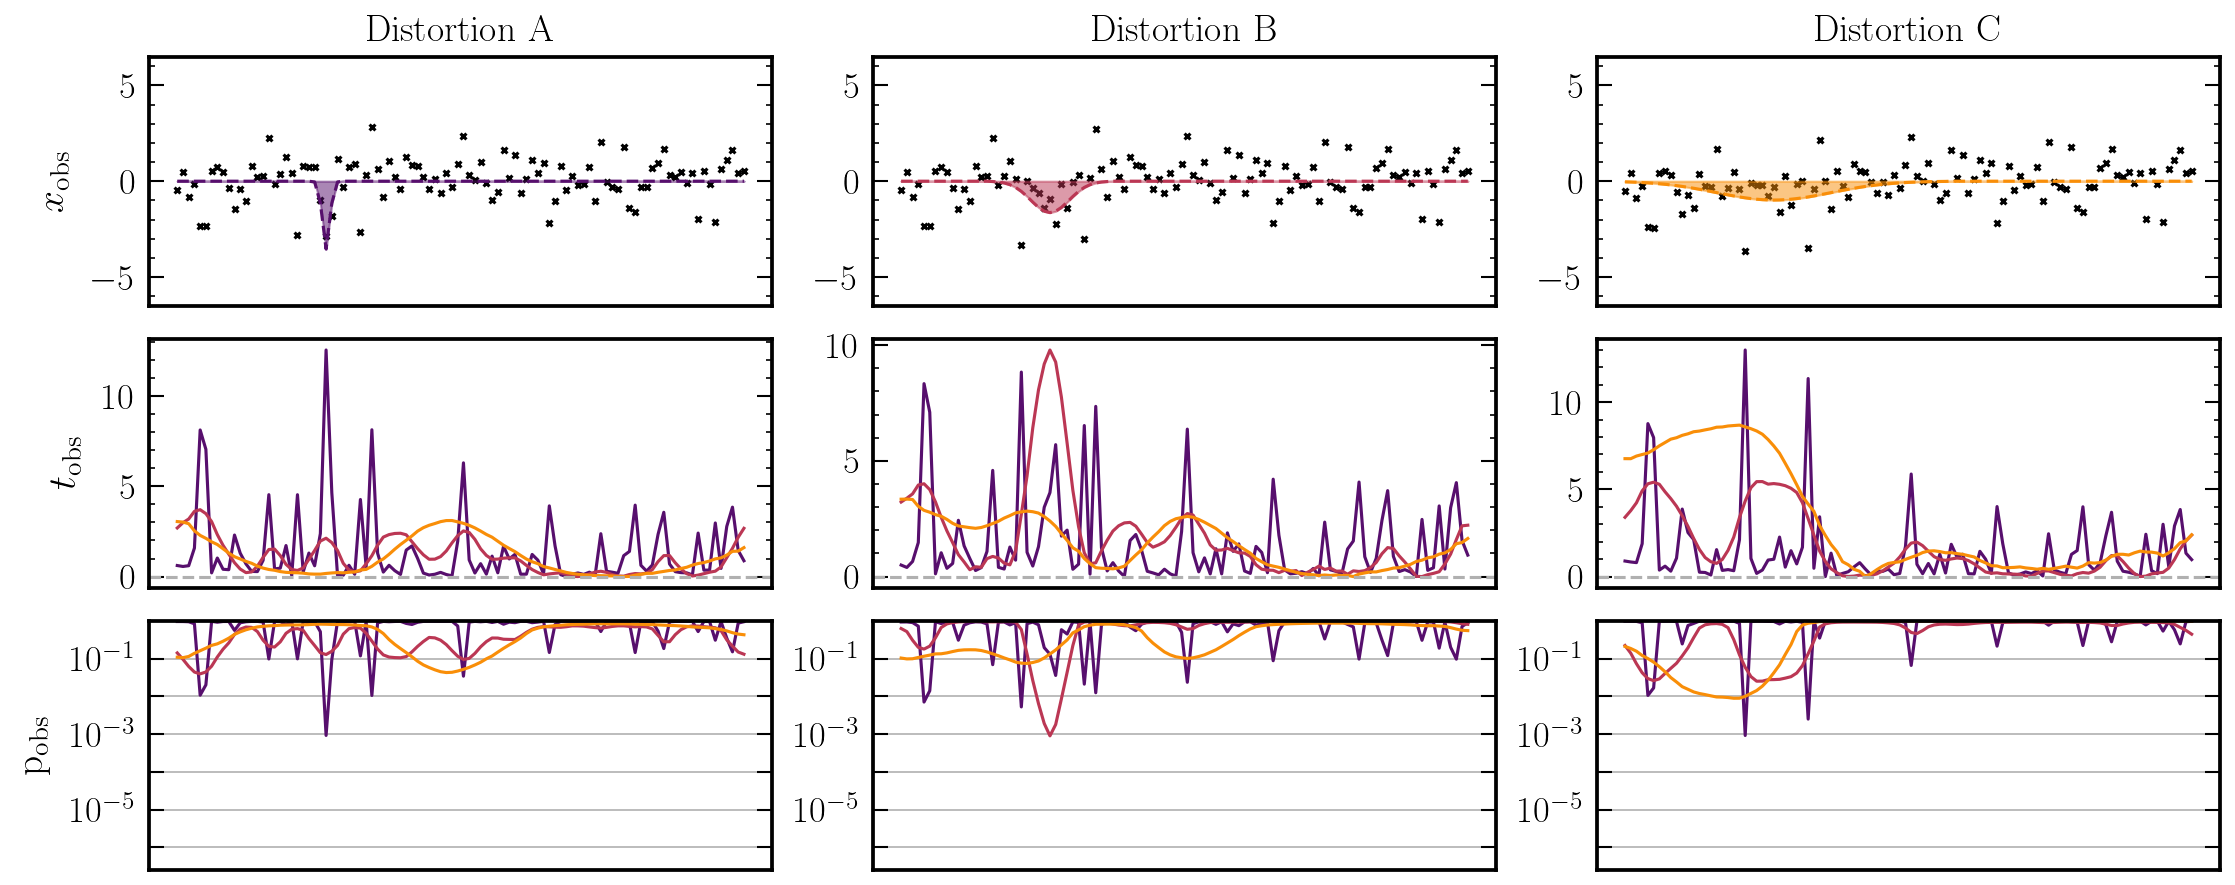

In [40]:
for nn in range(2):
    obs = simulator.sample(1)
    dist = obs['xi'] - obs['x0'] 

    fig, axs = plt.subplots(3, 3, figsize=(15, 6), dpi=150)
    labels = ["A", "B", "C"]
    for i in range(3):
        
        target = obs.copy()
        target['xi'] = obs['xi'][:, i, :].unsqueeze(1).expand(-1, len(simulator.correlation_scales), -1)
        ts_bin_obs = ts_sbi(target, model=1)
            
        # Compute p-values
        _p_nn = []
        for idx, ts_bin in enumerate(ts_bin_obs.T):
            ts_bin_i = ts_bin_H0_BCE[:, :, idx]          #[N_mc, len(correlation_scales)]
            m = ts_bin_i.mean(0)                     #[len(correlation_scales)]
            ts0_ref = ts_bin_i - m                   #[N_mc, len(correlation_scales)]
            ts_obs = (ts_bin - m)
            _p_nn.append(np.stack([
                t_to_pvalue_empirical(ts_obs[c], ts0_ref[:, c]) for c in range(len(simulator.correlation_scales))
            ], axis=0))        #[len(correlation_scales)]
        p_nn = np.array(_p_nn)                   #[Nbins, len(correlation_scales)]

        # Plotting
        axs[0, i].scatter(grid, obs['xi'][0, i], color='k', marker='x', s=8)
        axs[0, i].plot(grid, dist[0, i], color=mycolors[i], ls='--', label="$\mu_{\mathrm{dist}}$")
        axs[0, i].fill_between(grid, 0, dist[0, i], color=mycolors[i], alpha=0.5)
        axs[0, i].set_title(f"Distortion {labels[i]}")
        axs[0, i].set_ylim(-6.5, 6.5)
        axs[0, i].set_xticks([])
        
        for idx, color in enumerate(mycolors):  # Loop through colors and indices
            axs[1, i].plot(grid, (ts_bin_obs.T - ts_bin_obs.T.min(axis=0))[:, idx], c=color)  # Plot each line with the corresponding color
        # axs[1, i].set_ylim(-.5, 6.5)
        axs[1, i].axhline(0, color='#b0b0b0', linestyle='--')
        axs[1, i].set_xticks([])

        for idx, color in enumerate(mycolors):
            axs[2, i].semilogy(grid, p_nn[:, idx], c=color)
        axs[2, i].set_ylim(1/(N_mc*2), 1)
        axs[2, i].grid(True, axis='y')
        axs[2, i].set_xticks([])
        axs[2, i].yaxis.set_major_locator(ticker.LogLocator(base=10.0, numticks=10))
        axs[2, i].yaxis.set_minor_locator(ticker.NullLocator())
        axs[2, i].grid(True, axis='y', which='major')
        axs[2, i].set_yticks([1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6])  # Specify tick positions
        axs[2, i].set_yticklabels([r"$10^{-1}$", None , r"$10^{-3}$", None, r"$10^{-5}$", None])  # Customize tick labels
        
        
    # axs[0, 0].legend()
    axs[0, 0].set_ylabel("$x_\mathrm{obs}$")
    axs[1, 0].set_ylabel(r"$t_\mathrm{obs}$")
    axs[2, 0].set_ylabel("$\mathrm{p}_\mathrm{obs}$")
    plt.tight_layout();

    # plt.savefig(f"./figs/example_BCE_{nn}.pdf", transparent=True, dpi=300)
    # plt.close()

---

### Total deviations test

- Aggregated $t_{\rm sum}(x) = \sum_{i=1}^{N_{\rm alt}} - 2 \log\frac{p(x|H_0)}{p(x|H_i)} $
- Aggregated $\mathrm{p_{sum}}$ for model validation

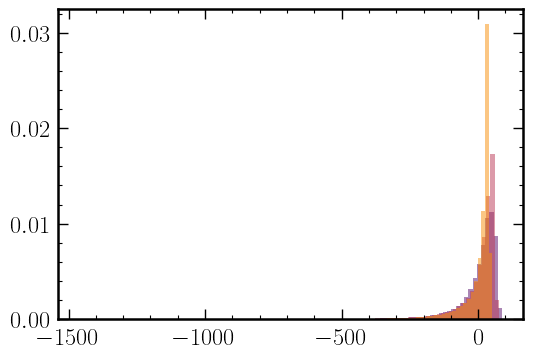

In [41]:
# From MCMC samples
ts_sum_H0_BCE  = ts_bin_H0_BCE.sum(axis=-1)                  #[N_mc, len(correlation_scales)]
ts_sum_H0_BCE_mean = ts_sum_H0_BCE.mean(0, keepdims=True)   #[1, len(correlation_scales)]
ts_sum_H0_BCE  = ts_sum_H0_BCE - ts_sum_H0_BCE_mean              #[N_mc, len(correlation_scales)]   

# Plot
fig, ax = plt.subplots(1, 1, figsize=(6, 4), dpi=100)
bins = np.linspace(ts_sum_H0_BCE.min(), ts_sum_H0_BCE.max(), 100)
for i in range(len(correlation_scales)):
    ax.hist(ts_sum_H0_BCE [:, i], bins=100, alpha=0.5, color=mycolors[i], density=True);

#### Plot

In [42]:
obs = simulator.sample(1)
target = obs.copy()
target['xi'] = obs['xi'][:, i, :].unsqueeze(1).expand(-1, len(simulator.correlation_scales), -1)
target['x0'] = obs['x0'].unsqueeze(1).expand(-1, len(simulator.correlation_scales), -1)
ts_bin_obs = ts_sbi(target, model=1)
ts_sum_nn = ts_bin_obs.sum(axis=-1)- ts_sum_H0_BCE_mean[0]
ts_sum_nn

p_sum_nn = np.stack([
        t_to_pvalue_empirical(ts_sum_nn[c], ts_sum_H0_BCE[:, c]) for c in range(len(simulator.correlation_scales))
    ], axis=0)        #[len(correlation_scales)]

ts_sum_nn, p_sum_nn

(array([ 30.216255, -18.338188, -70.35396 ], dtype=float32),
 array([0.44776191, 0.7723884 , 0.90320775]))

/scratch-local/noemiam.8976036/ipykernel_2697282/2960523466.py:54: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc='best')


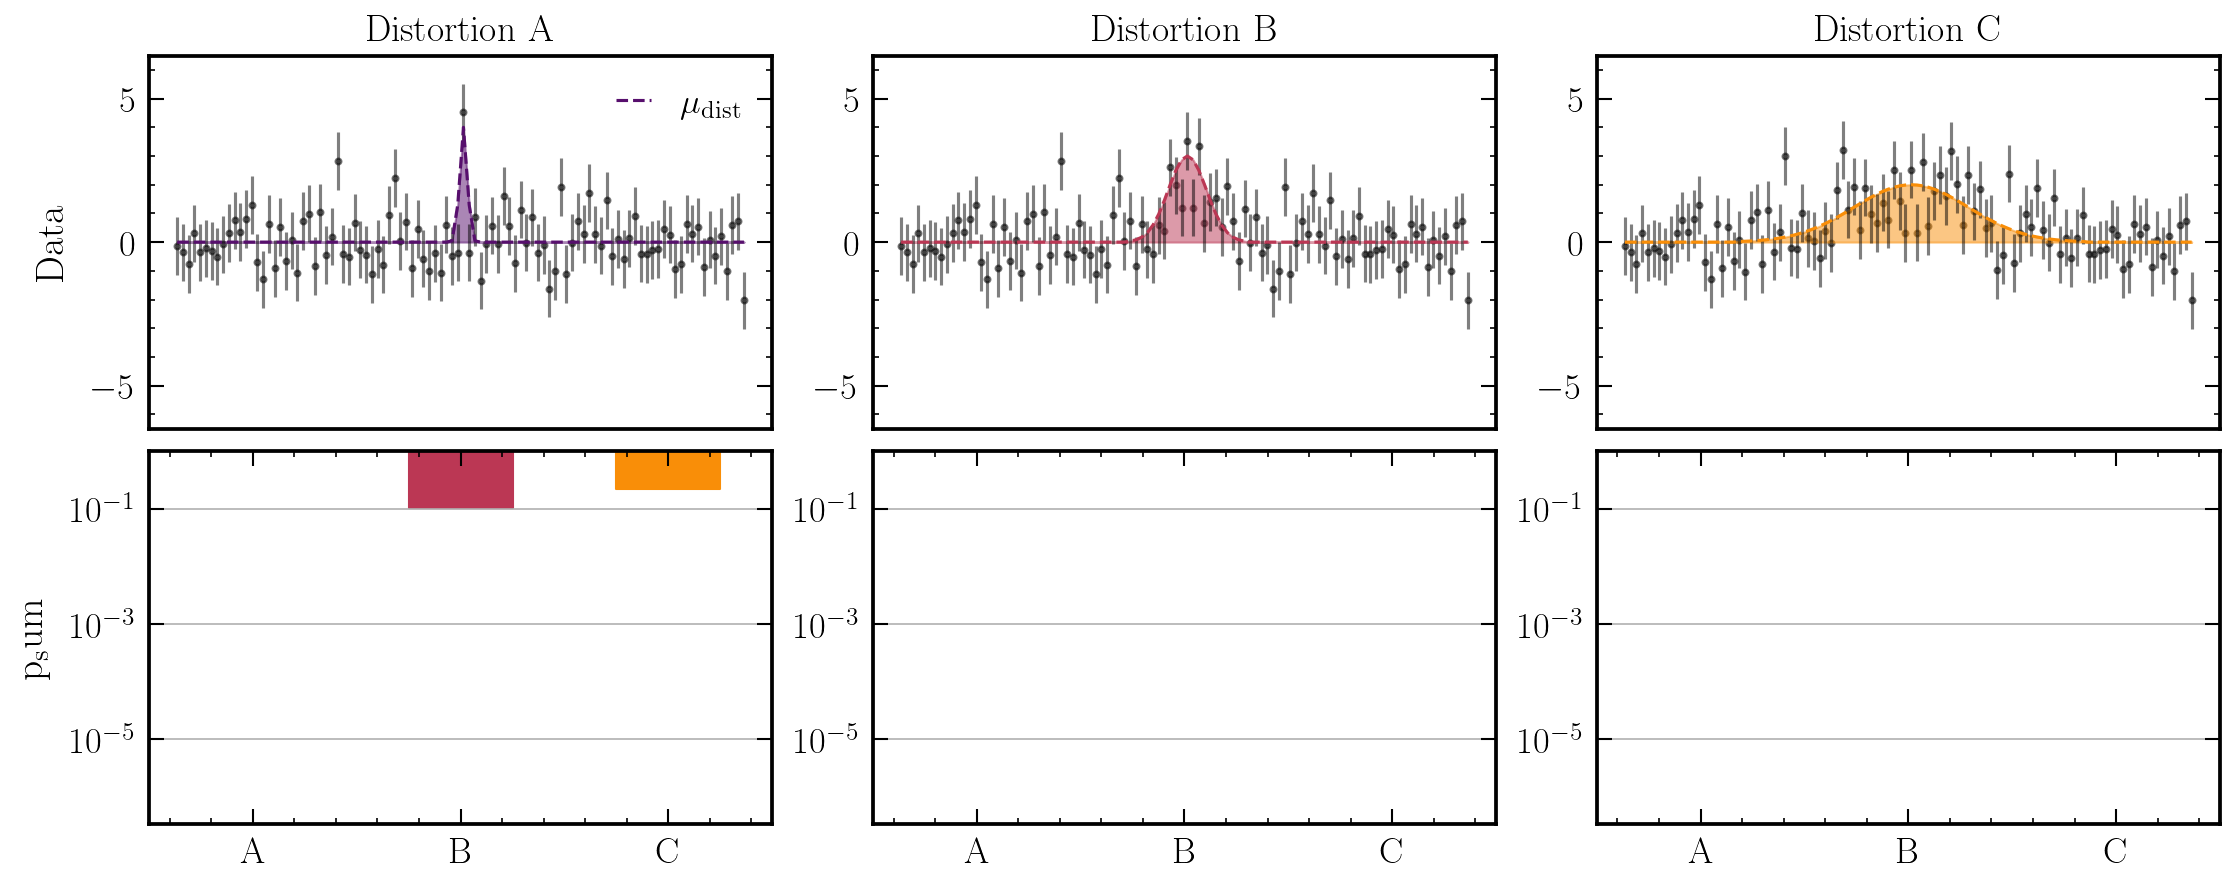

In [43]:
obs = simulator.sample(1)
# Choose clear distortion
obs['ni'][obs['ni']==1] = 0
obs['ni'][0,50] = 1
obs['epsilon'] = obs['ni'].unsqueeze(1) * torch.tensor([4, 3, 2]).unsqueeze(0).unsqueeze(2)
obs['cni'] = simulator.get_correlation(obs['ni'],  obs['epsilon'])
obs['xi'] = simulator.get_x_Hi(obs['cni'], obs['x0'].unsqueeze(1))

# fit = []
# for c in range(len(correlation_scales)):
#     fit.append(best_fit(obs['xi'][0, c], simulator))
# fit = np.stack(fit, axis=1)
delta_x = (obs['xi']).to(torch.float32)
dist = obs['xi'] - obs['x0']
grid = torch.linspace(0, 10, Nbins)

fig, axs = plt.subplots(2, 3, figsize=(15, 6), dpi=150)
labels = ["A", "B", "C"]
for i in range(3):
    
    target = obs.copy()
    target['xi'] = obs['xi'][:, i, :].unsqueeze(1).expand(-1, len(simulator.correlation_scales), -1)
    ts_bin_obs = ts_sbi(target, model=1)
    ts_sum_nn = ts_bin_obs.sum(axis=-1)-ts_sum_H0_BCE_mean[0]

    p_sum_nn = np.stack([
        t_to_pvalue_empirical(ts_sum_nn[c], ts_sum_H0_BCE[:, c]) for c in range(len(simulator.correlation_scales))
    ], axis=0)        #[len(correlation_scales)]

    # Plotting
    axs[0, i].scatter(grid, obs['xi'][0, i], color='k', alpha=0.5, s=8)
    axs[0, i].errorbar(grid, obs['xi'][0, i], yerr=1, fmt='none', ecolor='k', alpha=0.5)
    axs[0, i].plot(grid, dist[0, i], color=mycolors[i], ls='--', label="$\mu_{\mathrm{dist}}$")
    axs[0, i].fill_between(grid, 0, dist[0, i], color=mycolors[i], alpha=0.5)
    axs[0, i].set_title(f"Distortion {labels[i]}")
    axs[0, i].set_ylim(-6.5, 6.5)
    axs[0, i].set_xticks([])
    
    axs[1, i].set_yscale('log')
    axs[1, i].set_ylim(1/(N_mc*1.5), 1)
    axs[1, i].set_xticks([0, 1, 2])
    axs[1, i].set_xticklabels(labels)
    axs[1, i].set_xlim(-0.5, 3 - 0.5)
    axs[1, i].grid(True, axis='y')
    for x, value_nn in zip([0, 1, 2], p_sum_nn):
        left = x - 0.5 / 2
        right = x + 0.5 / 2
        axs[1, i].fill_between([left, right], 1, value_nn, facecolor=mycolors[x], edgecolor=mycolors[x])
    
axs[0, 0].set_ylabel("Data")
axs[1, 0].set_ylabel("$\mathrm{p_sum}$")

for ax in axs[:, 0]:
    ax.legend(loc='best')

plt.tight_layout();

---

### Global deviations test

Trial correct for the fact that we looked Nbins times + aggregated tests. What’s the overall significance given I’ve looked so many times? Each of the trials is one test


In [44]:
ts_bin_H0_BCE.shape, ts_sum_H0_BCE.shape

((1998848, 3, 100), (1998848, 3))

Compute p-values for the individual tests (Nbins)

In [45]:
N_mc, num_resolutions, num_bins = ts_bin_H0_BCE.shape

ts_bin_flat = ts_bin_H0_BCE.reshape(N_mc, num_resolutions * num_bins)
means = ts_bin_flat.mean(axis=0)  # Shape: [num_resolutions * num_bins]
ts_centered = ts_bin_flat - means  # Shape: [N_mc, num_resolutions * num_bins]

# Sort the centered data along N_mc axis
sorted_ts = np.sort(ts_centered, axis=0)  # Shape: [N_mc, num_resolutions * num_bins]
# Compute ranks for all values
ranks = np.argsort(np.argsort(-ts_centered, axis=0), axis=0)  # Ranks in descending order
# Compute p-values
p_values = (ranks + 1) / N_mc
# Reshape back to [N_mc, num_resolutions, num_bins]
pv_bin_H0 = p_values.reshape(N_mc, num_resolutions, num_bins)

# # Initialize an array to hold the p-values
# p_values = np.zeros_like(ts_centered)

# # For each test statistic (flattened index), compute the p-values
# for idx in range(ts_centered.shape[1]):
#     ts0_ref = ts_centered[:, idx]  # Shape: [N_mc]
#     ts_obs = ts0_ref  # Observed values are the same as ts0_ref in this context

#     # Sort the reference distribution
#     sorted_ts0_ref = np.sort(ts0_ref)

#     # Compute ranks using searchsorted
#     ranks = np.searchsorted(sorted_ts0_ref, ts_obs, side='right')

#     # Adjust counts to exclude the observed value itself
#     counts = N_mc - 1  # Exclude ts_obs from counts

#     # Since ts_obs is included in ts0_ref, subtract 1 from ranks and counts
#     p_values[:, idx] = 1 - (ranks - 1) / counts

# # Reshape p_values back to [N_mc, num_resolutions, num_bins]
# pv_bin_H0 = p_values.reshape(N_mc, num_resolutions, num_bins)    
    
pv_bin_H0.shape

(1998848, 3, 100)

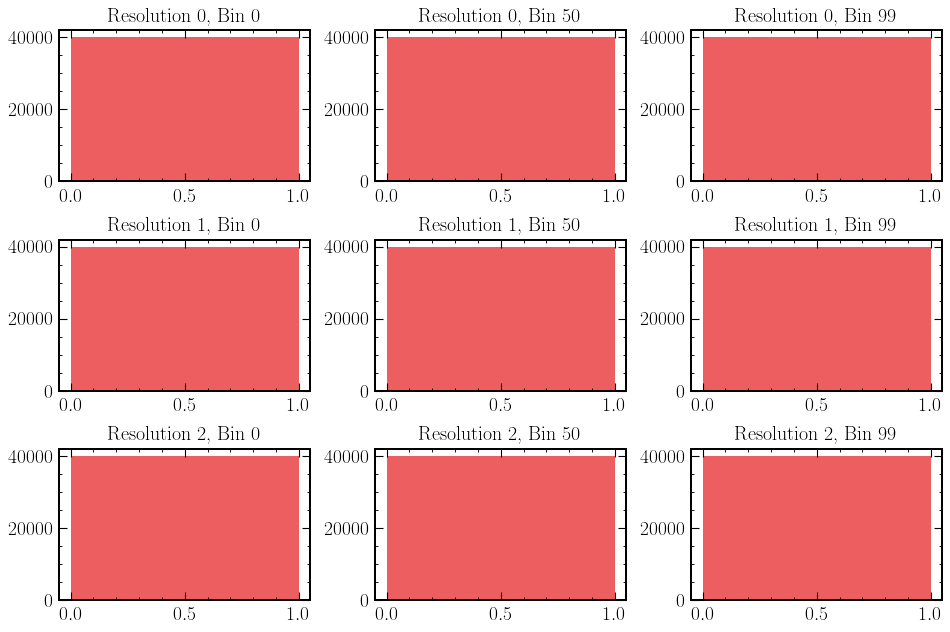

In [46]:
# p-values are uniformly distribute

selected_resolutions = [0, 1, 2]       # Resolutions to plot
selected_bins = [0, 50, 99]            # Bins to plot

fig, axs = plt.subplots(len(selected_resolutions), len(selected_bins), figsize=(12, 8))
for i, res in enumerate(selected_resolutions):
    for j, bin_idx in enumerate(selected_bins):
        pv_data = pv_bin_H0[:, res, bin_idx]
        axs[i, j].hist(pv_data, bins=50, alpha=0.7)
        axs[i, j].set_title(f'Resolution {res}, Bin {bin_idx}')

plt.tight_layout()
plt.show()

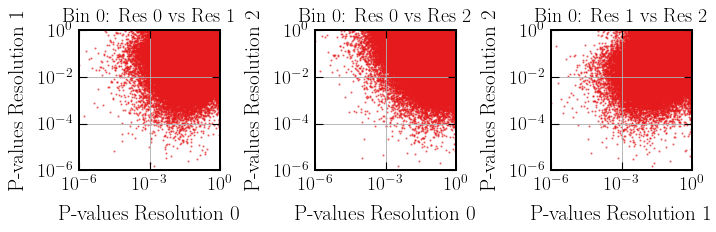

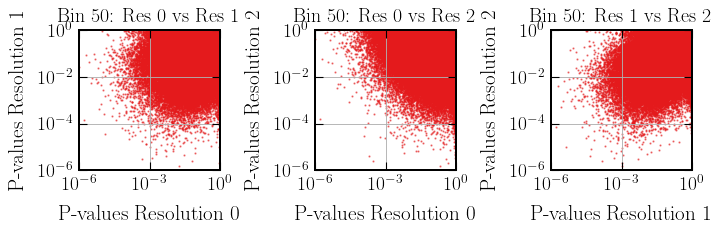

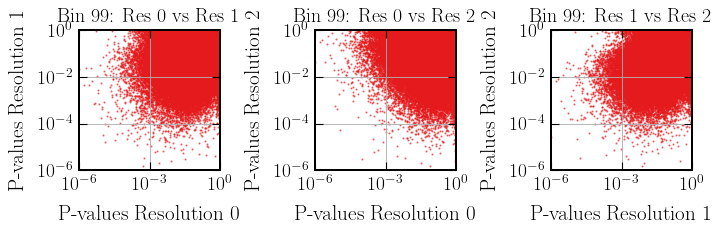

In [47]:
# p-values between different tests are correlated

bins_to_analyze = [0, 50, 99] 

for bin_idx in bins_to_analyze:
    fig, axs = plt.subplots(1, 3, figsize=(9, 3))
    resolution_pairs = [(0, 1), (0, 2), (1, 2)]
    for i, (res1, res2) in enumerate(resolution_pairs):
        p_values_res1 = pv_bin_H0[:, res1, bin_idx]
        p_values_res2 = pv_bin_H0[:, res2, bin_idx]

        axs[i].scatter(p_values_res1, p_values_res2, alpha=0.5, s=1)
        axs[i].set_xlabel(f'P-values Resolution {res1}')
        axs[i].set_ylabel(f'P-values Resolution {res2}')
        axs[i].set_title(f'Bin {bin_idx}: Res {res1} vs Res {res2}')
        axs[i].set_xlim(1e-6, 1)
        axs[i].set_ylim(1e-6, 1)
        axs[i].set_yscale('log')
        axs[i].set_xscale('log')
        axs[i].grid(True)

    plt.tight_layout()
    plt.show()


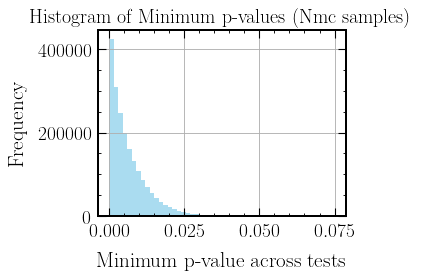

In [48]:
# MINIMUM

Nmc = pv_bin_H0.shape[0]
min_pv_bin_H0_BCE = np.min(pv_bin_H0.reshape(Nmc, -1), axis=1)  # Shape: [Nmc]

plt.figure(figsize=(4, 3))
plt.hist(min_pv_bin_H0_BCE, bins=50, alpha=0.7, color='skyblue')
plt.xlabel('Minimum p-value across tests')
plt.ylabel('Frequency')
plt.title('Histogram of Minimum p-values (Nmc samples)')
plt.grid(True)
plt.show()


Compute p-values for the total tests (3 for the correlation scales) and take them min

In [49]:
N_mc, num_resolutions = ts_sum_H0_BCE .shape
means = ts_sum_H0_BCE .mean(axis=0)  # Shape: [num_resolutions]
ts_centered = ts_sum_H0_BCE  - means  # Shape: [N_mc, num_resolutions]
sorted_ts = np.sort(ts_centered, axis=0)  # Shape: [N_mc, num_resolutions]
ranks = np.argsort(np.argsort(-ts_centered, axis=0), axis=0)  # Ranks in descending order
p_values = (ranks + 1) / N_mc
pv_sum_H0 = p_values.reshape(N_mc, num_resolutions) 
pv_sum_H0.shape

(1998848, 3)

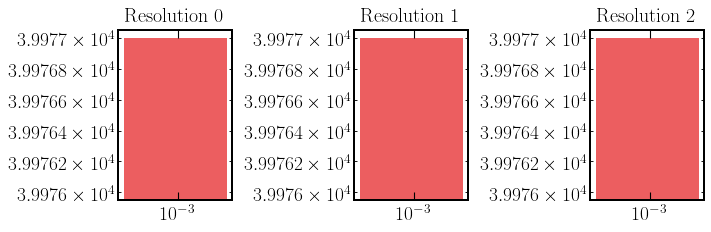

In [50]:
selected_resolutions = [0, 1, 2]       # Resolutions to plot

fig, axs = plt.subplots(1, len(selected_resolutions), figsize=(9, 3))

for i, res in enumerate(selected_resolutions):
    pv_data = pv_bin_H0[:, res, bin_idx]
    axs[i].hist(pv_data, bins=50, alpha=0.7)
    axs[i].set_title(f'Resolution {res}')
    axs[i].set_yscale('log')
    axs[i].set_xscale('log')

plt.tight_layout()
plt.show()

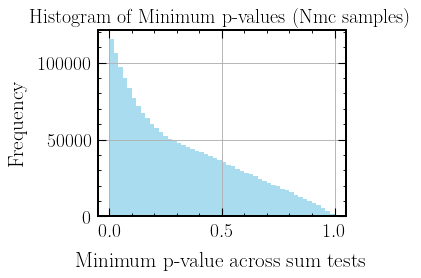

In [51]:
min_pv_sum_H0_BCE = np.min(pv_sum_H0.reshape(Nmc, -1), axis=1)  # Shape: [Nmc]

plt.figure(figsize=(4, 3))
plt.hist(min_pv_sum_H0_BCE, bins=50, alpha=0.7, color='skyblue')
plt.xlabel('Minimum p-value across sum tests')
plt.ylabel('Frequency')
plt.title('Histogram of Minimum p-values (Nmc samples)')
plt.grid(True)
plt.show()


Consider all tests

(1998848, 303)


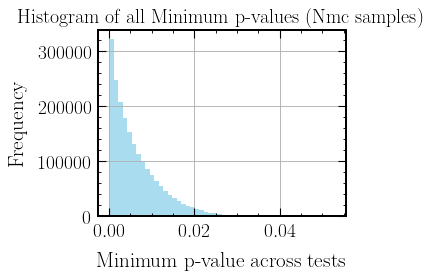

In [52]:
# MINIMUM

Nmc = pv_bin_H0.shape[0]
pv_all_H0 = np.concatenate([pv_bin_H0.reshape(Nmc, -1), pv_sum_H0], axis=1)  # Shape: [Nmc, num_resolutions * num_bins + num_resolutions]
print(pv_all_H0.shape)

min_pv_all_H0_BCE = np.min(pv_all_H0, axis=1)  # Shape: [Nmc]

plt.figure(figsize=(4, 3))
plt.hist(min_pv_all_H0_BCE, bins=50, alpha=0.7, color='skyblue')
plt.xlabel('Minimum p-value across tests')
plt.ylabel('Frequency')
plt.title('Histogram of all Minimum p-values (Nmc samples)')
plt.grid(True)
plt.show()


---

### Summary plot

In [53]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable
from cycler import cycler

mygold = (218/255, 165/255, 32/255, 0.1)  

def cax(ax, pad=0.05):
    divider = make_axes_locatable(ax)
    return divider.append_axes(position='top', size='5%', pad=pad)

In [55]:
def analyse_obs_BCE(obs, i_c):
    
    target = obs.copy()
    target['xi'] = obs['xi'][:, i_c, :].unsqueeze(1).expand(-1, len(simulator.correlation_scales), -1)
    ts_bin_obs = ts_sbi(target, model=1)
    ts_sum_nn = ts_bin_obs.sum(axis=-1)-ts_sum_H0_BCE_mean[0] 
    p_sum_nn = np.stack([
        t_to_pvalue_empirical(ts_sum_nn[c], ts_sum_H0_BCE[:, c]) for c in range(len(simulator.correlation_scales))
    ], axis=0)        #[len(correlation_scales)]
    # Compute p-values
    _p_nn = []
    for idx, ts_bin in enumerate(ts_bin_obs.T):
        ts_bin_i = ts_bin_H0_BCE[:, :, idx]          #[N_mc, len(correlation_scales)]
        m = ts_bin_i.mean(0)                     #[len(correlation_scales)]
        ts0_ref = ts_bin_i - m                   #[N_mc, len(correlation_scales)]
        ts_obs = (ts_bin - m)
        _p_nn.append(np.stack([
            t_to_pvalue_empirical(ts_obs[c], ts0_ref[:, c]) for c in range(len(simulator.correlation_scales))
        ], axis=0))        #[len(correlation_scales)]
    p_nn = np.array(_p_nn)                   #[Nbins, len(correlation_scales)]


    # Compute global p-values
    obs_min_pv_bin = p_nn.reshape(-1).min()
    obs_min_pv_sum = p_sum_nn.reshape(-1).min()
    pv_all_obs = np.concatenate([
        p_nn.reshape(-1),  # Shape: [num_resolutions * Nbins]
        p_sum_nn  # Shape: [num_resolutions]
    ], axis=0)  # Combined shape: [num_total_tests]
    obs_min_pv_all = pv_all_obs.min()

    p_glob_bin = np.mean(min_pv_bin_H0_BCE <= obs_min_pv_bin)
    p_glob_sum = np.mean(min_pv_sum_H0_BCE <= obs_min_pv_sum)
    p_glob_all = np.mean(min_pv_all_H0_BCE <= obs_min_pv_all)

    return ts_bin_obs, p_nn, p_sum_nn, p_glob_all


def plot_analysis_BCE(obs, ts_bin_obs, p_nn, p_sum_nn, p_glob_all, i_c, ax_dist=True):
    
    dist1 = obs['xi'] - obs['x0']

    # Figure
    fig = plt.figure(figsize=(10, 8), dpi=250)
    gs = plt.GridSpec(3, 2, figure=fig, height_ratios=[1, 1, 1], width_ratios=[2, 1], hspace=0.3, wspace=0.3)

    # First row: ax1 spans both columns
    ax1 = fig.add_subplot(gs[0, 0])
    xi = obs['xi'][0, i_c]
    ni = obs['ni'][0] 
    epsilon = obs['epsilon'][0] 
    ax1.scatter(grid, xi, color='k', marker='x', s=8)
    ax1.plot(grid, dist1[0, i_c], color=mycolors[i_c], label="$\mu_{\mathrm{dist B}}$")
    ax1.fill_between(grid, 0, dist1[0, i_c], color=mycolors[i_c], alpha=0.5)
    ax1.set_ylabel("$x_\mathrm{obs}$", labelpad=1.5)
    # ax1.plot([], [], c='k', label="$x_\mathrm{obs}$")
    # ax1.legend(loc='best', handlelength=1)
    # ax1.set_xticklabels([])
    ax1.set_ylim(-6.5, 6.5)
    ax1.legend(bbox_to_anchor=(0.02, .33), fontsize=13, loc='upper left', labelspacing=0.1)
    ax1.set_xticks([])
    ax1.set_title("Data")

    if ax_dist:
        ax_dist = fig.add_subplot(gs[0, 1])
        mask = np.where(dist1[0,-1]!=0)
        fakegrid = torch.linspace(0, len(mask[0]), len(mask[0]))
        ax_dist.plot(fakegrid, dist1[0,0][mask]/dist1[0,0][mask].max()+2, c=mycolors[0])
        ax_dist.plot(fakegrid, dist1[0,1][mask]/dist1[0,1][mask].max(), c=mycolors[1])
        ax_dist.plot(fakegrid, dist1[0,2][mask]/dist1[0,2][mask].max()-2, c=mycolors[2])
        ax_dist.text(fakegrid.max() + 3, 2, 'A', verticalalignment='center')
        ax_dist.text(fakegrid.max() + 3, 0, 'B', verticalalignment='center')
        ax_dist.text(fakegrid.max() + 3, -2, 'C', verticalalignment='center')
        ax_dist.axis('off')
        ax_dist.set_ylim(-5,5)
        ax_dist.set_xlim(-len(mask[0]),2*len(mask[0]))
        ax_dist.set_title("Distortions")

    # Second column: ax2 and ax3 in the first column
    ax2 = fig.add_subplot(gs[1, 0])
    for ccc, _ in enumerate(mycolors):
        ax2.semilogy(grid, p_nn[:, ccc], c=mycolors[ccc])
    ax2.set_ylabel("$\mathrm{p}_\mathrm{obs}$", labelpad=1.5)
    ax2.legend(loc='lower right',  fontsize=15)
    ax2.set_ylim(1/(N_mc*5), 1)
    # ax2.set_xlabel("$i$", labelpad=1.5)
    ax2.set_title("Anomaly detection")
    ax2.set_xticks([])
    ax2.yaxis.set_major_locator(ticker.LogLocator(base=10.0, numticks=10))
    ax2.yaxis.set_minor_locator(ticker.NullLocator())
    ax2.grid(True, axis='y', which='major')
    ax2.set_yticks([1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6])  # Specify tick positions
    ax2.set_yticklabels([r"$10^{-1}$", None , r"$10^{-3}$", None, r"$10^{-5}$", None])  # Customize tick labels

    ax3 = fig.add_subplot(gs[2, 0])
    for ccc, _ in enumerate(mycolors):
        ax3.plot(grid, ts_bin_obs.T[:,ccc] - (ts_bin_obs.T[:,ccc]).min(), c=mycolors[ccc])
    ax3.set_ylabel(r"$t_\mathrm{obs}$")
    ax3.legend(loc='best',  fontsize=13)
    ax3.axhline(0, color='#b0b0b0', ls='--', lw=1)
    # ax3.set_ylim(-.5, 6.5)
    ax3.set_xticks([])


    # Second column: ax4 and ax6 in the second column

    # Bars
    ax4 = fig.add_subplot(gs[1, 1])
    ax4.set_yscale('log')
    ax4.set_ylim(1/(N_mc*5), 1)
    ax4.set_xticks([0, 1, 2])
    ax4.set_xticklabels(["A", "B","C"])
    ax4.set_xlim(-0.5, 3 - 0.5)
    ax4.set_ylabel("$\mathrm{p}_\mathrm{sum}$")
    ax4.grid(True, axis='y', which='both')
    for x, value_nn in zip([0, 1, 2], p_sum_nn):
        left = x - 0.5 / 2
        right = x + 0.5 / 2
        ax4.fill_between([left, right], 1, value_nn, facecolor=mycolors[x], edgecolor=mycolors[x])
    ax4.set_title("Model validation")
    ax4.tick_params(axis="x",direction="in", pad=-25)
    ax4.minorticks_off()
    ax4.yaxis.set_major_locator(ticker.LogLocator(base=10.0, numticks=10))
    ax4.yaxis.set_minor_locator(ticker.NullLocator())
    ax4.grid(True, axis='y', which='major')
    ax4.set_yticks([1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6])  # Specify tick positions
    ax4.set_yticklabels([r"$10^{-1}$", None , r"$10^{-3}$", None, r"$10^{-5}$", None])  # Customize tick labels

    # Add on gs[0, 1] text reporting the three global p-values
    mantissa, exp = ('%.2e' % p_glob_all).split('e')
    exp = int(exp)
    textstr = r'$\mathrm{p}_{\mathrm{glob}}= %s \times 10^{%d}$' % (mantissa, exp)
    ax3.text(0.6, -0.4, textstr, transform=ax3.transAxes, fontsize=14,
                verticalalignment='center', horizontalalignment='center',
                bbox=dict(
                    facecolor=mygold,
                    edgecolor='none'  # Remove the border if not needed
                )
            )
    ax3.text(0.2, -0.4, "Global p-value", transform=ax3.transAxes, fontsize=18,
                verticalalignment='center', horizontalalignment='center')

In [2]:
simulator = Simulator_Additive_Correlated(
    Nbins=Nbins, sigma=SIGMA, bounds=bounds, fraction=None, bkg=False,
    correlation_scales = correlation_scales,
    dtype=torch.float32, device='cpu'
    )     

for nn in range(2):
    i_c = 1
    # Choose clear distortion
    obs = simulator.sample(1)
    obs['x0'] = simulator.get_x_H0(1, obs['mu'])
    obs['ni'][obs['ni']==1] = 0
    obs['ni'][0,50] = 1
    obs['epsilon'] = obs['ni'].unsqueeze(1) * torch.tensor([1.7, 1.7, 1.7]).unsqueeze(0).unsqueeze(2)
    obs['cni'] = simulator.get_correlation(obs['ni'],  obs['epsilon'])
    obs['xi'] = simulator.get_x_Hi(obs['cni'], obs['x0'].unsqueeze(1))

    ts_bin_obs, p_nn, p_sum_nn, p_glob_all = analyse_obs_BCE(obs, i_c)
    plot_analysis_BCE(obs, ts_bin_obs, p_nn, p_sum_nn, p_glob_all, i_c, ax_dist=True)
    # plt.savefig(f"./figs/obs_BCE_1_{nn}.pdf", transparent=True, dpi=300)
    # torch.save(obs, f"./figs/obs_BCE_1_{nn}.pt")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


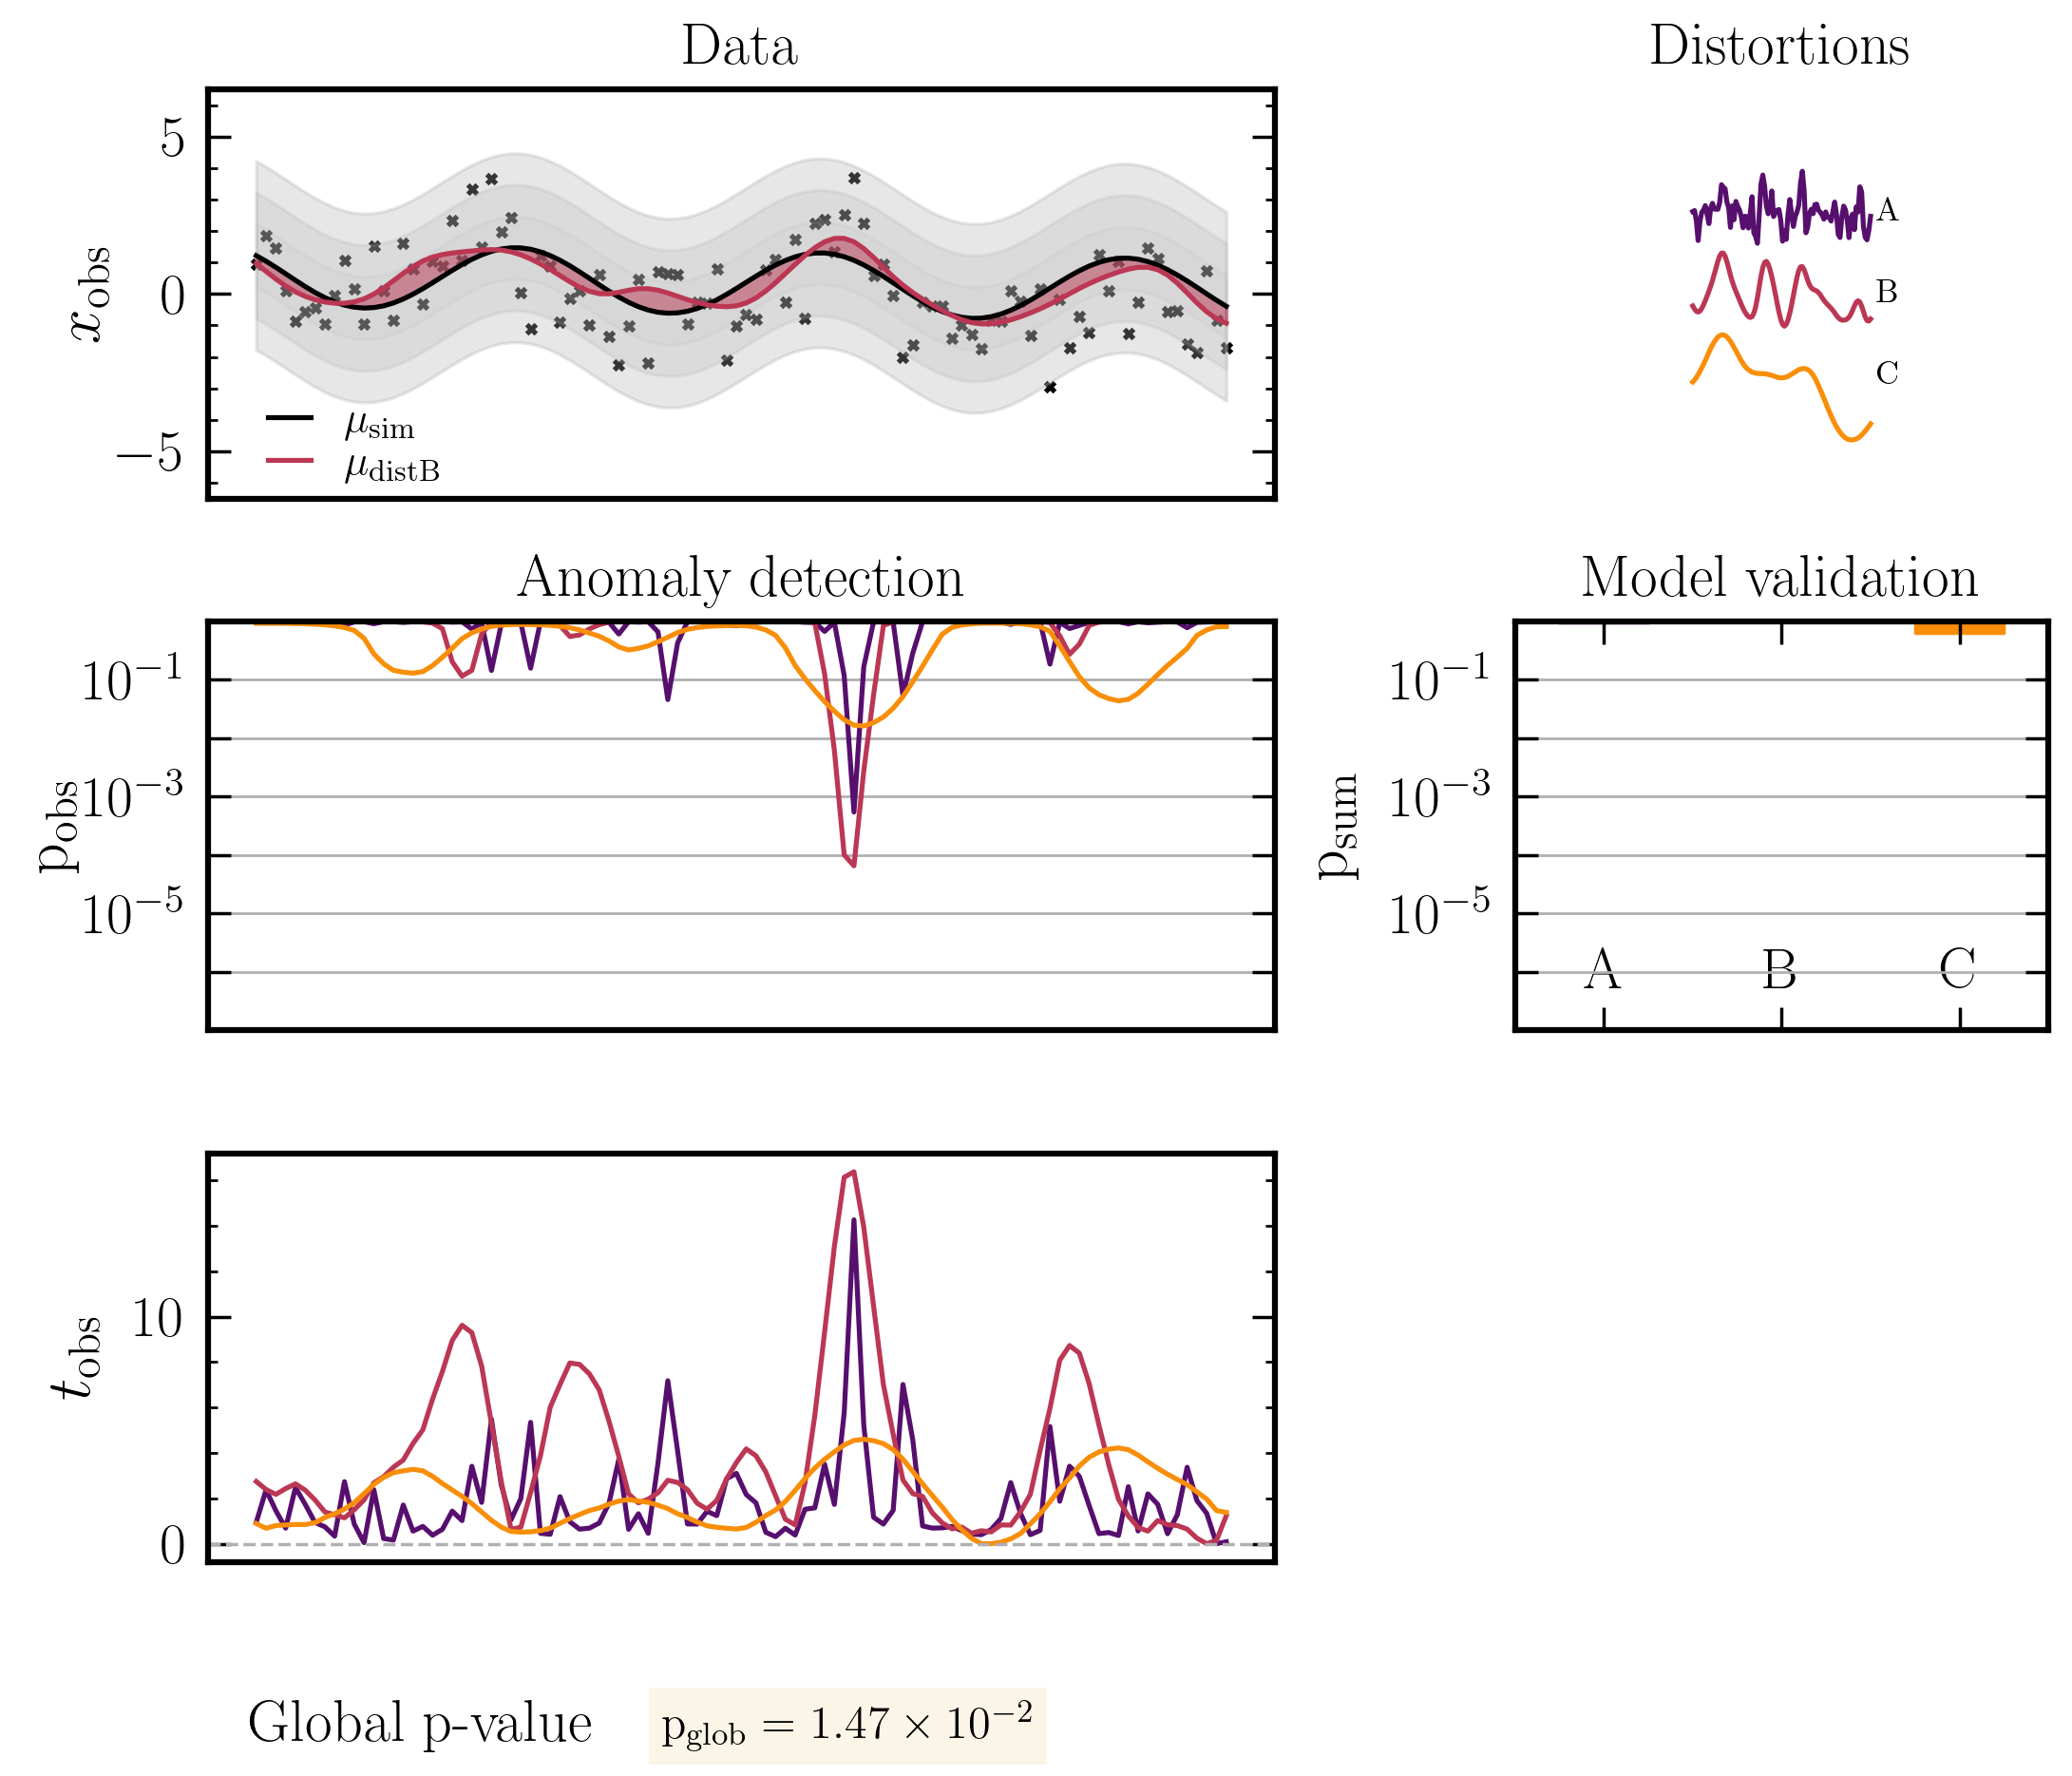

In [ ]:
simulator1 = Simulator_Additive_Correlated(
    Nbins=Nbins, sigma=SIGMA, bounds=torch.tensor([.45, .45, .45]), fraction=0.6, sample_fraction=False, 
    correlation_scales = correlation_scales, bkg=False, 
    dtype=torch.float32, device='cpu'
    )     # Just one bin is distorted with fraction=None  
obs = simulator1.sample(1) 

ts_bin_obs, p_nn, p_sum_nn, p_glob_all = analyse_obs_BCE(obs, i_c)
plot_analysis_BCE(obs, ts_bin_obs, p_nn, p_sum_nn, p_glob_all, i_c, ax_dist=True)

## Comparison

In [59]:
def analytical_analysis(obs, i_c):

    delta_x = obs['xi']
    
    delta_x_target = delta_x[:, i_c].unsqueeze(1).expand(-1, len(simulator.correlation_scales), -1).to(torch.float32)

    # Compute analytical epsilon and SNR^2 test statistic
    snr2_analytical = torch.stack([
        get_snr(delta_x_target[:, c], cni_templates[:, c]).squeeze(0)**2 for c in range(len(simulator.correlation_scales))
    ], dim=0)        #[len(correlation_scales), Nbins]

    _p_analytical = []
    for idx, _ in enumerate(snr2_analytical.T):
        _p_analytical.append(np.stack([
            t_to_pvalue(snr2_analytical[c, idx], 1) for c in range(len(simulator.correlation_scales))
        ], axis=0))        #[len(correlation_scales)]
    p_analytical = np.array(_p_analytical)   #[Nbins, len(correlation_scales)]
    
    # # Compute analytical ratio (they should match at the correct ic...)
    # ts_bin_analytical = (((obs['xi'][:, i_c]- delta_x[:, i_c])**2)/SIGMA**2)[0]-1 
    
    # pvalues_analytical = []
    # for idx, ts_bin in enumerate(ts_bin_analytical):
    #     pvalues_analytical.append(t_to_pvalue(ts_bin+1, 1))
    # p_bin_analytical = np.array(pvalues_analytical)

    return snr2_analytical, p_analytical #, ts_bin_analytical, p_bin_analytical


In [ ]:
# obs = simulator.sample(1)
# # Choose clear distortion
# # obs['x0'] = simulator.get_x_H0(1, obs['mu'])
# obs['ni'][obs['ni']==1] = 0
# obs['ni'][0, 50] = 1
# obs['epsilon'] = obs['ni'].unsqueeze(1) * torch.tensor([3.2, 2.1, 1.1]).unsqueeze(0).unsqueeze(2)
# obs['cni'] = simulator.get_correlation(obs['ni'],  obs['epsilon'])
# obs['xi'] = simulator.get_x_Hi(obs['cni'], obs['x0'].unsqueeze(1))

obs = torch.load("./notebooks/figs/example_SNR_12.pt")
obs['x0'] = obs['x0'] - obs['mu']
obs['xi'] = obs['xi'] - obs['mu'].unsqueeze(1)

dist = obs['xi'] - obs['x0']
grid = torch.linspace(0, 10, Nbins)

ts_bin_obs_0, p_nn_BCE_0, p_sum_nn_BCE_0, p_glob_all_BCE_0 = analyse_obs_BCE(obs, 0)
ts_bin_obs_1, p_nn_BCE_1, p_sum_nn_BCE_1, p_glob_all_BCE_1 = analyse_obs_BCE(obs, 1)
ts_bin_obs_2, p_nn_BCE_2, p_sum_nn_BCE_2, p_glob_all_BCE_2 = analyse_obs_BCE(obs, 2)

epsilon_nn_0, variance_nn_0, snr2_nn_0, p_nn_SNR_0, p_sum_nn_SNR_0, p_glob_all_SNR_0 = analyse_obs_epsilon(obs, 0)
epsilon_nn_1, variance_nn_1, snr2_nn_1, p_nn_SNR_1, p_sum_nn_SNR_1, p_glob_all_SNR_1 = analyse_obs_epsilon(obs, 1)
epsilon_nn_2, variance_nn_2, snr2_nn_2, p_nn_SNR_2, p_sum_nn_SNR_2, p_glob_all_SNR_2 = analyse_obs_epsilon(obs, 2)

# snr2_analytical_0, p_analytical_SNR_0, ts_bin_analytical_0, p_analytical_BCE_0 = analytical_analysis(obs, 0)
# snr2_analytical_1, p_analytical_SNR_1, ts_bin_analytical_1, p_analytical_BCE_1 = analytical_analysis(obs, 1)
# snr2_analytical_2, p_analytical_SNR_2, ts_bin_analytical_2, p_analytical_BCE_2 = analytical_analysis(obs, 2)
snr2_analytical_0, p_analytical_SNR_0 = analytical_analysis(obs, 0)
snr2_analytical_1, p_analytical_SNR_1 = analytical_analysis(obs, 1)
snr2_analytical_2, p_analytical_SNR_2 = analytical_analysis(obs, 2)

# plot_analysis_BCE(obs, ts_bin_obs_0, p_nn_BCE_0, p_sum_nn_BCE_0, p_glob_all_BCE_0, 0, ax_dist=True)
# plot_analysis_BCE(obs, ts_bin_obs_1, p_nn_BCE_1, p_sum_nn_BCE_1, p_glob_all_BCE_1, 1, ax_dist=True)
# plot_analysis_BCE(obs, ts_bin_obs_2, p_nn_BCE_2, p_sum_nn_BCE_2, p_glob_all_BCE_2, 2, ax_dist=True)
# plot_analysis_epsilon(obs, epsilon_nn_0, variance_nn_0, p_nn_SNR_0, p_sum_nn_SNR_0, p_glob_all_SNR_0, 0, ax_dist=True)
# plot_analysis_epsilon(obs, epsilon_nn_1, variance_nn_1, p_nn_SNR_1, p_sum_nn_SNR_1, p_glob_all_SNR_1, 1, ax_dist=True)
# plot_analysis_epsilon(obs, epsilon_nn_2, variance_nn_2, p_nn_SNR_2, p_sum_nn_SNR_2, p_glob_all_SNR_2, 2, ax_dist=True)

/scratch-local/noemiam.8976036/ipykernel_2697282/3371091632.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  obs = torch.load("./notebooks/figs/example_SNR_12.pt")


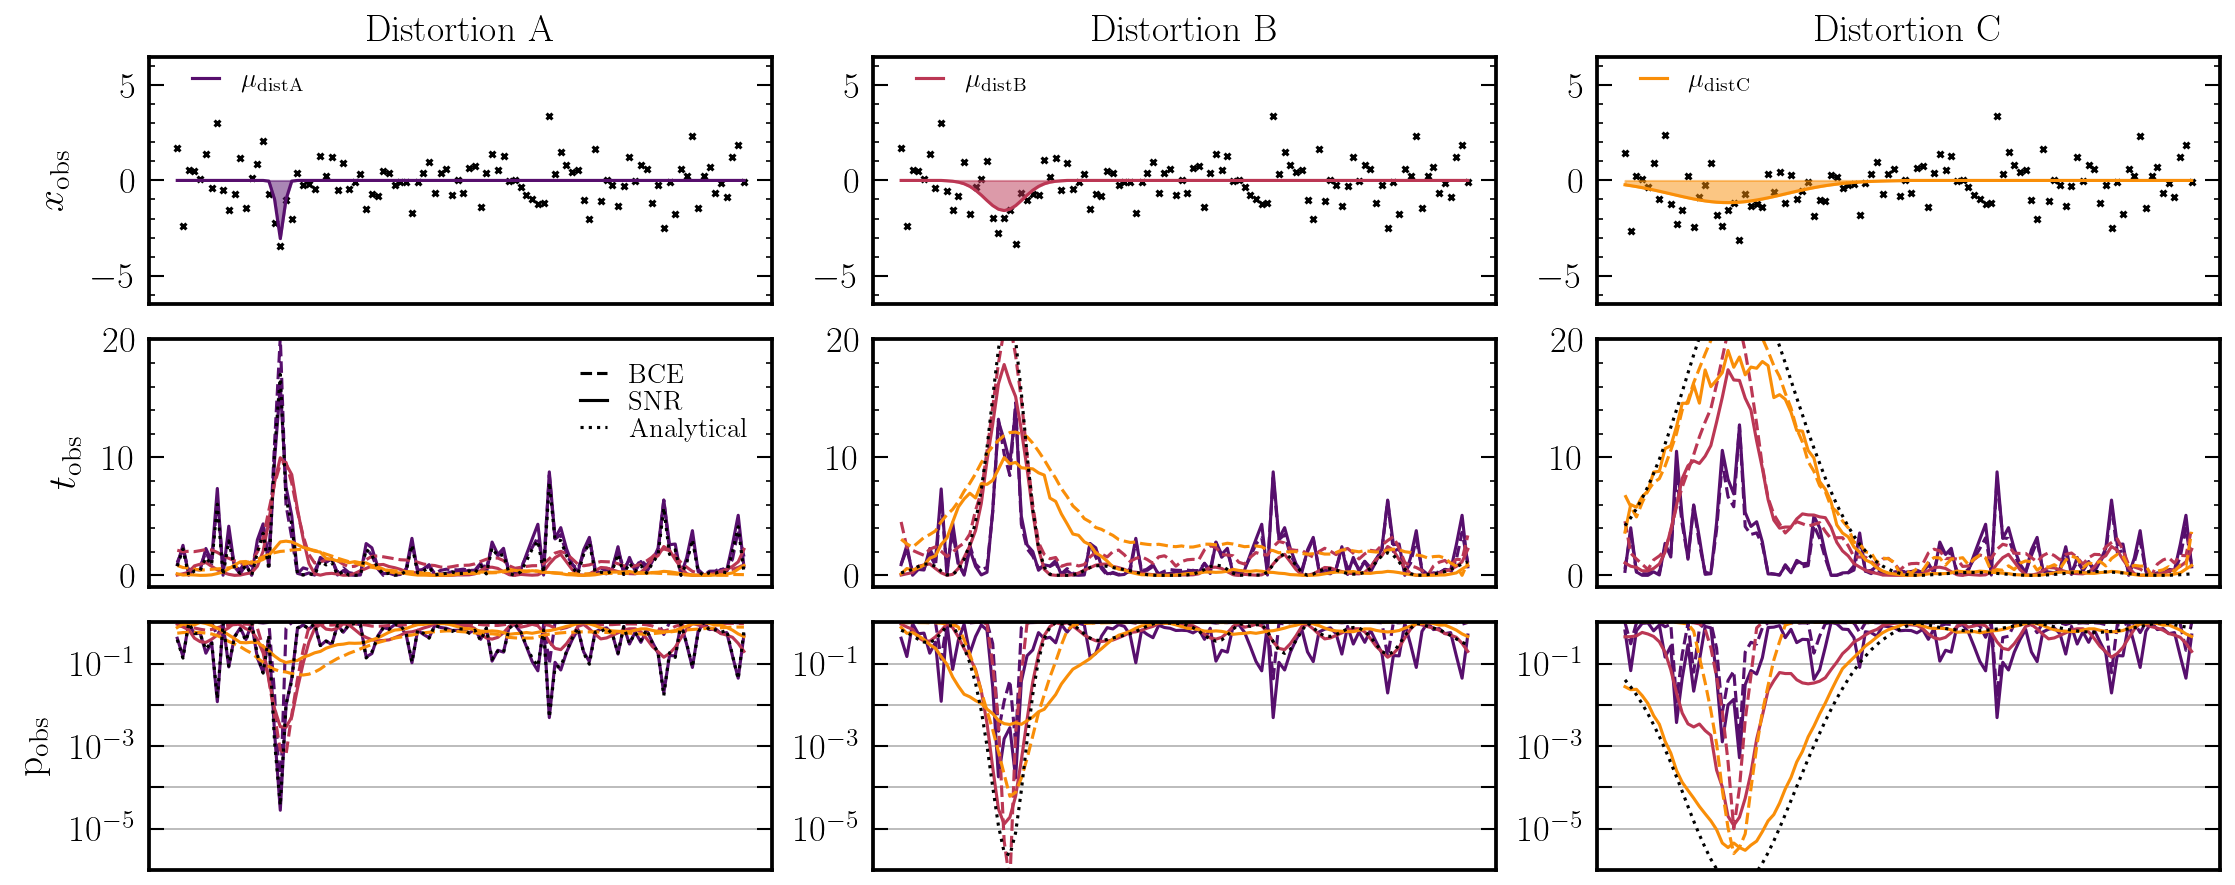

In [62]:
fig, axs = plt.subplots(3, 3, figsize=(15, 6), dpi=150)
labels = ["A", "B", "C"]
for i, (snr2_nn, p_nnSNR, ts, p_nnBCE, snr2_analytical, p_analytical) in enumerate(zip(
    [snr2_nn_0, snr2_nn_1, snr2_nn_2], [p_nn_SNR_0, p_nn_SNR_1, p_nn_SNR_2],
    [ts_bin_obs_0, ts_bin_obs_1, ts_bin_obs_2], [p_nn_BCE_0, p_nn_BCE_1, p_nn_BCE_2],
    [snr2_analytical_0, snr2_analytical_1, snr2_analytical_2], [p_analytical_SNR_0, p_analytical_SNR_1, p_analytical_SNR_2],
    # [ts_bin_analytical_0, ts_bin_analytical_1, ts_bin_analytical_2], [p_analytical_BCE_0, p_analytical_BCE_1, p_analytical_BCE_2],
    )):
    
    # Plotting
    # axs[0, i].plot(grid, obs['mu'][0], color='k', label="$\mu_{\mathrm{sim}}$")
    axs[0, i].scatter(grid, obs['xi'][0, i], color='k', marker='x', s=8)
    axs[0, i].plot(grid, dist[0, i], color=mycolors[i], label=fr"$\mu_{{\mathrm{{dist{labels[i]}}}}}$")
    axs[0, i].fill_between(grid, 0, dist[0, i], color=mycolors[i], alpha=0.5)
    axs[0, i].set_title(f"Distortion {labels[i]}")
    axs[0, i].set_ylim(-6.5, 6.5)
    axs[0, i].set_xticks([])
    axs[0, i].legend(bbox_to_anchor=(0.03, 1.05), fontsize=13, loc='upper left', labelspacing=0.1)

    for idx, color in enumerate(mycolors):
        axs[1, i].plot(grid, snr2_nn.T[:,idx], c=color)
        axs[1, i].plot(grid, ts.T[:, idx] - ts.T[:, idx].min(), ls='--', c=color)
    axs[1, i].set_ylim(-1, 20)
    axs[1, i].set_xticks([])
    axs[1, i].plot([], [], c='k', ls='--', label="BCE")
    axs[1, i].plot([], [], c='k', label="SNR")
    axs[1, i].plot(grid, snr2_analytical.T[:, i], ls='dotted', c='k', label='Analytical')

    for idx, color in enumerate(mycolors):
        axs[2, i].semilogy(grid, p_nnSNR[:, idx], c=color)
        axs[2, i].semilogy(grid, p_nnBCE[:, idx], ls='--', c=color)
    axs[2, i].semilogy(grid, p_analytical[:, i], ls='dotted', c='k')
    axs[2, i].set_ylim(2e-5, 1)
    axs[2, i].grid(True, axis='y')
    axs[2, i].set_xticks([])
    axs[2, i].yaxis.set_major_locator(ticker.LogLocator(base=10.0, numticks=10))
    axs[2, i].yaxis.set_minor_locator(ticker.NullLocator())
    axs[2, i].grid(True, axis='y', which='major')
    axs[2, i].set_yticks([1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6])  # Specify tick positions
    axs[2, i].set_yticklabels([r"$10^{-1}$", None , r"$10^{-3}$", None, r"$10^{-5}$", None])  # Customize tick labels
    
    
# axs[0, 0].legend()
axs[0, 0].set_ylabel("$x_\mathrm{obs}$")
axs[1, 0].set_ylabel(r"$t_\mathrm{obs}$")
axs[2, 0].set_ylabel("$\mathrm{p}_\mathrm{obs}$")
axs[1, 0].legend(fontsize=13, loc='upper right', labelspacing=0.1)
# axs[2, 0].legend(loc='best')
plt.tight_layout();

plt.savefig(f"./notebooks/figs/comparison - no bkg.pdf", transparent=True, dpi=300)
# torch.save(obs, f"./figs/example_SNR_{nn}.pt")